# 1D 热控制系统仿真与恒温器/加热器位置优化

## 概述

本 Notebook 在一维空间域 $[0, L]$ 上求解热传导方程，研究加热器位置、恒温器位置、热源类型和边界条件对控制性能的影响。

### 1D 模型

$$\frac{\partial T}{\partial t} = \alpha \frac{\partial^2 T}{\partial x^2} + u(t) \cdot f(x)$$

其中 $f(x)$ 为热源空间分布函数（点热源或高斯热源），$u(t) \in [0, U_{\max}]$ 由迟滞（Hysteresis）控制器根据恒温器读数决定。

### 实验设计

- **实验一**：点热源，3 组加热器/BC 配置，扫描恒温器位置
- **实验二**：高斯热源重复 + 全枚举搜索最优方案
- **实验三**：辅助可视化工具

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# 输出目录
import os
OUT_DIR = '1D_output'
os.makedirs(OUT_DIR, exist_ok=True)

# 全局绘图风格
sns.set_style('whitegrid')
plt.rcParams.update({
    'figure.dpi': 150,
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 12,
    'legend.fontsize': 9,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'savefig.bbox': 'tight',
    'savefig.dpi': 300
})

# 实验配色
EXP_COLORS = {
    '1.1': '#e74c3c', '1.2': '#3498db', '1.3': '#2ecc71',
    '2.1': '#e74c3c', '2.2': '#3498db', '2.3': '#2ecc71',
}
SOURCE_COLORS = {'point': '#e74c3c', 'gaussian': '#3498db'}
BC_COLORS = {'NR': '#9b59b6', 'RR': '#e67e22'}

print('所有库导入成功。')

所有库导入成功。


## 参数定义

| 参数 | 符号 | 值 | 单位 |
|------|------|-----|------|
| 环境温度 | $T_a$ | 5 | °C |
| 设定温度 | $T_{set}$ | 20 | °C |
| 初始温度 | $T_{init}$ | 15 | °C |
| 热扩散率 | $\alpha$ | 0.5 | m²/min |
| 壁面换热系数 | $h_{wall}$ | 0.5 | m⁻¹ |
| 最大加热功率 | $U_{max}$ | 5.0 | °C/min |
| 空间域长度 | $L$ | 5 | m |
| 仿真时长 | $t_{end}$ | 60 | min |
| 迟滞带宽 | $\delta$ | 0.5 | °C |
| 高斯宽度 | $\sigma$ | 0.5 | m |

In [2]:
# ============================================================
# 系统参数
# ============================================================
T_A = 5.0          # 环境温度 (°C)
T_SET = 20.0       # 设定温度 (°C)
T_INIT = 15.0      # 初始温度 (°C)
ALPHA = 0.5        # 热扩散率 (m²/min)
H_WALL = 0.5       # 壁面换热系数 (m⁻¹)
U_MAX = 5.0        # 最大加热功率 (°C/min)
L = 5.0            # 空间域长度 (m)
T_END = 60.0       # 仿真时长 (min)
DELTA = 0.5        # 迟滞带宽 (°C)
SIGMA_GAUSS = 0.5  # 高斯热源宽度 (m)

# 舒适区间
T_COMFORT_LOW = 18.0
T_COMFORT_HIGH = 26.0

# 细网格（用于详细扫描实验）
N_X_FINE = 51       # 空间节点数 (dx=0.1m)
DT_FINE = 0.005     # 时间步长 (r=0.25, 稳定)

# 粗网格（用于全枚举）
N_X_COARSE = 26     # 空间节点数 (dx=0.2m)
DT_COARSE = 0.02    # 时间步长 (r=0.25, 稳定)

# 恒温器扫描位置
X_S_SWEEP = np.linspace(0.25, 4.75, 19)

# 权重方案
WEIGHT_SCHEMES = {
    'Balanced': {'w_E': 0.15, 'w_R': 0.25, 'w_O': 0.15, 'w_C': 0.15, 'w_S': 0.15, 'w_T': 0.15},
    'Comfort':  {'w_E': 0.10, 'w_R': 0.25, 'w_O': 0.20, 'w_C': 0.20, 'w_S': 0.10, 'w_T': 0.15},
    'Energy':   {'w_E': 0.30, 'w_R': 0.20, 'w_O': 0.10, 'w_C': 0.10, 'w_S': 0.15, 'w_T': 0.15},
}

print(f'细网格: N_x={N_X_FINE}, dt={DT_FINE}, r={ALPHA*DT_FINE/(L/(N_X_FINE-1))**2:.3f}')
print(f'粗网格: N_x={N_X_COARSE}, dt={DT_COARSE}, r={ALPHA*DT_COARSE/(L/(N_X_COARSE-1))**2:.3f}')
print(f'恒温器扫描: {len(X_S_SWEEP)} 个位置, 从 {X_S_SWEEP[0]:.2f} 到 {X_S_SWEEP[-1]:.2f} m')

细网格: N_x=51, dt=0.005, r=0.250
粗网格: N_x=26, dt=0.02, r=0.250
恒温器扫描: 19 个位置, 从 0.25 到 4.75 m


## 1D PDE 求解器

使用有限差分法（FTCS 显式格式）求解一维热传导方程。

**边界条件：**
- **N-R**（Neumann-Robin）：左端 $x=0$ 绝热，右端 $x=L$ 与外界换热
- **R-R**（Robin-Robin）：两端均与外界换热

**热源分布：**
- 点热源：$f(x) = \frac{L}{\Delta x} \delta_{x_h}$
- 高斯热源：$f(x) = L \cdot \mathcal{N}(x_h, \sigma^2) / \int \mathcal{N} dx$

归一化约定：$(1/L)\int_0^L f(x)\,dx = 1$，使得空间平均加热率 = $u(t)$。

In [3]:
# ============================================================
# 1D 热传导方程求解器
# ============================================================

def simulate_1d(x_h, x_s, bc_type='NR', source_type='point',
                sigma=SIGMA_GAUSS, dt=DT_FINE, N_x=N_X_FINE,
                T_a=T_A, T_set=T_SET, T_init=T_INIT,
                alpha=ALPHA, h_wall=H_WALL, U_max=U_MAX,
                L_val=L, t_end=T_END, delta=DELTA,
                return_field=False):
    """
    1D 热传导方程求解器 + 迟滞控制器。
    
    返回 dict:
      t, x, T_final, T_sensor, u, T_mean, CR_t,
      error_sq_mean, max_abs_error, max_overshoot
    若 return_field=True，额外返回 T_field, t_field（子采样的全场数据）
    """
    dx = L_val / (N_x - 1)
    x = np.linspace(0, L_val, N_x)
    N_t = int(t_end / dt) + 1
    t = np.linspace(0, t_end, N_t)
    r = alpha * dt / dx**2  # 稳定性参数
    
    # --- 热源空间分布 f(x)，归一化: (1/L)∫f dx = 1 ---
    if source_type == 'point':
        j_h = np.argmin(np.abs(x - x_h))
        f_src = np.zeros(N_x)
        f_src[j_h] = L_val / dx
    else:  # gaussian
        g = np.exp(-0.5 * ((x - x_h) / sigma) ** 2)
        g_int = np.trapz(g, x)
        f_src = g * L_val / g_int if g_int > 1e-12 else np.zeros(N_x)
    
    # 恒温器位置索引
    j_s = np.argmin(np.abs(x - x_s))
    
    # 初始化数组
    T_cur = np.full(N_x, T_init)
    u_arr = np.zeros(N_t)
    T_sensor = np.zeros(N_t)
    T_mean = np.zeros(N_t)
    CR_t = np.zeros(N_t)
    error_sq_mean = np.zeros(N_t)
    max_abs_error = np.zeros(N_t)
    max_overshoot = np.zeros(N_t)
    
    # 全场子采样（如需要）
    if return_field:
        save_every = max(1, N_t // 600)
        T_field_list = [T_cur.copy()]
        t_field_list = [0.0]
    
    heater_on = True  # 初始温度低于设定温度，加热器开启
    
    # 记录初始状态
    T_sensor[0] = T_cur[j_s]
    T_mean[0] = np.mean(T_cur)
    CR_t[0] = np.mean((T_cur >= T_COMFORT_LOW) & (T_cur <= T_COMFORT_HIGH))
    error_sq_mean[0] = np.mean((T_cur - T_set) ** 2)
    max_abs_error[0] = np.max(np.abs(T_cur - T_set))
    max_overshoot[0] = np.max(T_cur - T_set)
    
    for n in range(N_t - 1):
        # 迟滞控制器
        T_read = T_cur[j_s]
        if heater_on and T_read >= T_set + delta:
            heater_on = False
        elif not heater_on and T_read <= T_set - delta:
            heater_on = True
        u = U_max if heater_on else 0.0
        u_arr[n] = u
        
        # 热源项
        S = u * f_src
        
        # FTCS 更新
        T_new = T_cur.copy()
        # 内部节点
        T_new[1:-1] = (T_cur[1:-1]
                       + r * (T_cur[2:] - 2*T_cur[1:-1] + T_cur[:-2])
                       + dt * S[1:-1])
        
        # 左端 BC (i=0)
        if bc_type == 'NR':  # Neumann: dT/dx=0
            T_new[0] = T_cur[0] + r * 2*(T_cur[1] - T_cur[0]) + dt * S[0]
        else:  # RR: Robin
            T_new[0] = (T_cur[0]
                        + r * (2*T_cur[1] - 2*T_cur[0] - 2*dx*h_wall*(T_cur[0] - T_a))
                        + dt * S[0])
        
        # 右端 BC (i=N_x-1): Robin
        T_new[-1] = (T_cur[-1]
                     + r * (2*T_cur[-2] - 2*T_cur[-1] - 2*dx*h_wall*(T_cur[-1] - T_a))
                     + dt * S[-1])
        
        T_cur = T_new
        
        # 记录统计量
        T_sensor[n+1] = T_cur[j_s]
        T_mean[n+1] = np.mean(T_cur)
        CR_t[n+1] = np.mean((T_cur >= T_COMFORT_LOW) & (T_cur <= T_COMFORT_HIGH))
        error_sq_mean[n+1] = np.mean((T_cur - T_set) ** 2)
        max_abs_error[n+1] = np.max(np.abs(T_cur - T_set))
        max_overshoot[n+1] = np.max(T_cur - T_set)
        
        if return_field and (n+1) % save_every == 0:
            T_field_list.append(T_cur.copy())
            t_field_list.append(t[n+1])
    
    u_arr[-1] = U_max if heater_on else 0.0
    
    result = {
        't': t, 'x': x, 'dx': dx,
        'T_final': T_cur.copy(),
        'T_sensor': T_sensor, 'u': u_arr,
        'T_mean': T_mean, 'CR_t': CR_t,
        'error_sq_mean': error_sq_mean,
        'max_abs_error': max_abs_error,
        'max_overshoot': max_overshoot,
    }
    if return_field:
        result['T_field'] = np.array(T_field_list)
        result['t_field'] = np.array(t_field_list)
    return result

print('1D 求解器定义完成。')

1D 求解器定义完成。


In [4]:
# ============================================================
# 评价指标计算（1D 版本）
# ============================================================

def compute_metrics_1d(sim, T_set=T_SET, t_end=T_END, U_max=U_MAX, tol=0.5):
    """
    从仿真结果计算 6 个评价指标。
    使用仿真过程中已收集的空间统计量，无需全场数据。
    """
    t = sim['t']
    u = sim['u']
    
    # 1. 能耗 E = ∫u(t)dt
    E = np.trapz(u, t)
    
    # 2. RMSE = sqrt(1/t_end * ∫ mean_x((T-T_set)²) dt)
    RMSE = np.sqrt(np.trapz(sim['error_sq_mean'], t) / t_end)
    
    # 3. 最大超调（空间-时间域）
    DeltaT_max = max(0.0, np.max(sim['max_overshoot']))
    
    # 4. 舒适覆盖率 CR = 1/t_end * ∫ CR(t) dt
    CR = np.trapz(sim['CR_t'], t) / t_end
    
    # 5. 稳定时间：所有空间点均进入 ±tol 且保持
    in_band = sim['max_abs_error'] <= tol
    t_s = t_end
    for i in range(len(in_band)):
        if np.all(in_band[i:]):
            t_s = t[i]
            break
    
    # 6. 切换次数
    on_off = (u > 0.01 * U_max).astype(int)
    N_sw = int(np.sum(np.abs(np.diff(on_off))))
    
    return {'E': E, 'RMSE': RMSE, 'DeltaT_max': DeltaT_max,
            'CR': CR, 't_s': t_s, 'N_sw': N_sw}


def compute_unified_cost(metrics, ref_maxes, weights=None, t_end=T_END):
    """
    统一代价 J = w_E*Ê + w_R*RMSE_hat + w_O*DT_hat + w_C*(1-CR) + w_S*Nsw_hat + w_T*ts_hat
    """
    if weights is None:
        weights = WEIGHT_SCHEMES['Balanced']
    
    E_hat = metrics['E'] / ref_maxes['E'] if ref_maxes['E'] > 0 else 0
    RMSE_hat = metrics['RMSE'] / ref_maxes['RMSE'] if ref_maxes['RMSE'] > 0 else 0
    DT_hat = metrics['DeltaT_max'] / ref_maxes['DeltaT_max'] if ref_maxes['DeltaT_max'] > 0 else 0
    CR_cost = 1.0 - metrics['CR']
    Nsw_hat = metrics['N_sw'] / ref_maxes['N_sw'] if ref_maxes['N_sw'] > 0 else 0
    ts_hat = min(metrics['t_s'], t_end) / t_end
    
    J = (weights['w_E'] * E_hat + weights['w_R'] * RMSE_hat +
         weights['w_O'] * DT_hat + weights['w_C'] * CR_cost +
         weights['w_S'] * Nsw_hat + weights['w_T'] * ts_hat)
    return J


def compute_ref_maxes(all_metrics_list):
    """从一批 metrics 中提取各指标最大值作为归一化参考量"""
    ref = {}
    for key in ['E', 'RMSE', 'DeltaT_max', 'N_sw']:
        vals = [m[key] for m in all_metrics_list]
        ref[key] = max(vals) if max(vals) > 0 else 1.0
    return ref

print('评价指标与统一代价函数定义完成。')

评价指标与统一代价函数定义完成。


In [5]:
# ============================================================
# 恒温器扫描：运行 + 计算
# ============================================================

def run_thermostat_sweep(x_h, bc_type, source_type, x_s_values=X_S_SWEEP,
                         dt=DT_FINE, N_x=N_X_FINE, return_fields=False):
    """
    对给定配置，扫描恒温器位置 x_s，运行仿真并计算指标。
    
    返回 dict:
      x_s_values, t_arr, x_arr,
      sims: list of sim dicts (含 T_sensor, CR_t, T_final, T_mean 等)
      metrics: list of metric dicts
      J_values: list of J (Balanced) values
      config: {x_h, bc_type, source_type}
    """
    sims = []
    metrics_list = []
    
    for x_s in x_s_values:
        sim = simulate_1d(x_h, x_s, bc_type=bc_type, source_type=source_type,
                          dt=dt, N_x=N_x, return_field=return_fields)
        m = compute_metrics_1d(sim)
        # 只保留需要的数据，节省内存
        sim_compact = {
            'T_sensor': sim['T_sensor'][::max(1, len(sim['t'])//600)],
            'CR_t': sim['CR_t'][::max(1, len(sim['t'])//600)],
            'T_mean': sim['T_mean'][::max(1, len(sim['t'])//600)],
            'T_final': sim['T_final'],
            'u': sim['u'],
            't': sim['t'],
            'x': sim['x'],
        }
        if return_fields and 'T_field' in sim:
            sim_compact['T_field'] = sim['T_field']
            sim_compact['t_field'] = sim['t_field']
        sims.append(sim_compact)
        metrics_list.append(m)
    
    # 计算归一化参考量和 J 值
    ref_maxes = compute_ref_maxes(metrics_list)
    J_values = [compute_unified_cost(m, ref_maxes) for m in metrics_list]
    
    # 子采样的时间数组（用于 3D 曲面绘图）
    step = max(1, len(sims[0]['t']) // 600)
    t_sub = sims[0]['t'][::step]
    
    return {
        'x_s_values': np.array(x_s_values),
        't_sub': t_sub,
        'x_arr': sims[0]['x'],
        'sims': sims,
        'metrics': metrics_list,
        'ref_maxes': ref_maxes,
        'J_values': np.array(J_values),
        'config': {'x_h': x_h, 'bc_type': bc_type, 'source_type': source_type},
    }

print('恒温器扫描函数定义完成。')

恒温器扫描函数定义完成。


In [6]:
# ============================================================
# 绘图辅助函数
# ============================================================

def plot_sweep_surfaces(sweep, save_path):
    """绘制恒温器读数和 Comfort Ratio 的 3D 曲面图"""
    cfg = sweep['config']
    x_s_vals = sweep['x_s_values']
    t_sub = sweep['t_sub']
    n_t = len(t_sub)
    
    # 构建曲面矩阵
    T_matrix = np.zeros((len(x_s_vals), n_t))
    CR_matrix = np.zeros((len(x_s_vals), n_t))
    for i, sim in enumerate(sweep['sims']):
        T_matrix[i] = sim['T_sensor'][:n_t]
        CR_matrix[i] = sim['CR_t'][:n_t]
    
    T_mesh, XS_mesh = np.meshgrid(t_sub, x_s_vals)
    
    fig = plt.figure(figsize=(16, 6))
    bc_label = 'N-R' if cfg['bc_type'] == 'NR' else 'R-R'
    src_label = 'Point' if cfg['source_type'] == 'point' else 'Gaussian'
    fig.suptitle(f'Thermostat Sweep: Heater $x_h$={cfg["x_h"]:.1f}m, '
                 f'BC={bc_label}, Source={src_label}',
                 fontsize=14, fontweight='bold')
    
    # (a) 恒温器读数曲面
    ax1 = fig.add_subplot(121, projection='3d')
    surf1 = ax1.plot_surface(T_mesh, XS_mesh, T_matrix,
                              cmap='RdYlBu_r', alpha=0.85, edgecolor='none')
    ax1.set_xlabel('Time (min)', fontsize=10)
    ax1.set_ylabel('Thermostat $x_s$ (m)', fontsize=10)
    ax1.set_zlabel('Sensor Reading ($°$C)', fontsize=10)
    ax1.set_title('(a) Thermostat Reading $T(x_s, t)$')
    fig.colorbar(surf1, ax=ax1, shrink=0.5, pad=0.1)
    
    # (b) Comfort Ratio 曲面
    ax2 = fig.add_subplot(122, projection='3d')
    surf2 = ax2.plot_surface(T_mesh, XS_mesh, CR_matrix,
                              cmap='RdYlGn', alpha=0.85, edgecolor='none')
    ax2.set_xlabel('Time (min)', fontsize=10)
    ax2.set_ylabel('Thermostat $x_s$ (m)', fontsize=10)
    ax2.set_zlabel('Comfort Ratio', fontsize=10)
    ax2.set_title('(b) Spatial Comfort Ratio $CR(x_s, t)$')
    fig.colorbar(surf2, ax=ax2, shrink=0.5, pad=0.1)
    
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


def plot_sweep_final_temp(sweep, save_path):
    """绘制代表性恒温器位置的终态温度分布"""
    cfg = sweep['config']
    x_s_vals = sweep['x_s_values']
    x_arr = sweep['x_arr']
    n_xs = len(x_s_vals)
    
    # 选 3 条代表: 最小、中间、最大 x_s
    indices = [0, n_xs // 2, n_xs - 1]
    colors = ['#e74c3c', '#3498db', '#2ecc71']
    
    # 收集所有终态温度用于 min/max 包络
    all_finals = np.array([sweep['sims'][i]['T_final'] for i in range(n_xs)])
    T_min_env = np.min(all_finals, axis=0)
    T_max_env = np.max(all_finals, axis=0)
    
    bc_label = 'N-R' if cfg['bc_type'] == 'NR' else 'R-R'
    src_label = 'Point' if cfg['source_type'] == 'point' else 'Gaussian'
    
    fig, ax = plt.subplots(figsize=(12, 5))
    
    # min/max 包络
    ax.fill_between(x_arr, T_min_env, T_max_env, alpha=0.15, color='gray',
                    label='Min/Max envelope')
    
    for idx, c in zip(indices, colors):
        T_f = sweep['sims'][idx]['T_final']
        ax.plot(x_arr, T_f, color=c, linewidth=2,
                label=f'$x_s$ = {x_s_vals[idx]:.2f} m')
    
    ax.axhline(T_SET, color='red', linestyle='--', linewidth=1, alpha=0.7, label='$T_{set}$')
    ax.axhspan(T_SET - 0.5, T_SET + 0.5, alpha=0.08, color='green')
    ax.axvline(cfg['x_h'], color='orange', linestyle=':', linewidth=1.5,
               label=f'Heater $x_h$={cfg["x_h"]:.1f}m')
    
    ax.set_xlabel('Position $x$ (m)')
    ax.set_ylabel('Temperature ($°$C)')
    ax.set_title(f'Final Temperature Profiles $T(x, t_{{end}})$ — '
                 f'$x_h$={cfg["x_h"]:.1f}m, BC={bc_label}, {src_label} Source')
    ax.legend(loc='best', fontsize=9)
    ax.set_xlim(0, L)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


def plot_sweep_global_summary(sweep, save_path):
    """绘制 2×2 全局指标面板：CR、Energy、Overshoot、Switches vs x_s"""
    cfg = sweep['config']
    x_s_vals = sweep['x_s_values']
    metrics = sweep['metrics']
    
    bc_label = 'N-R' if cfg['bc_type'] == 'NR' else 'R-R'
    src_label = 'Point' if cfg['source_type'] == 'point' else 'Gaussian'
    
    fig, axes = plt.subplots(2, 2, figsize=(13, 9))
    fig.suptitle(f'Global Summaries — $x_h$={cfg["x_h"]:.1f}m, BC={bc_label}, {src_label}',
                 fontsize=14, fontweight='bold')
    
    panels = [
        ('CR', 'Mean Comfort Ratio', 'Comfort Ratio CR', 'green'),
        ('E', 'Energy Consumption', 'Energy $E$ ($°$C$\\cdot$min)', 'orange'),
        ('DeltaT_max', 'Max Overshoot', 'Max Overshoot $\\Delta T_{max}$ ($°$C)', 'red'),
        ('N_sw', 'Heater Switches', 'Number of Switches $N_{sw}$', 'purple'),
    ]
    
    for ax, (key, title, ylabel, color) in zip(axes.flat, panels):
        vals = [m[key] for m in metrics]
        ax.plot(x_s_vals, vals, 'o-', color=color, linewidth=2, markersize=5)
        ax.set_xlabel('Thermostat Position $x_s$ (m)')
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        # 标注最优（CR最大，其余最小）
        if key == 'CR':
            best_idx = np.argmax(vals)
        else:
            best_idx = np.argmin(vals)
        ax.axvline(x_s_vals[best_idx], color=color, linestyle=':', alpha=0.5)
        ax.scatter([x_s_vals[best_idx]], [vals[best_idx]], s=100,
                   marker='*', color=color, zorder=5)
    
    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


def plot_sweep_energy_proxy(sweep, save_path):
    """绘制能耗代理（加热器开启时间比）vs x_s"""
    cfg = sweep['config']
    x_s_vals = sweep['x_s_values']
    
    bc_label = 'N-R' if cfg['bc_type'] == 'NR' else 'R-R'
    src_label = 'Point' if cfg['source_type'] == 'point' else 'Gaussian'
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # 加热器开启时间 = E / U_max
    on_times = [m['E'] / U_MAX for m in sweep['metrics']]
    on_ratios = [t_on / T_END * 100 for t_on in on_times]
    
    ax.plot(x_s_vals, on_ratios, 'o-', color='#e67e22', linewidth=2, markersize=6)
    ax.set_xlabel('Thermostat Position $x_s$ (m)')
    ax.set_ylabel('Heater ON-Time Ratio (%)')
    ax.set_title(f'Energy Proxy: Heater ON-Time vs $x_s$ — '
                 f'$x_h$={cfg["x_h"]:.1f}m, BC={bc_label}, {src_label}')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


def run_and_plot_all(x_h, bc_type, source_type, label, prefix):
    """
    运行恒温器扫描并生成所有标准图表。
    返回 sweep 结果字典。
    """
    print(f'\n{"="*60}')
    print(f'实验 {label}: x_h={x_h:.1f}m, BC={bc_type}, source={source_type}')
    print(f'{"="*60}')
    
    sweep = run_thermostat_sweep(x_h, bc_type, source_type)
    
    # 打印指标摘要
    best_idx = np.argmin(sweep['J_values'])
    best_xs = sweep['x_s_values'][best_idx]
    best_J = sweep['J_values'][best_idx]
    print(f'最优恒温器位置: x_s = {best_xs:.2f} m, J = {best_J:.4f}')
    
    for i, (xs, m, J) in enumerate(zip(sweep['x_s_values'], sweep['metrics'], sweep['J_values'])):
        print(f'  x_s={xs:5.2f}m | E={m["E"]:7.1f} RMSE={m["RMSE"]:.3f} '
              f'ΔTmax={m["DeltaT_max"]:5.2f} CR={m["CR"]:.3f} '
              f't_s={m["t_s"]:5.1f} Nsw={m["N_sw"]:4d} | J={J:.4f}'
              + (' ★' if i == best_idx else ''))
    
    # 生成图表
    plot_sweep_surfaces(sweep, f'{OUT_DIR}/1D_{prefix}_surfaces.png')
    plot_sweep_final_temp(sweep, f'{OUT_DIR}/1D_{prefix}_final_temp.png')
    plot_sweep_global_summary(sweep, f'{OUT_DIR}/1D_{prefix}_global.png')
    plot_sweep_energy_proxy(sweep, f'{OUT_DIR}/1D_{prefix}_energy.png')
    
    return sweep

print('绘图辅助函数定义完成。')

绘图辅助函数定义完成。


---

# 实验一：点热源 — 恒温器位置扫描

固定点热源（Point Source），控制策略为 Hysteresis ($\delta=0.5°C$)。

| 编号 | 加热器位置 $x_h$ | 边界条件 | 物理含义 |
|------|-----------------|----------|----------|
| 1.1 | $x=0$（保温墙端） | N-R | 加热器在绝热墙，一面外墙 |
| 1.2 | $x=L/2$（中间） | N-R | 加热器在房间中央，一面外墙 |
| 1.3 | $x=L/2$（中间） | R-R | 加热器在房间中央，两面外墙 |

对每组配置，扫描恒温器位置 $x_s \in [0.25, 4.75]$m，寻找使统一代价 $J$ 最小的最优恒温器位置。


实验 1.1: x_h=0.0m, BC=NR, source=point
最优恒温器位置: x_s = 1.25 m, J = 0.3978
  x_s= 0.25m | E=   27.9 RMSE=5.859 ΔTmax= 4.75 CR=0.234 t_s= 60.0 Nsw= 212 | J=0.5263
  x_s= 0.50m | E=   30.8 RMSE=5.515 ΔTmax= 9.78 CR=0.299 t_s= 60.0 Nsw=  65 | J=0.4228
  x_s= 0.75m | E=   33.0 RMSE=5.319 ΔTmax=12.83 CR=0.337 t_s= 60.0 Nsw=  41 | J=0.4073
  x_s= 1.00m | E=   36.4 RMSE=5.096 ΔTmax=17.07 CR=0.388 t_s= 60.0 Nsw=  25 | J=0.3990
  x_s= 1.25m | E=   38.3 RMSE=5.013 ΔTmax=19.78 CR=0.415 t_s= 60.0 Nsw=  19 | J=0.3978 ★
  x_s= 1.50m | E=   40.1 RMSE=5.004 ΔTmax=23.72 CR=0.447 t_s= 60.0 Nsw=  13 | J=0.3992
  x_s= 1.75m | E=   43.1 RMSE=5.135 ΔTmax=26.34 CR=0.459 t_s= 60.0 Nsw=  11 | J=0.4069
  x_s= 2.00m | E=   48.5 RMSE=5.559 ΔTmax=30.35 CR=0.461 t_s= 60.0 Nsw=   9 | J=0.4253
  x_s= 2.25m | E=   47.6 RMSE=5.856 ΔTmax=33.14 CR=0.470 t_s= 60.0 Nsw=   7 | J=0.4305
  x_s= 2.50m | E=   60.2 RMSE=6.877 ΔTmax=37.51 CR=0.449 t_s= 60.0 Nsw=   7 | J=0.4702
  x_s= 2.75m | E=   55.3 RMSE=7.437 ΔTmax=40.55 CR=0.44

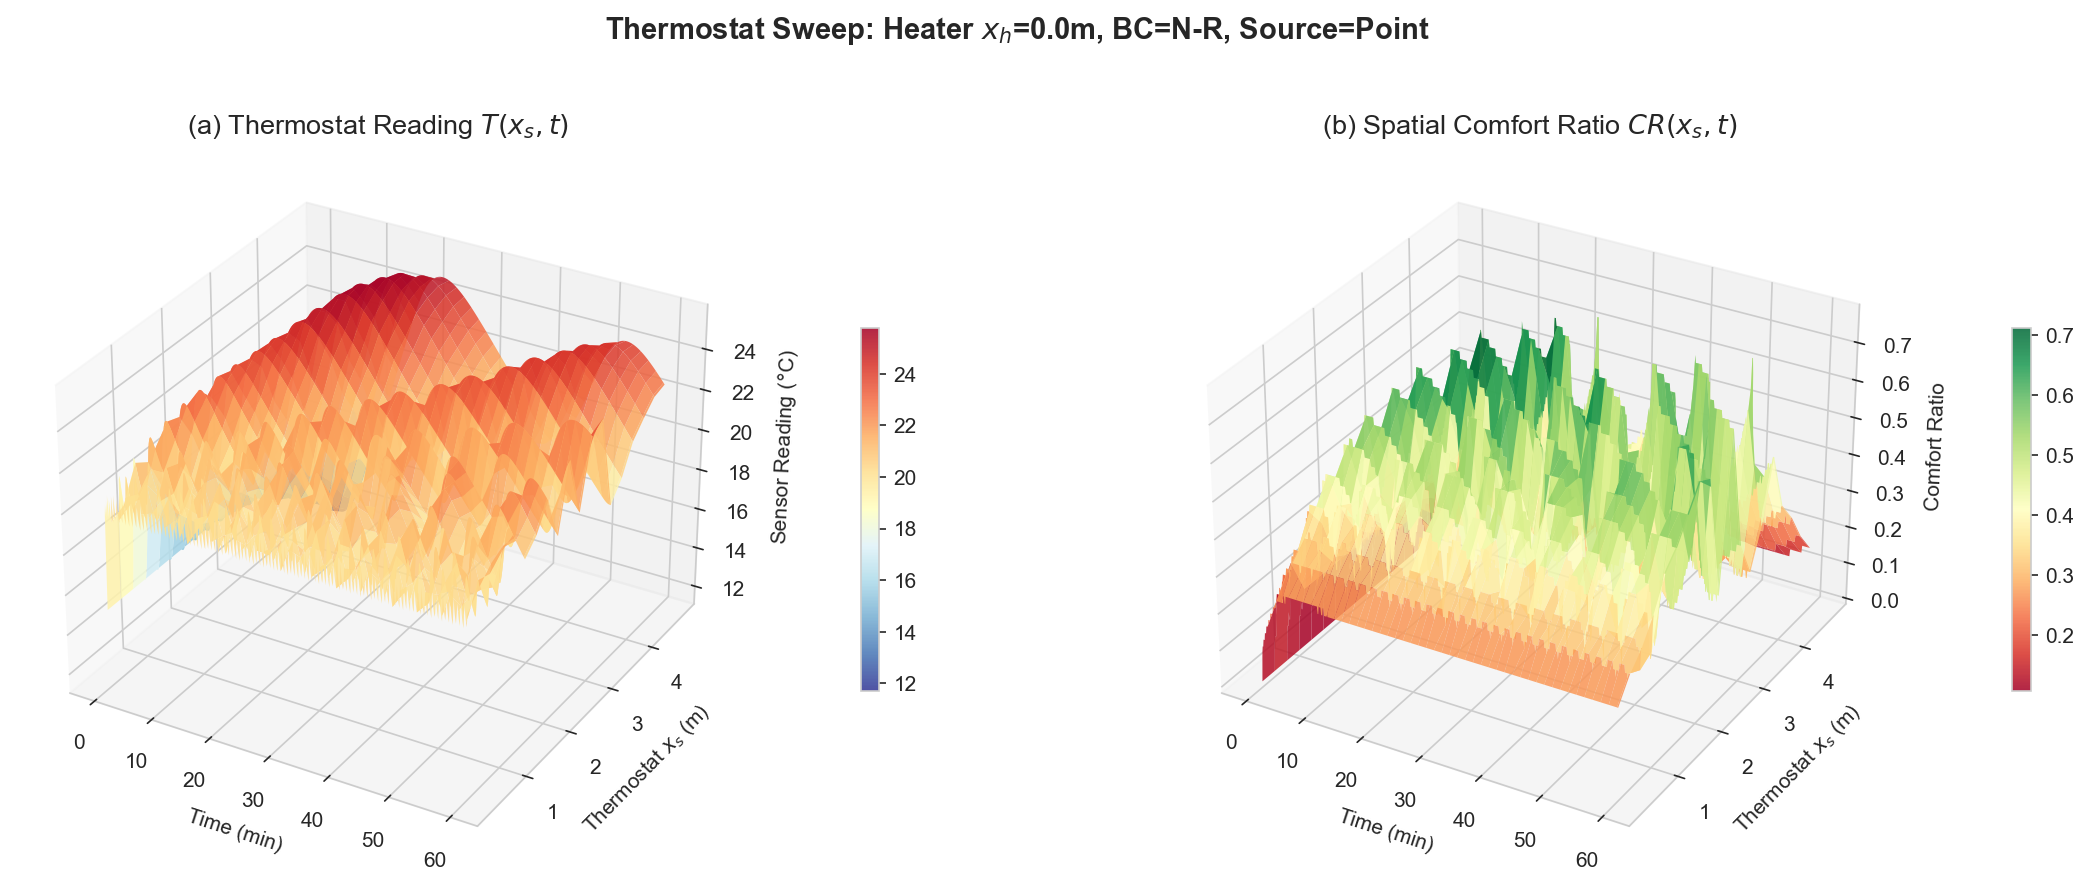

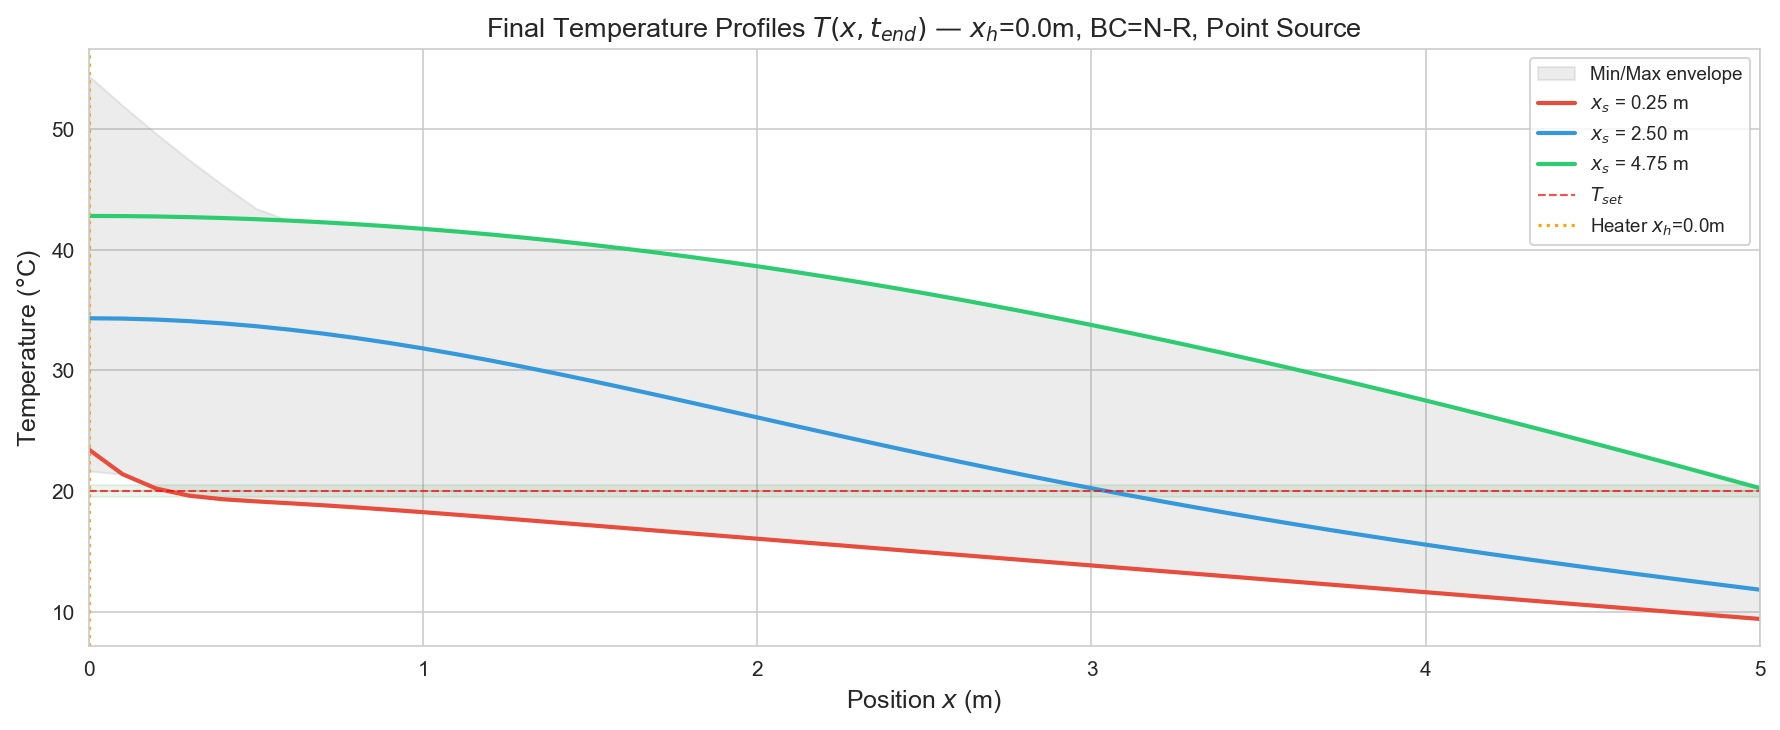

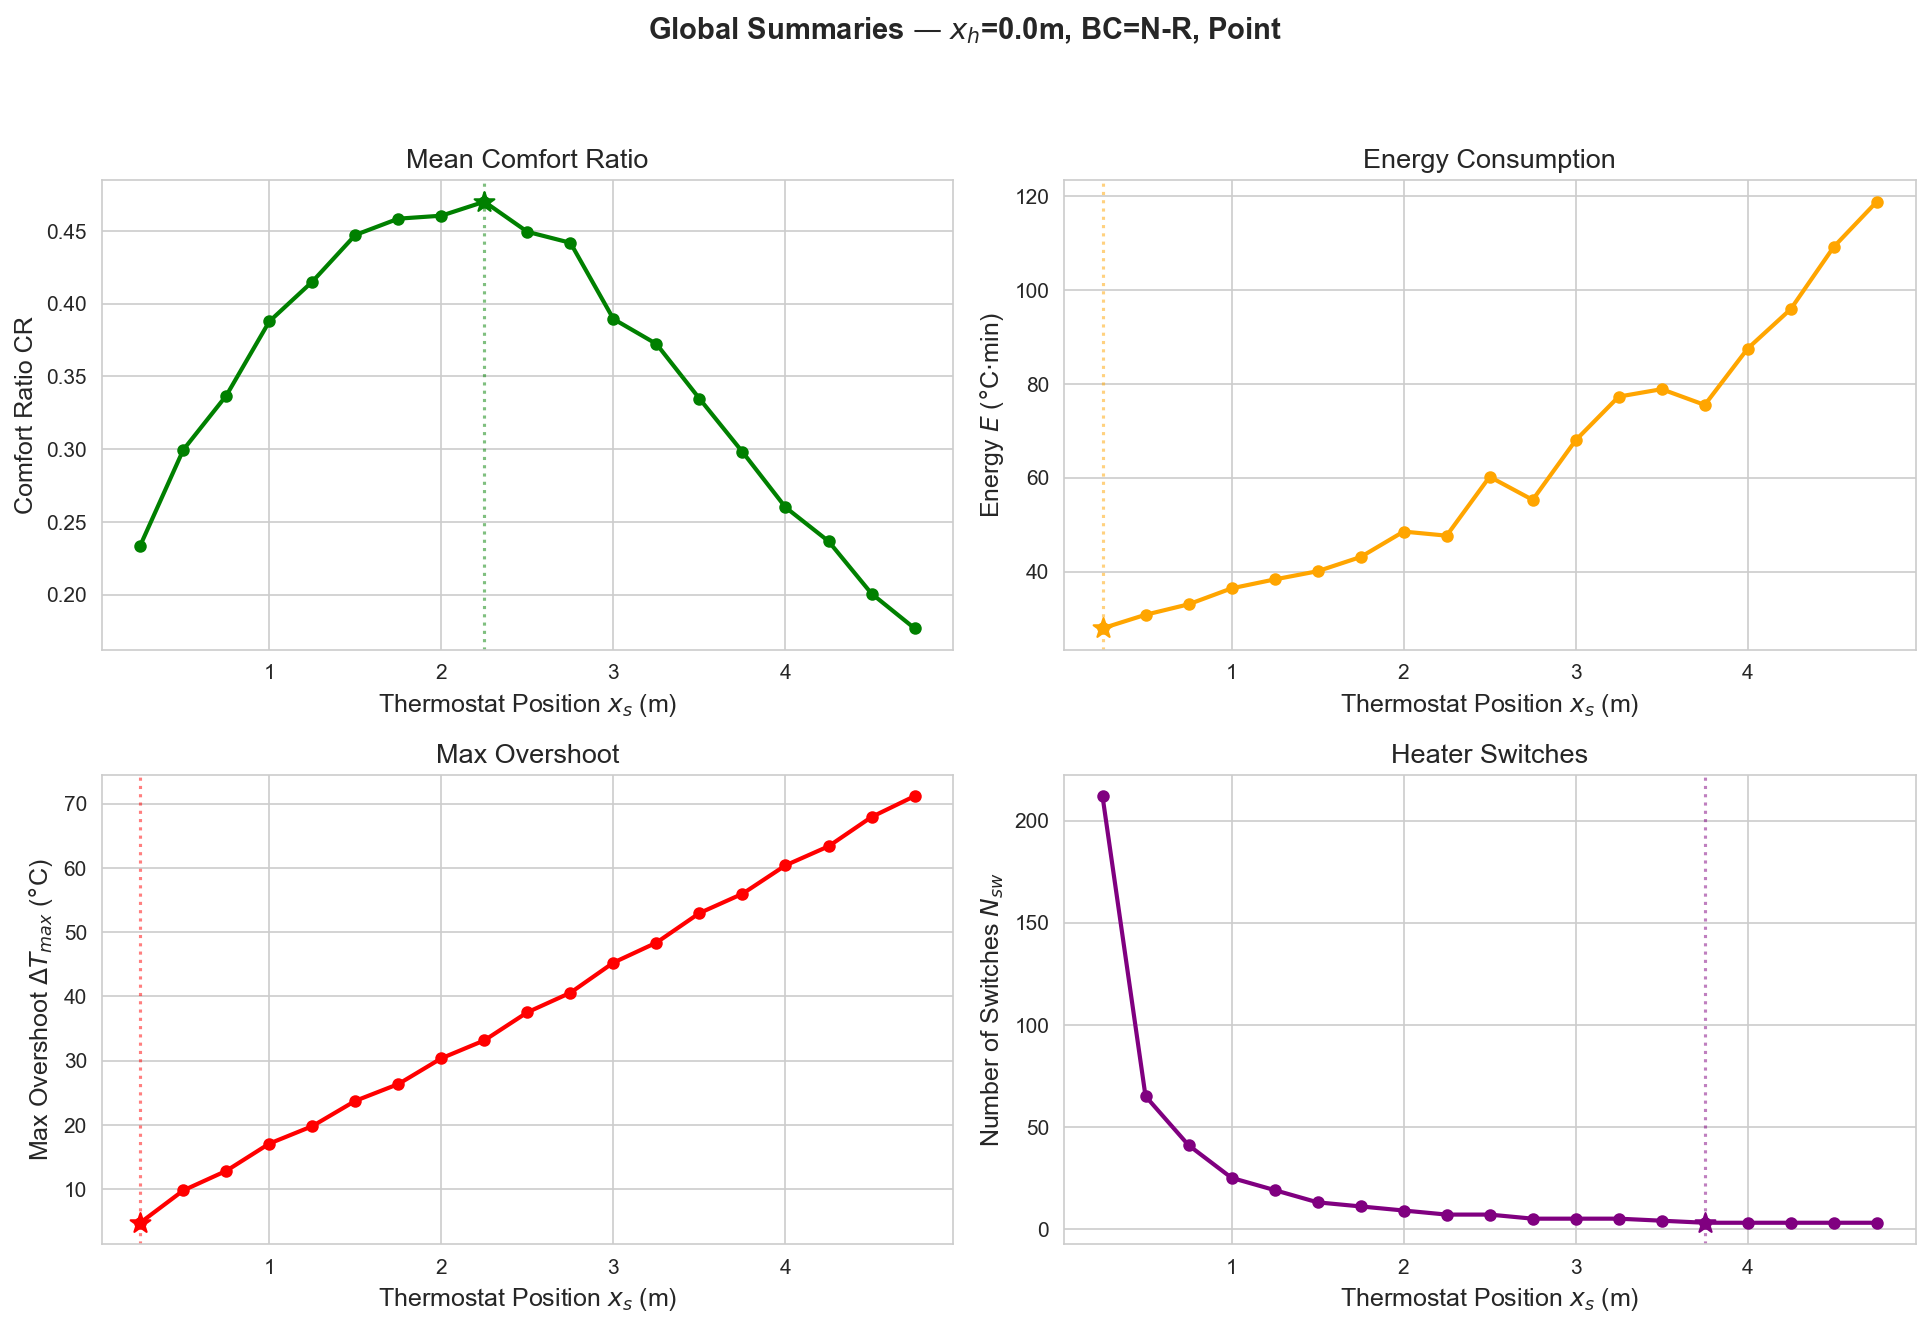

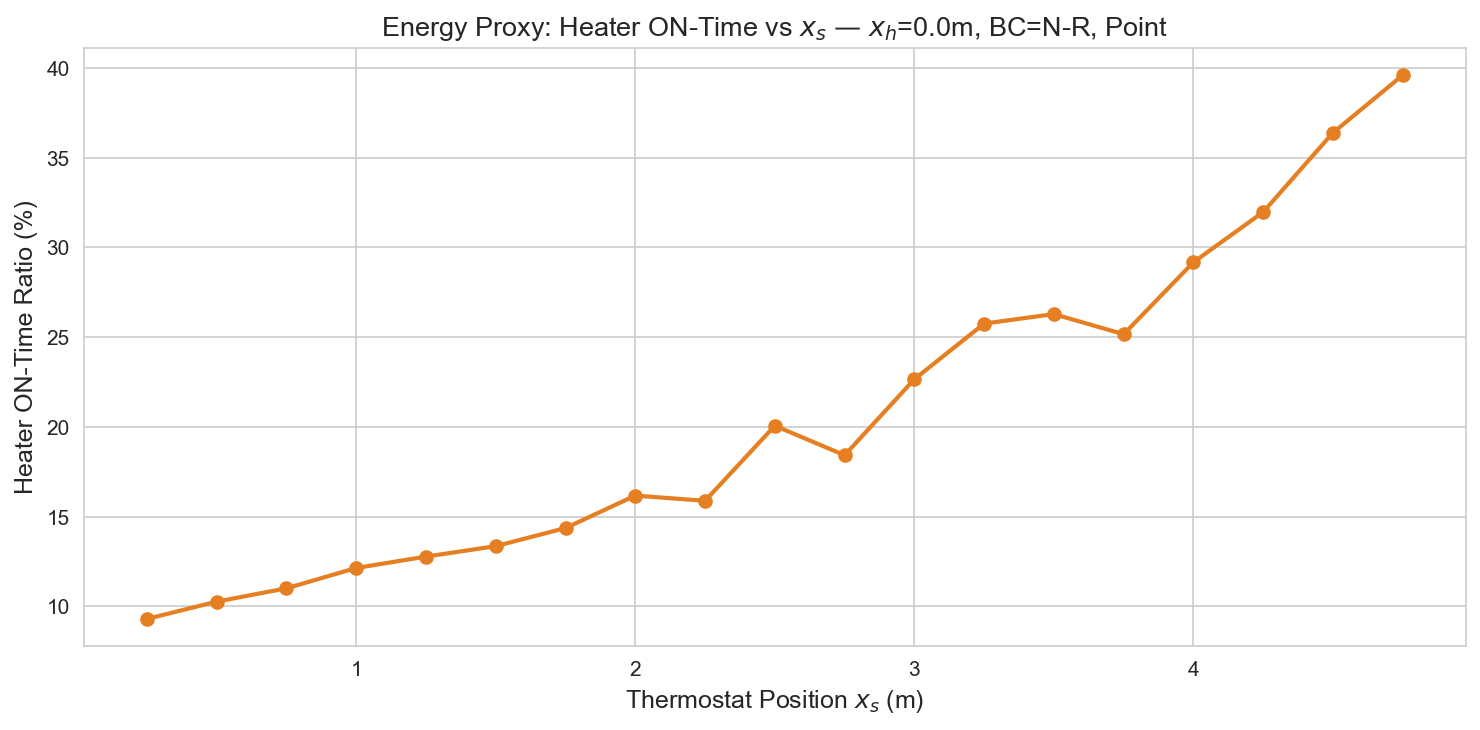

In [7]:
# ============================================================
# 实验 1.1: 加热器 x_h=0, BC=N-R, 点热源
# ============================================================
sweep_1_1 = run_and_plot_all(x_h=0.0, bc_type='NR', source_type='point',
                              label='1.1', prefix='exp1_1')


实验 1.2: x_h=2.5m, BC=NR, source=point
最优恒温器位置: x_s = 2.75 m, J = 0.3634
  x_s= 0.25m | E=   32.2 RMSE=5.134 ΔTmax=28.63 CR=0.579 t_s= 60.0 Nsw=   5 | J=0.5055
  x_s= 0.50m | E=   28.9 RMSE=4.684 ΔTmax=27.44 CR=0.608 t_s= 60.0 Nsw=   5 | J=0.4796
  x_s= 0.75m | E=   26.5 RMSE=4.315 ΔTmax=26.08 CR=0.613 t_s= 60.0 Nsw=   6 | J=0.4606
  x_s= 1.00m | E=   25.0 RMSE=3.835 ΔTmax=23.24 CR=0.634 t_s= 60.0 Nsw=   8 | J=0.4336
  x_s= 1.25m | E=   27.4 RMSE=3.638 ΔTmax=20.93 CR=0.628 t_s= 60.0 Nsw=  11 | J=0.4278
  x_s= 1.50m | E=   25.7 RMSE=3.440 ΔTmax=17.03 CR=0.625 t_s= 60.0 Nsw=  17 | J=0.4049
  x_s= 1.75m | E=   24.5 RMSE=3.377 ΔTmax=14.26 CR=0.625 t_s= 60.0 Nsw=  24 | J=0.3899
  x_s= 2.00m | E=   24.1 RMSE=3.383 ΔTmax= 9.78 CR=0.619 t_s= 60.0 Nsw=  51 | J=0.3739
  x_s= 2.25m | E=   23.5 RMSE=3.439 ΔTmax= 6.52 CR=0.607 t_s= 60.0 Nsw= 103 | J=0.3662
  x_s= 2.50m | E=   22.5 RMSE=3.628 ΔTmax= 0.99 CR=0.575 t_s= 60.0 Nsw=1749 | J=0.4900
  x_s= 2.75m | E=   24.6 RMSE=3.294 ΔTmax= 4.75 CR=0.625 

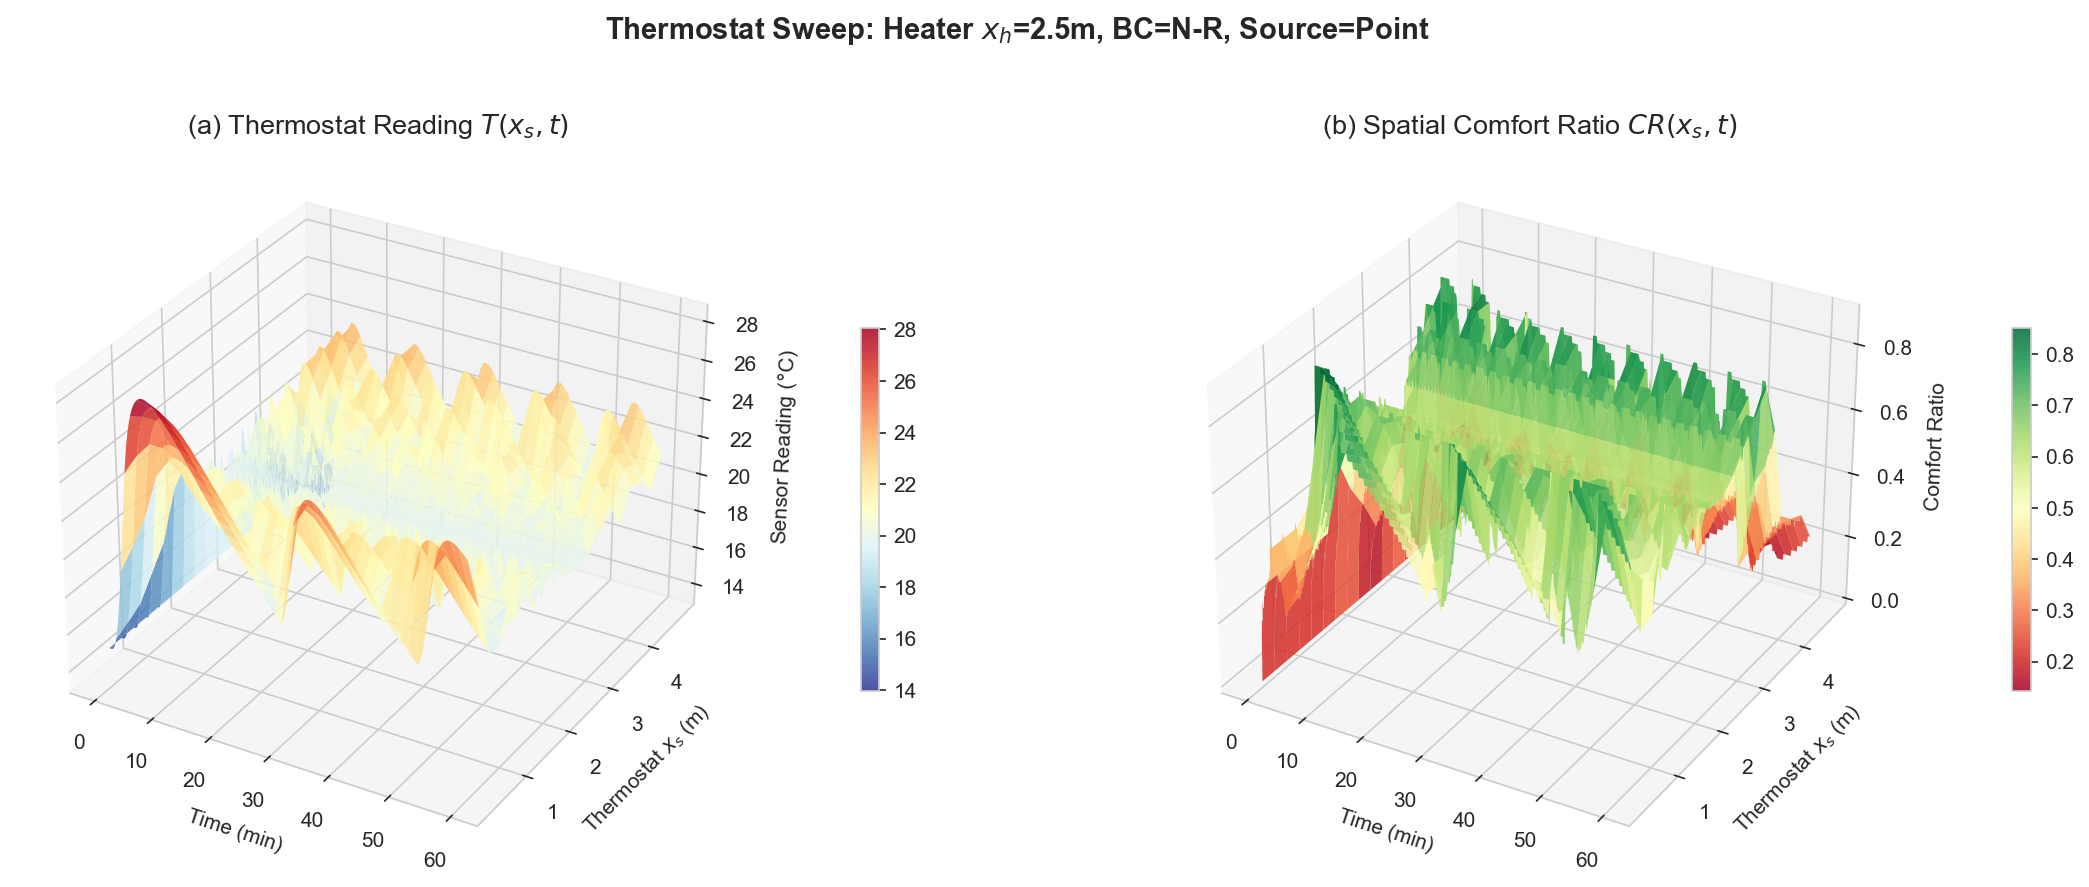

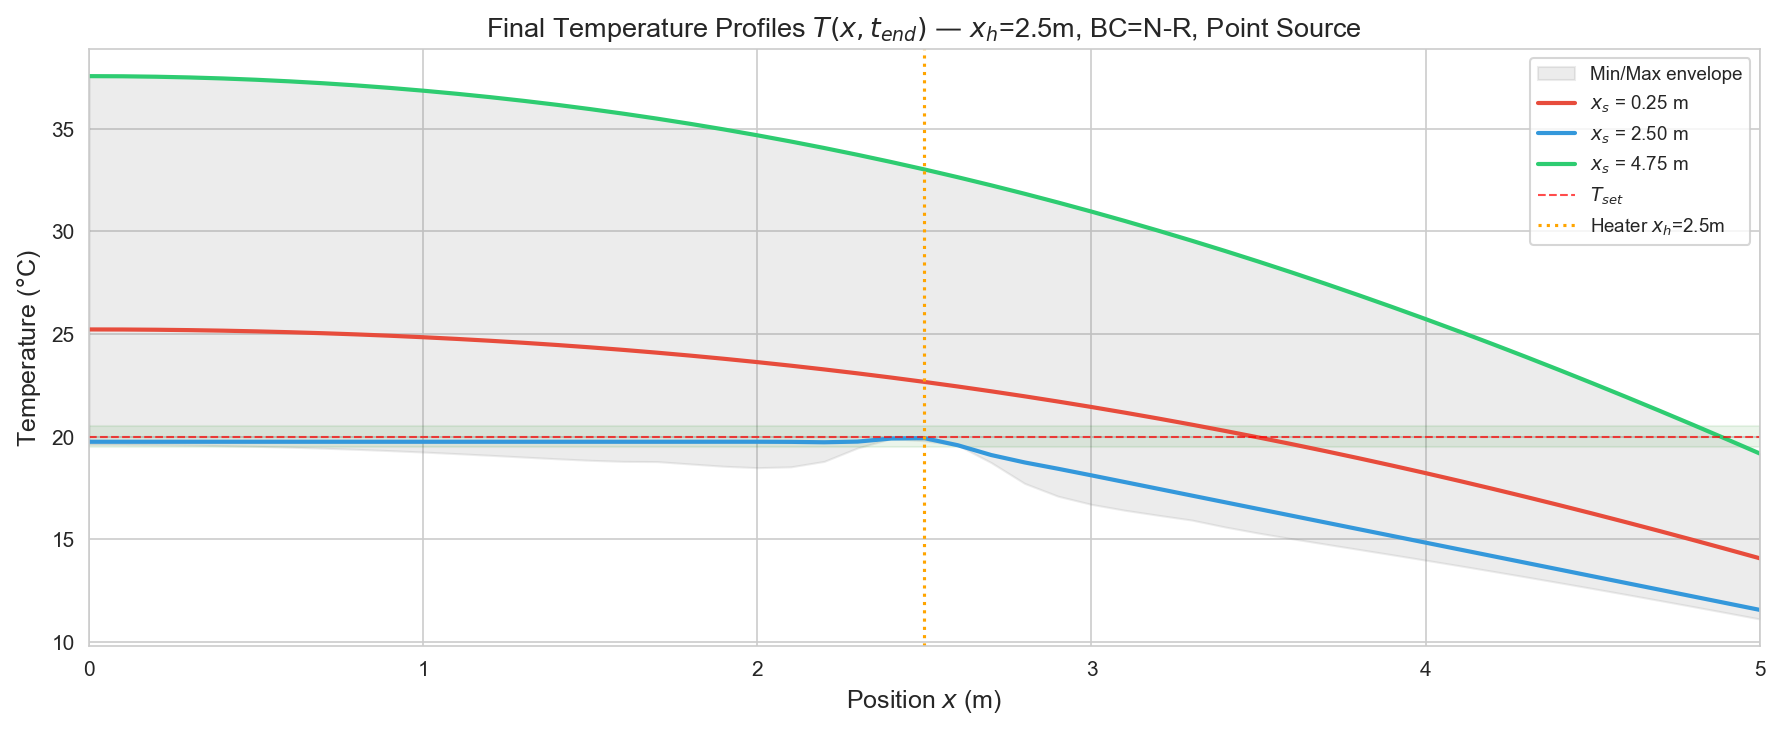

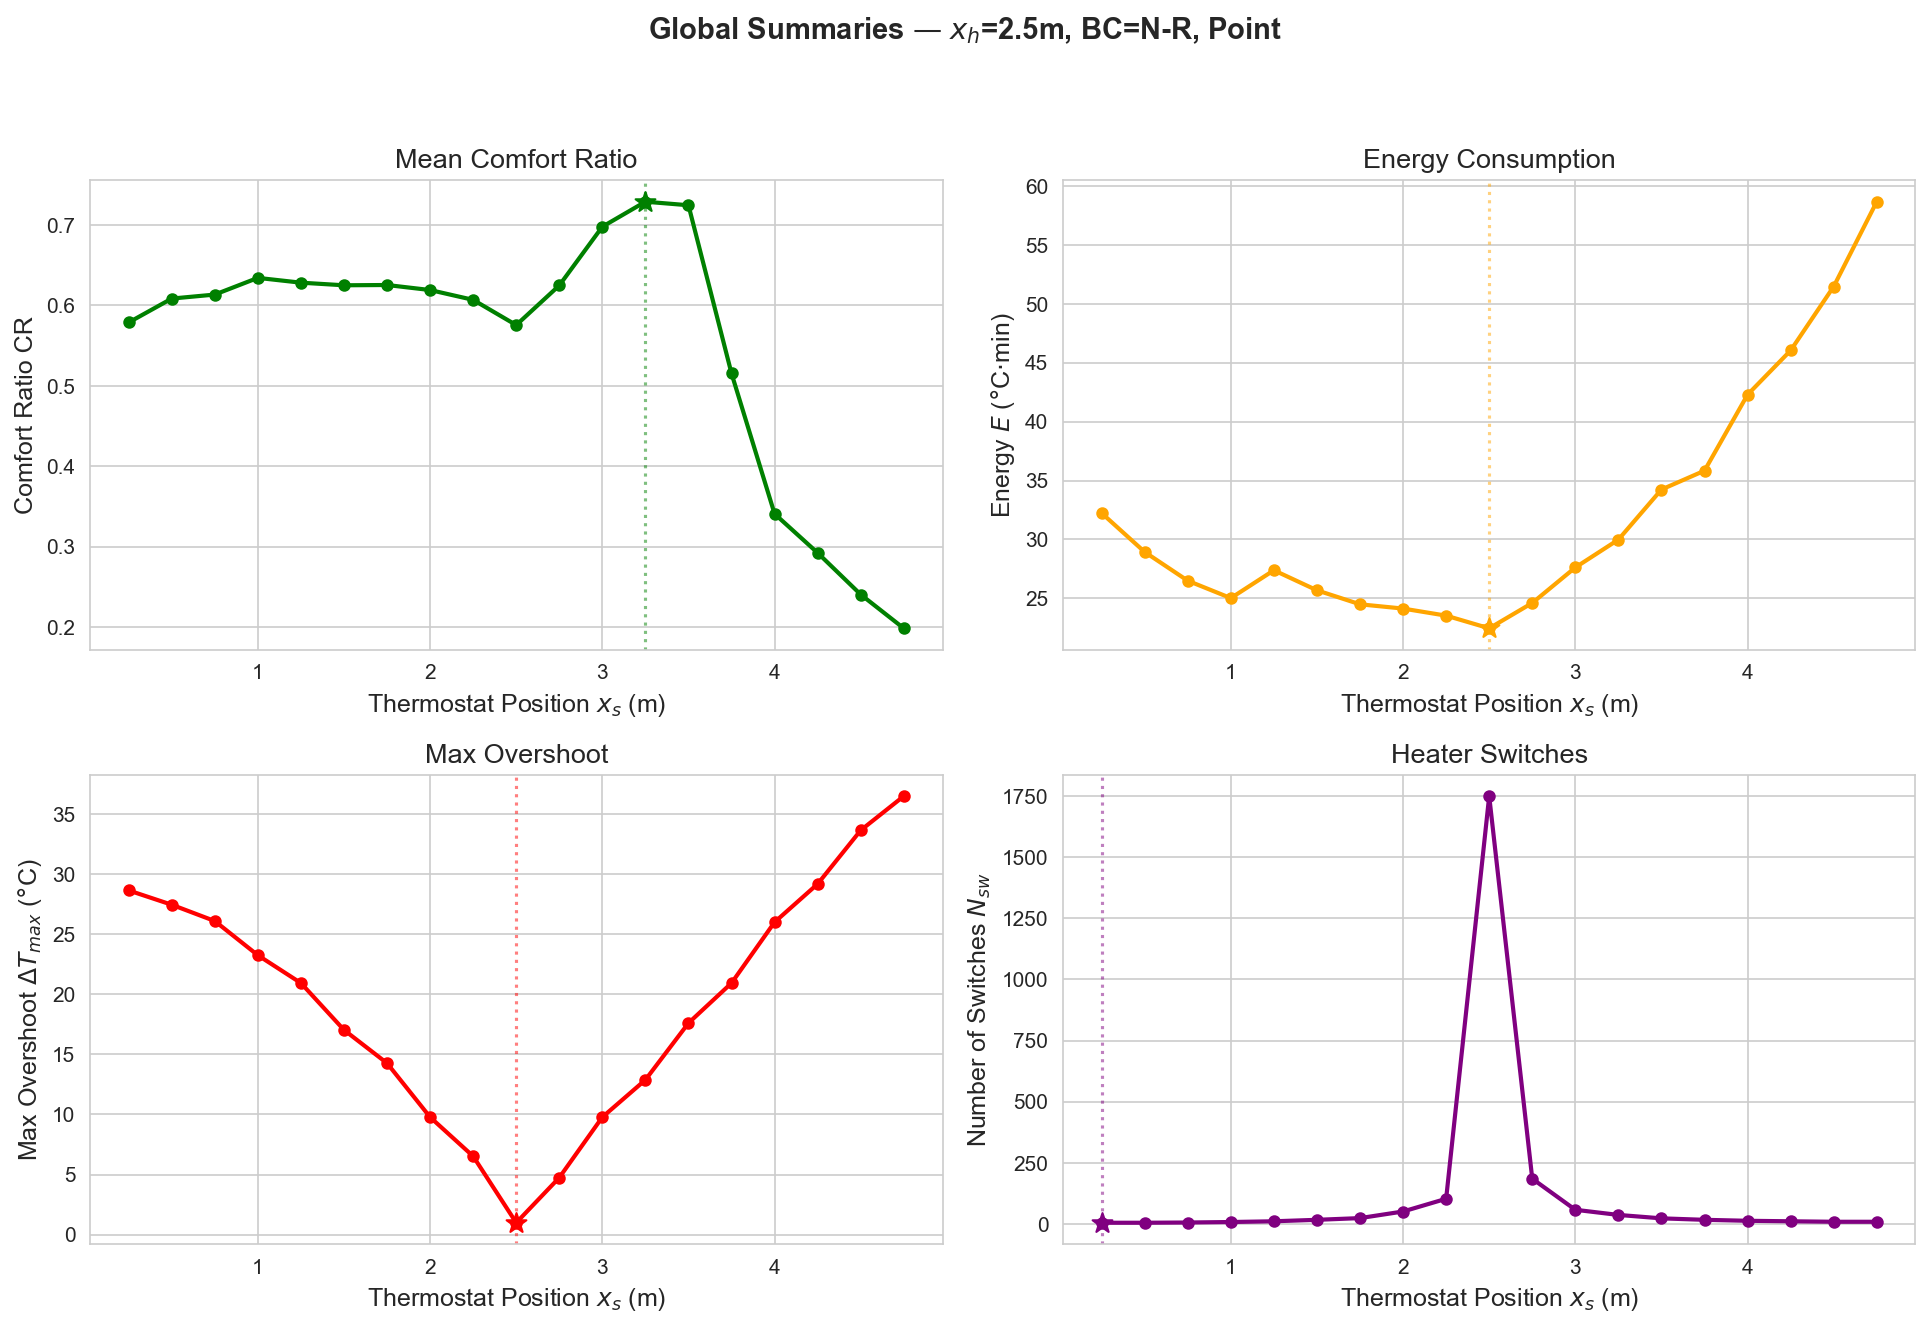

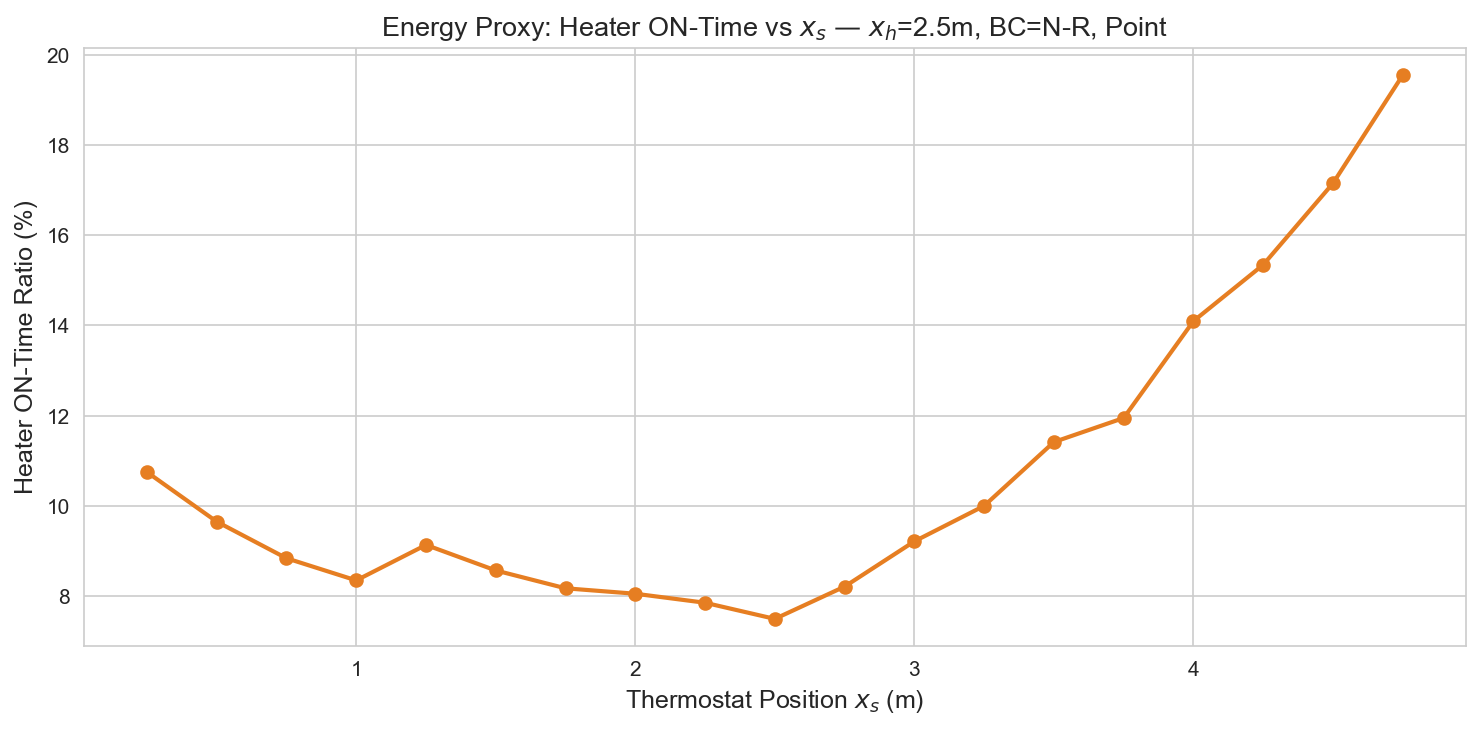

In [8]:
# ============================================================
# 实验 1.2: 加热器 x_h=L/2, BC=N-R, 点热源
# ============================================================
sweep_1_2 = run_and_plot_all(x_h=L/2, bc_type='NR', source_type='point',
                              label='1.2', prefix='exp1_2')


实验 1.3: x_h=2.5m, BC=RR, source=point
最优恒温器位置: x_s = 3.25 m, J = 0.4445
  x_s= 0.25m | E=   98.1 RMSE=10.839 ΔTmax=36.94 CR=0.368 t_s= 60.0 Nsw=  13 | J=0.7955
  x_s= 0.50m | E=   90.3 RMSE=8.297 ΔTmax=32.99 CR=0.514 t_s= 60.0 Nsw=  14 | J=0.6871
  x_s= 0.75m | E=   77.4 RMSE=6.821 ΔTmax=30.23 CR=0.583 t_s= 60.0 Nsw=  16 | J=0.6117
  x_s= 1.00m | E=   72.1 RMSE=5.122 ΔTmax=25.73 CR=0.610 t_s= 60.0 Nsw=  21 | J=0.5424
  x_s= 1.25m | E=   64.0 RMSE=4.299 ΔTmax=22.49 CR=0.606 t_s= 60.0 Nsw=  25 | J=0.4987
  x_s= 1.50m | E=   57.3 RMSE=3.677 ΔTmax=17.55 CR=0.568 t_s= 60.0 Nsw=  37 | J=0.4603
  x_s= 1.75m | E=   53.6 RMSE=3.627 ΔTmax=14.45 CR=0.520 t_s= 60.0 Nsw=  51 | J=0.4486
  x_s= 2.00m | E=   48.4 RMSE=3.934 ΔTmax= 9.78 CR=0.429 t_s= 60.0 Nsw=  97 | J=0.4446
  x_s= 2.25m | E=   45.0 RMSE=4.303 ΔTmax= 6.52 CR=0.352 t_s= 60.0 Nsw= 193 | J=0.4508
  x_s= 2.50m | E=   40.4 RMSE=4.999 ΔTmax= 0.99 CR=0.214 t_s= 60.0 Nsw=3181 | J=0.5990
  x_s= 2.75m | E=   43.6 RMSE=4.505 ΔTmax= 4.75 CR=0.312

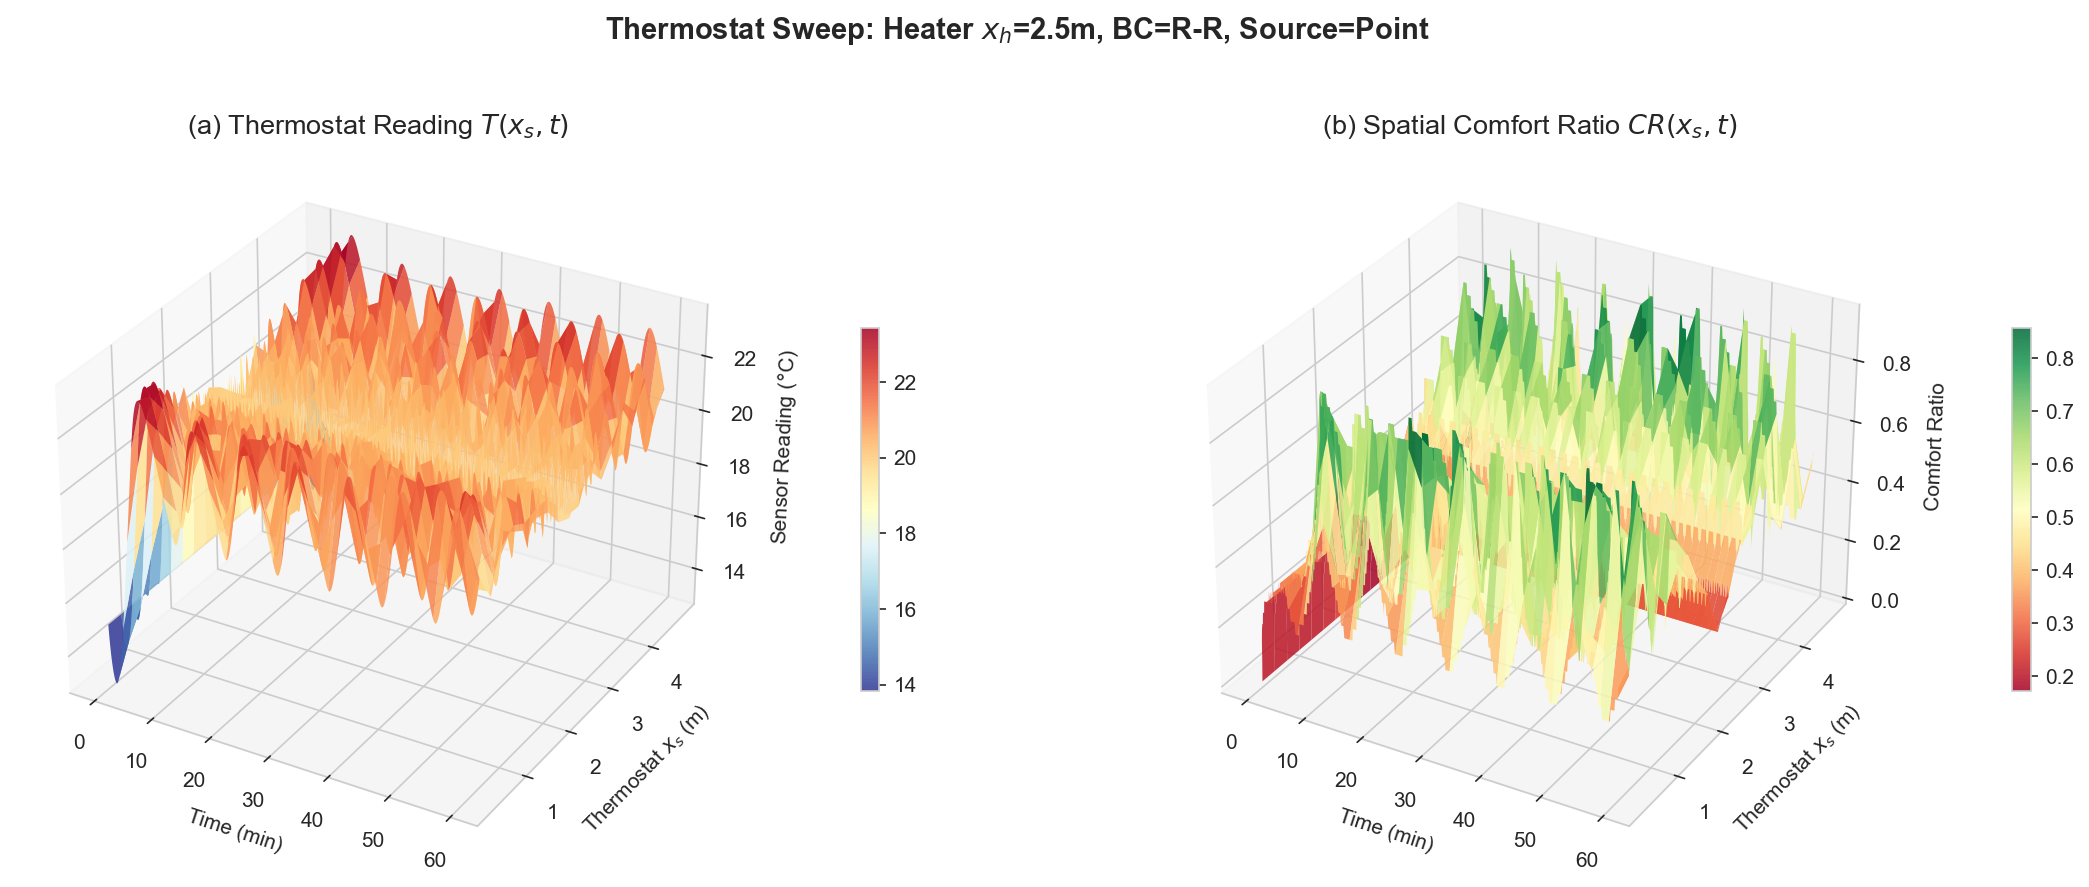

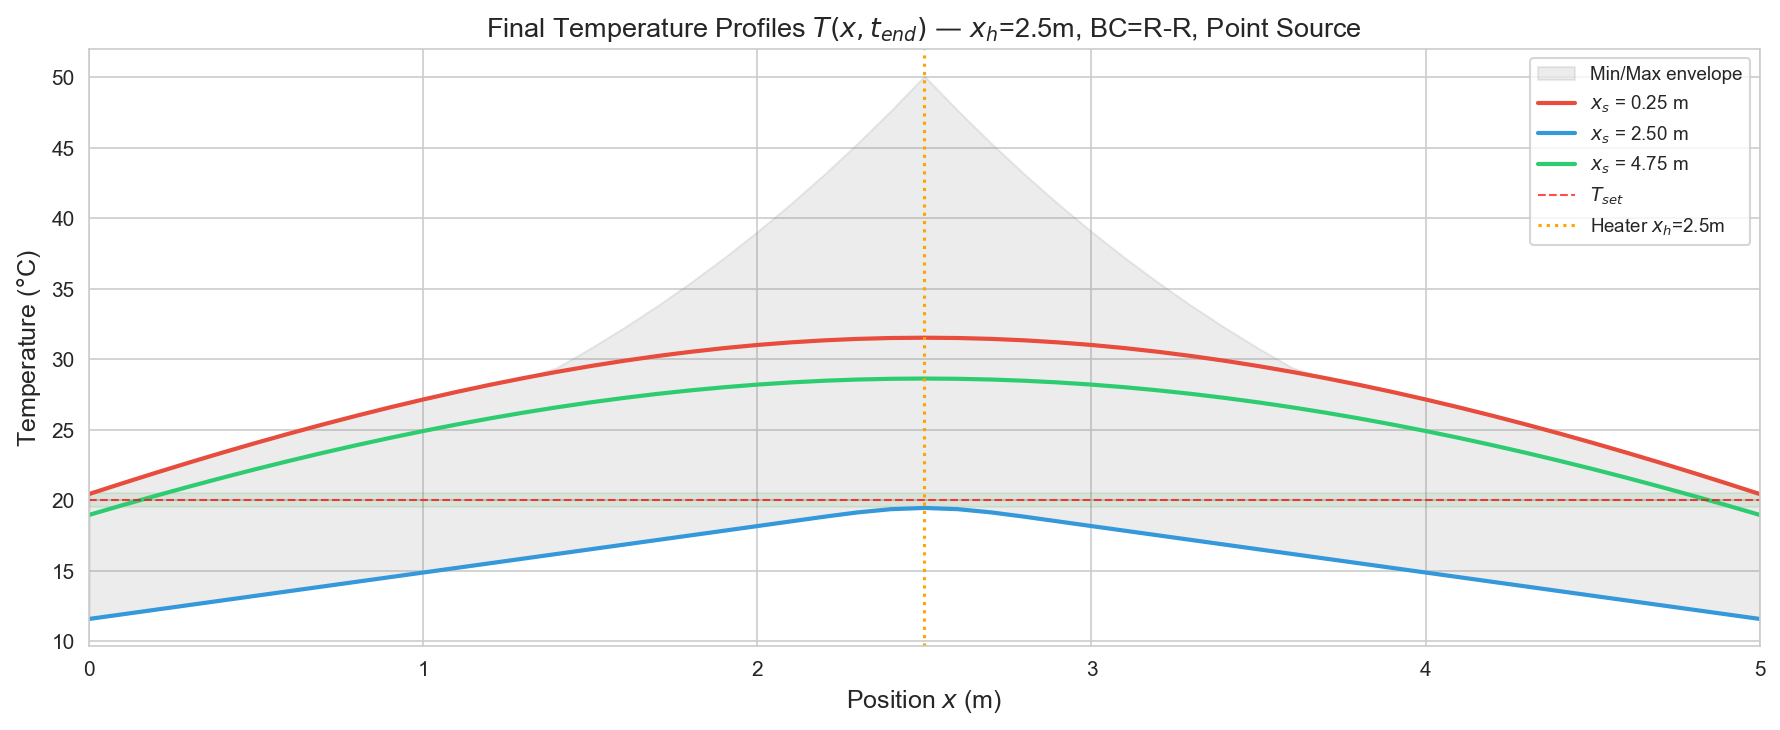

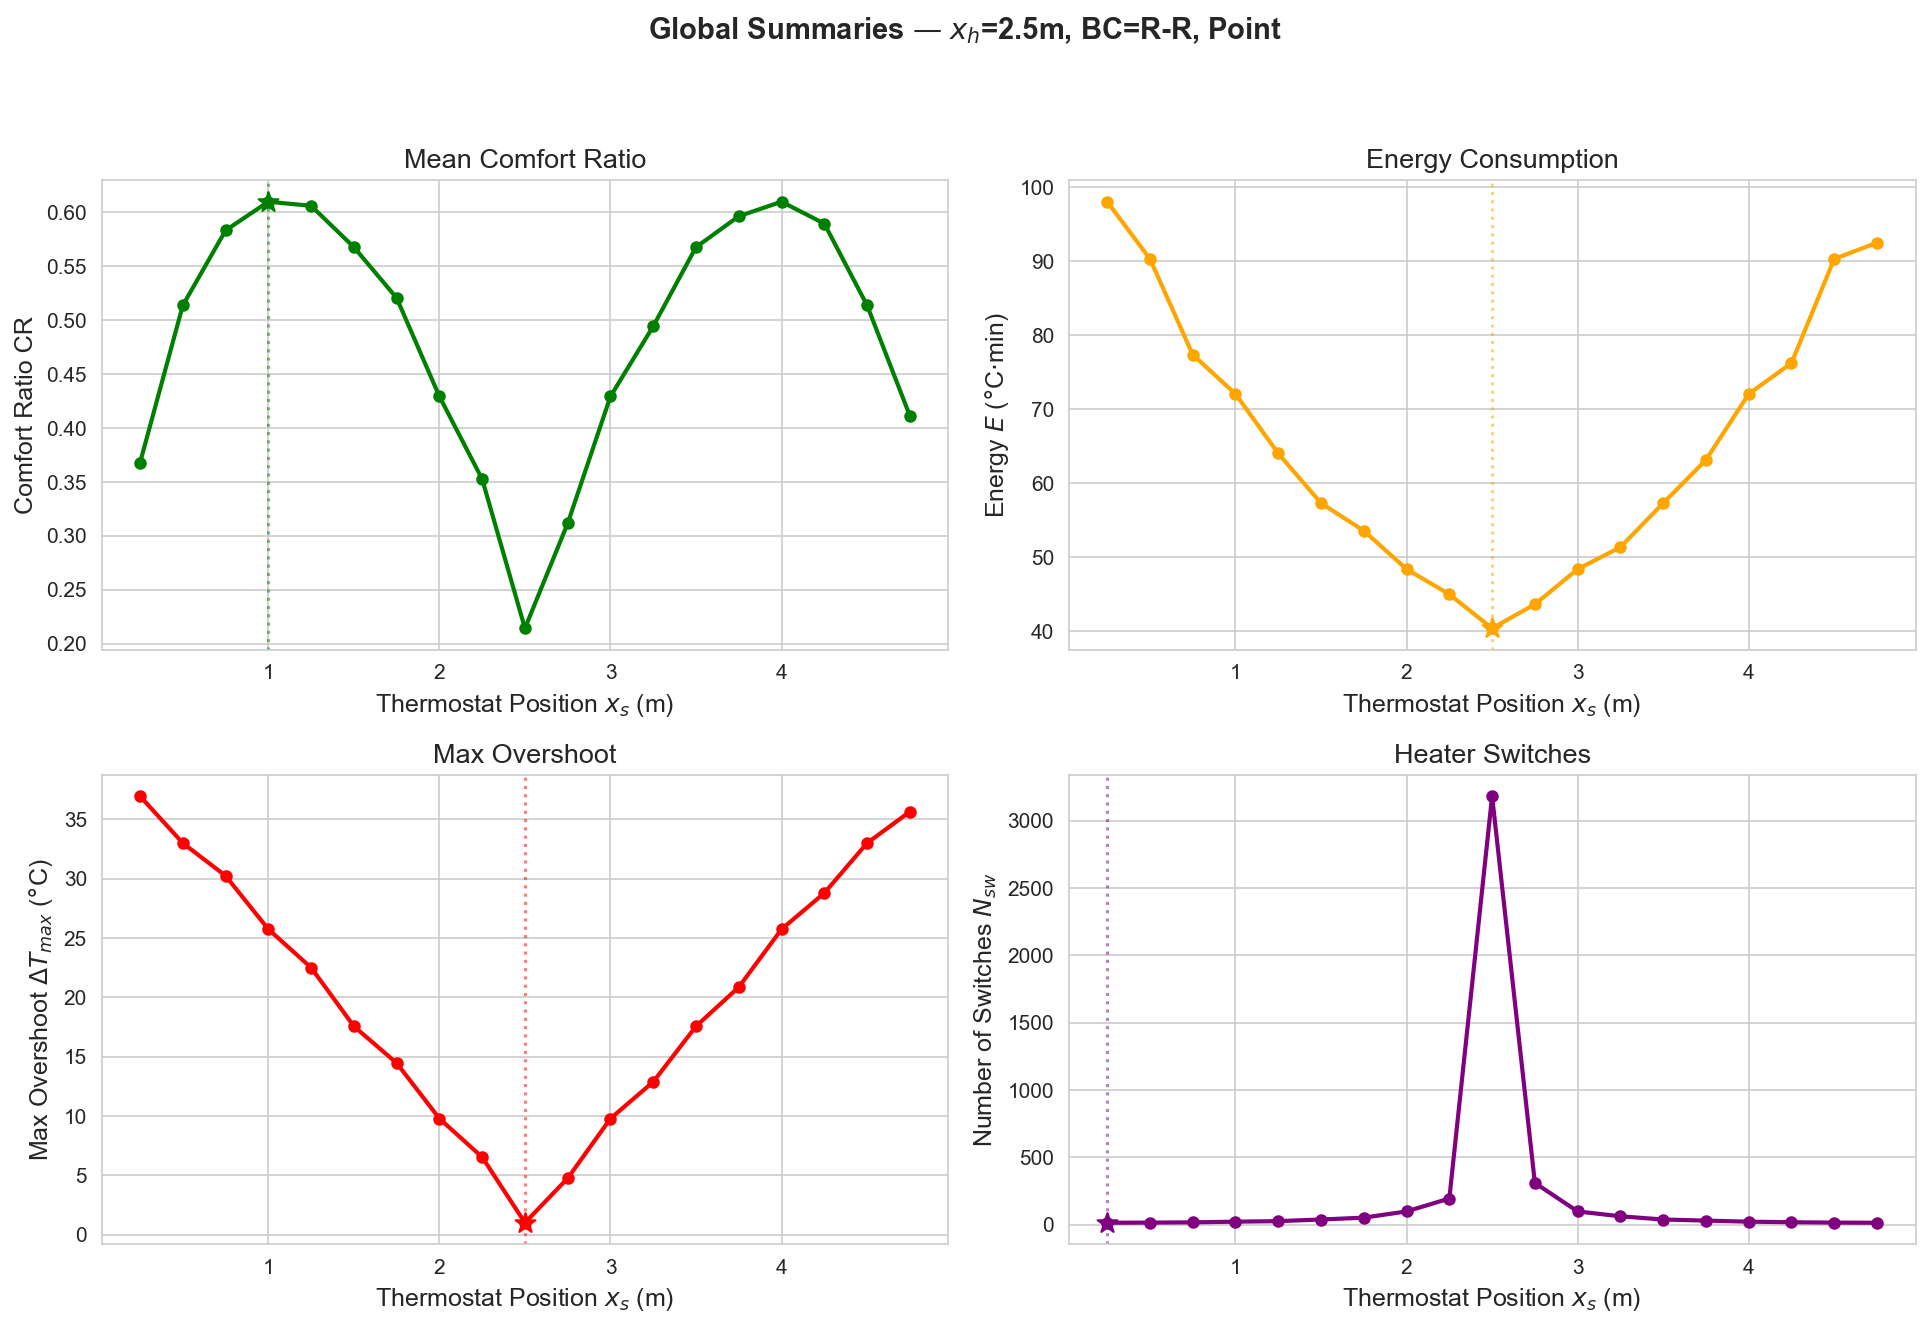

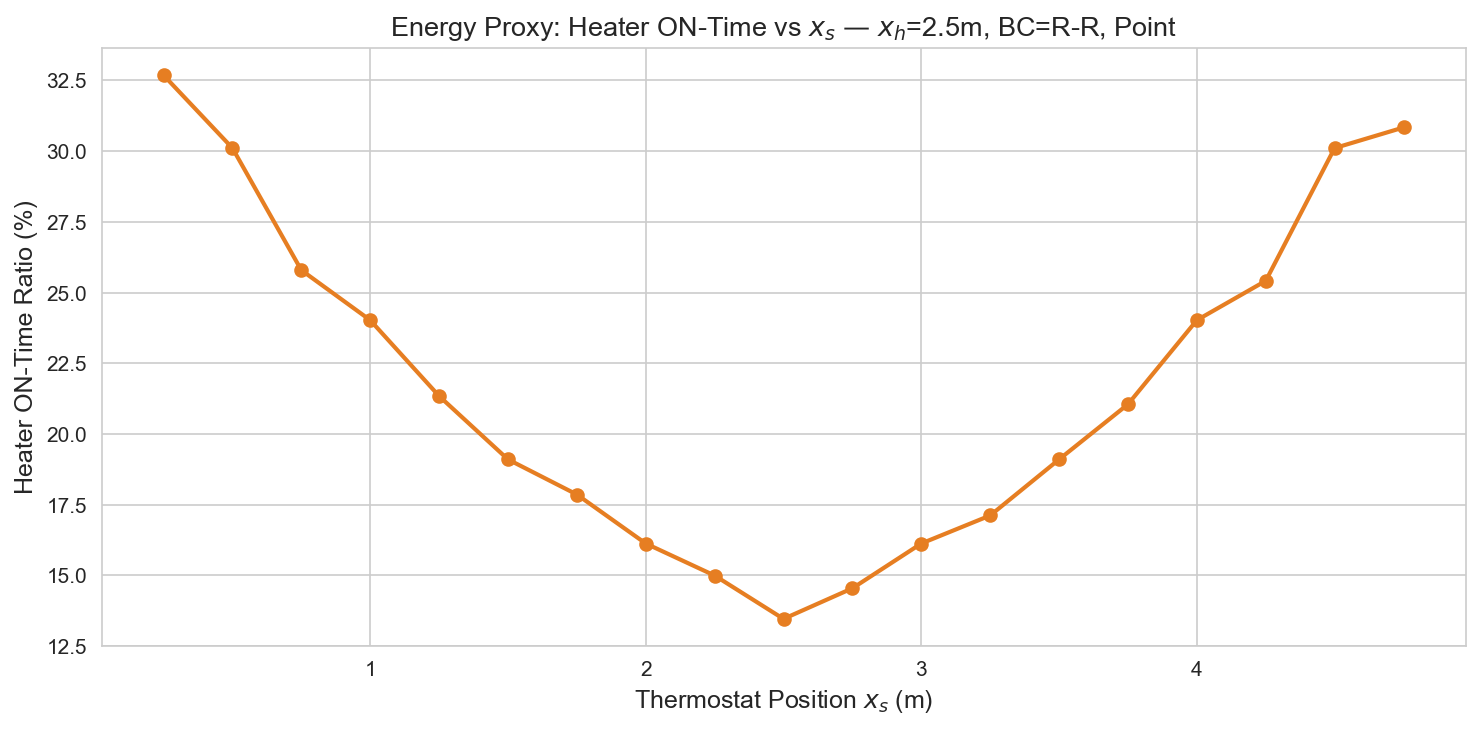

In [9]:
# ============================================================
# 实验 1.3: 加热器 x_h=L/2, BC=R-R, 点热源
# ============================================================
sweep_1_3 = run_and_plot_all(x_h=L/2, bc_type='RR', source_type='point',
                              label='1.3', prefix='exp1_3')

## 实验 1.4：点热源汇总对比

将三组实验的统一代价 $J$ 曲线叠加，对比不同加热器位置和边界条件下的最优恒温器位置。
同时用不同权重方案（平衡型、舒适优先、节能优先）验证结论的鲁棒性。

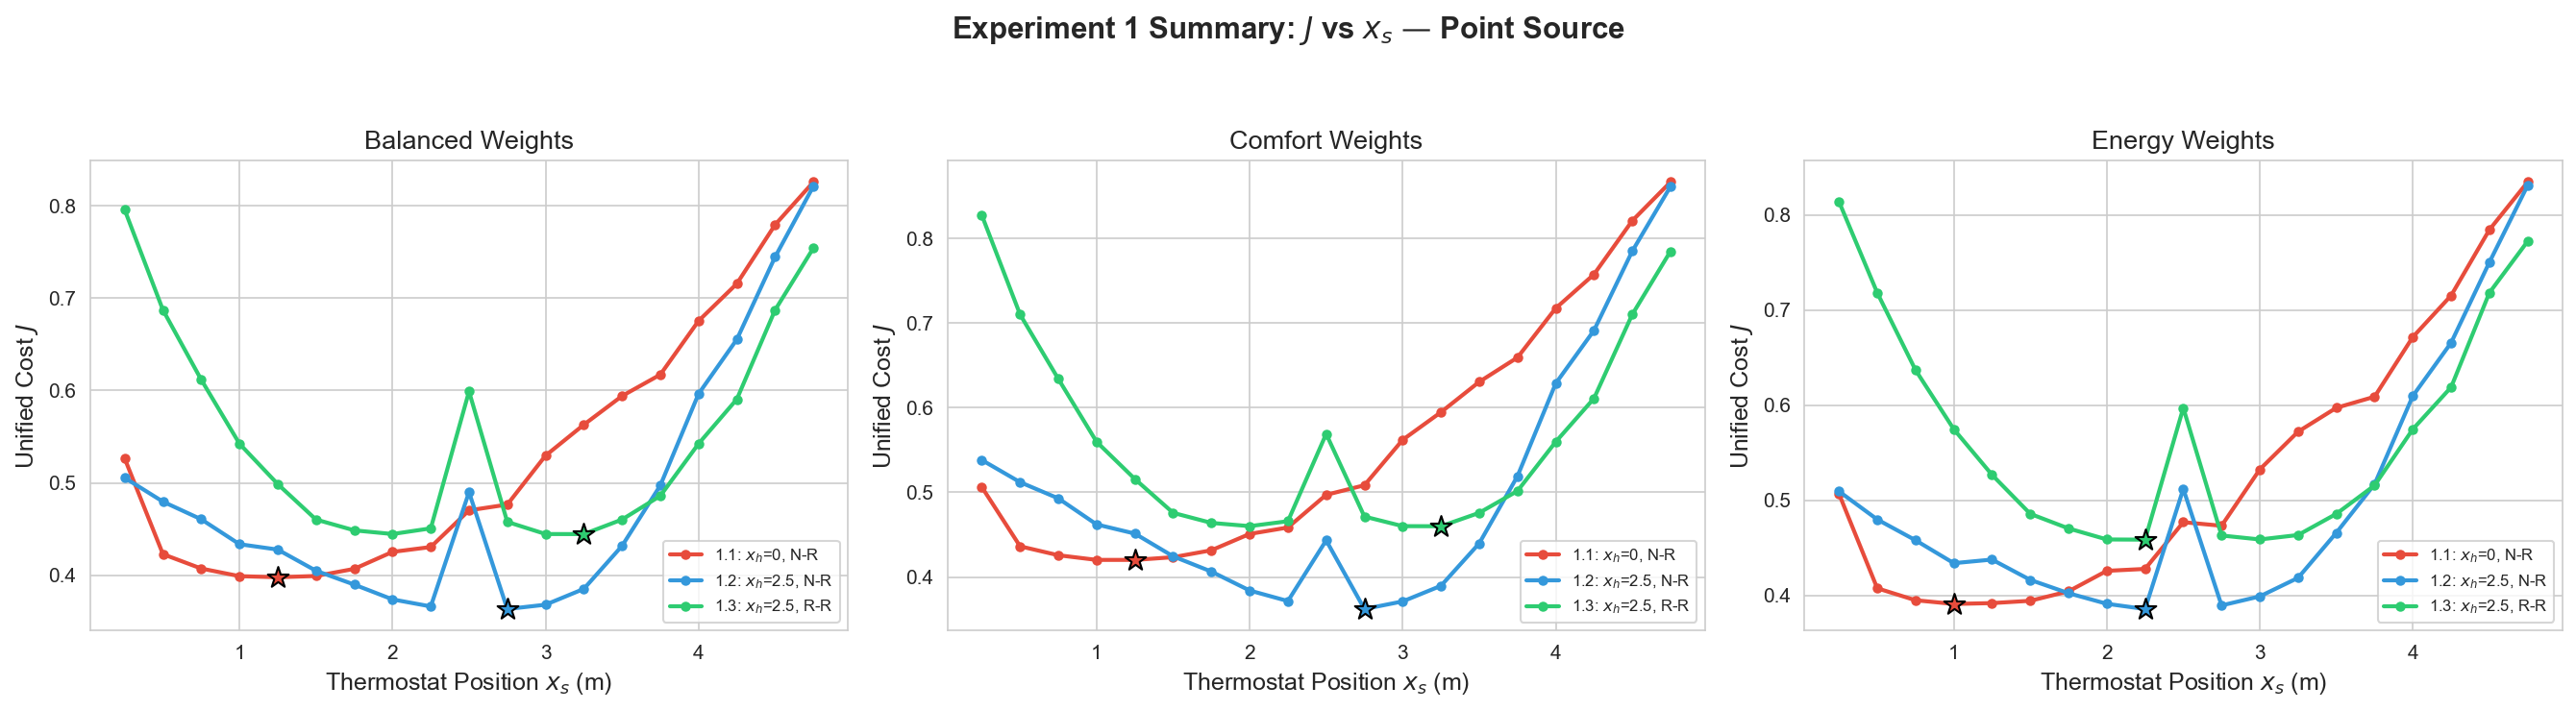


=== 实验一：点热源最优恒温器位置汇总 ===


Config  Best x_s (m)  J (Balanced)  Energy E      RMSE  \
0    1.1: $x_h$=0, N-R          1.25      0.397844   38.3125  5.013126   
1  1.2: $x_h$=2.5, N-R          2.75      0.363433   24.6125  3.294483   
2  1.3: $x_h$=2.5, R-R          3.25      0.444519   51.3375  3.685068   

   Max Overshoot        CR  Settling Time  Switches  Best x_s (Balanced)  \
0      19.783706  0.415188           60.0        19                 1.25   
1       4.746636  0.624664           60.0       185                 2.75   
2      12.870642  0.494266           60.0        61                 3.25   

   Best x_s (Comfort)  J (Comfort)  Best x_s (Energy)  J (Energy)  
0                1.25     0.420378               1.00    0.390876  
1                2.75     0.362441               2.25    0.385535  
2                3.25     0.460091               2.25    0.458471

CSV 已保存: 1D_exp1_point_source.csv


In [10]:
# ============================================================
# 实验 1.4: 点热源汇总对比
# ============================================================

point_sweeps = {
    '1.1: $x_h$=0, N-R': sweep_1_1,
    '1.2: $x_h$=2.5, N-R': sweep_1_2,
    '1.3: $x_h$=2.5, R-R': sweep_1_3,
}

# --- 图: J vs x_s 叠加折线图 ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (wname, w) in zip(axes, WEIGHT_SCHEMES.items()):
    for (label, sw), color in zip(point_sweeps.items(),
                                   ['#e74c3c', '#3498db', '#2ecc71']):
        # 重新计算 J 用当前权重
        J_vals = [compute_unified_cost(m, sw['ref_maxes'], w)
                  for m in sw['metrics']]
        ax.plot(sw['x_s_values'], J_vals, 'o-', color=color,
                linewidth=2, markersize=4, label=label)
        best_i = np.argmin(J_vals)
        ax.scatter([sw['x_s_values'][best_i]], [J_vals[best_i]],
                   s=120, marker='*', color=color, zorder=5, edgecolors='black')
    ax.set_xlabel('Thermostat Position $x_s$ (m)')
    ax.set_ylabel('Unified Cost $J$')
    ax.set_title(f'{wname} Weights')
    ax.legend(fontsize=8)

fig.suptitle('Experiment 1 Summary: $J$ vs $x_s$ — Point Source',
             fontsize=15, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig(f'{OUT_DIR}/1D_exp1_summary_J.png', dpi=300, bbox_inches='tight')
plt.show()

# --- 最优恒温器位置对比表 ---
summary_rows = []
for label, sw in point_sweeps.items():
    best_idx = np.argmin(sw['J_values'])
    m = sw['metrics'][best_idx]
    row = {
        'Config': label,
        'Best x_s (m)': sw['x_s_values'][best_idx],
        'J (Balanced)': sw['J_values'][best_idx],
        'Energy E': m['E'],
        'RMSE': m['RMSE'],
        'Max Overshoot': m['DeltaT_max'],
        'CR': m['CR'],
        'Settling Time': m['t_s'],
        'Switches': m['N_sw'],
    }
    # 其他权重
    for wname, w in WEIGHT_SCHEMES.items():
        J_w = [compute_unified_cost(mi, sw['ref_maxes'], w) for mi in sw['metrics']]
        best_w = np.argmin(J_w)
        row[f'Best x_s ({wname})'] = sw['x_s_values'][best_w]
        row[f'J ({wname})'] = J_w[best_w]
    summary_rows.append(row)

df_summary_1 = pd.DataFrame(summary_rows)
print('\n=== 实验一：点热源最优恒温器位置汇总 ===')
display(df_summary_1)

# 输出 CSV
all_rows_1 = []
for label, sw in point_sweeps.items():
    for i, (xs, m, J) in enumerate(zip(sw['x_s_values'], sw['metrics'], sw['J_values'])):
        row = {'Config': label, 'x_s': xs, **m, 'J_Balanced': J}
        for wname, w in WEIGHT_SCHEMES.items():
            row[f'J_{wname}'] = compute_unified_cost(m, sw['ref_maxes'], w)
        all_rows_1.append(row)

df_all_1 = pd.DataFrame(all_rows_1)
df_all_1.to_csv(f'{OUT_DIR}/1D_exp1_point_source.csv', index=False)
print('CSV 已保存: 1D_exp1_point_source.csv')

---

# 实验二：高斯热源 — 恒温器位置扫描与全枚举

用高斯热源（$\sigma=0.5$m）替代点热源，重复实验一的三组配置。

**核心问题**：高斯热源（分布式加热）是否改变最优恒温器位置？性能提升多少？


实验 2.1: x_h=0.0m, BC=NR, source=gaussian
最优恒温器位置: x_s = 1.25 m, J = 0.3571
  x_s= 0.25m | E=   14.4 RMSE=5.686 ΔTmax= 0.93 CR=0.259 t_s= 60.0 Nsw= 181 | J=0.4881
  x_s= 0.50m | E=   14.9 RMSE=5.534 ΔTmax= 3.00 CR=0.293 t_s= 60.0 Nsw= 123 | J=0.4378
  x_s= 0.75m | E=   15.6 RMSE=5.370 ΔTmax= 5.46 CR=0.323 t_s= 60.0 Nsw=  81 | J=0.4022
  x_s= 1.00m | E=   17.0 RMSE=5.072 ΔTmax=10.88 CR=0.383 t_s= 60.0 Nsw=  39 | J=0.3667
  x_s= 1.25m | E=   18.6 RMSE=4.900 ΔTmax=15.09 CR=0.423 t_s= 60.0 Nsw=  25 | J=0.3571 ★
  x_s= 1.50m | E=   21.5 RMSE=4.867 ΔTmax=21.79 CR=0.460 t_s= 60.0 Nsw=  15 | J=0.3587
  x_s= 1.75m | E=   22.6 RMSE=5.072 ΔTmax=26.27 CR=0.475 t_s= 60.0 Nsw=  11 | J=0.3637
  x_s= 2.00m | E=   24.7 RMSE=5.632 ΔTmax=32.98 CR=0.485 t_s= 60.0 Nsw=   8 | J=0.3786
  x_s= 2.25m | E=   28.1 RMSE=6.509 ΔTmax=37.48 CR=0.462 t_s= 60.0 Nsw=   7 | J=0.4021
  x_s= 2.50m | E=   29.2 RMSE=7.816 ΔTmax=44.54 CR=0.442 t_s= 60.0 Nsw=   5 | J=0.4268
  x_s= 2.75m | E=   34.3 RMSE=9.209 ΔTmax=49.45 CR=0

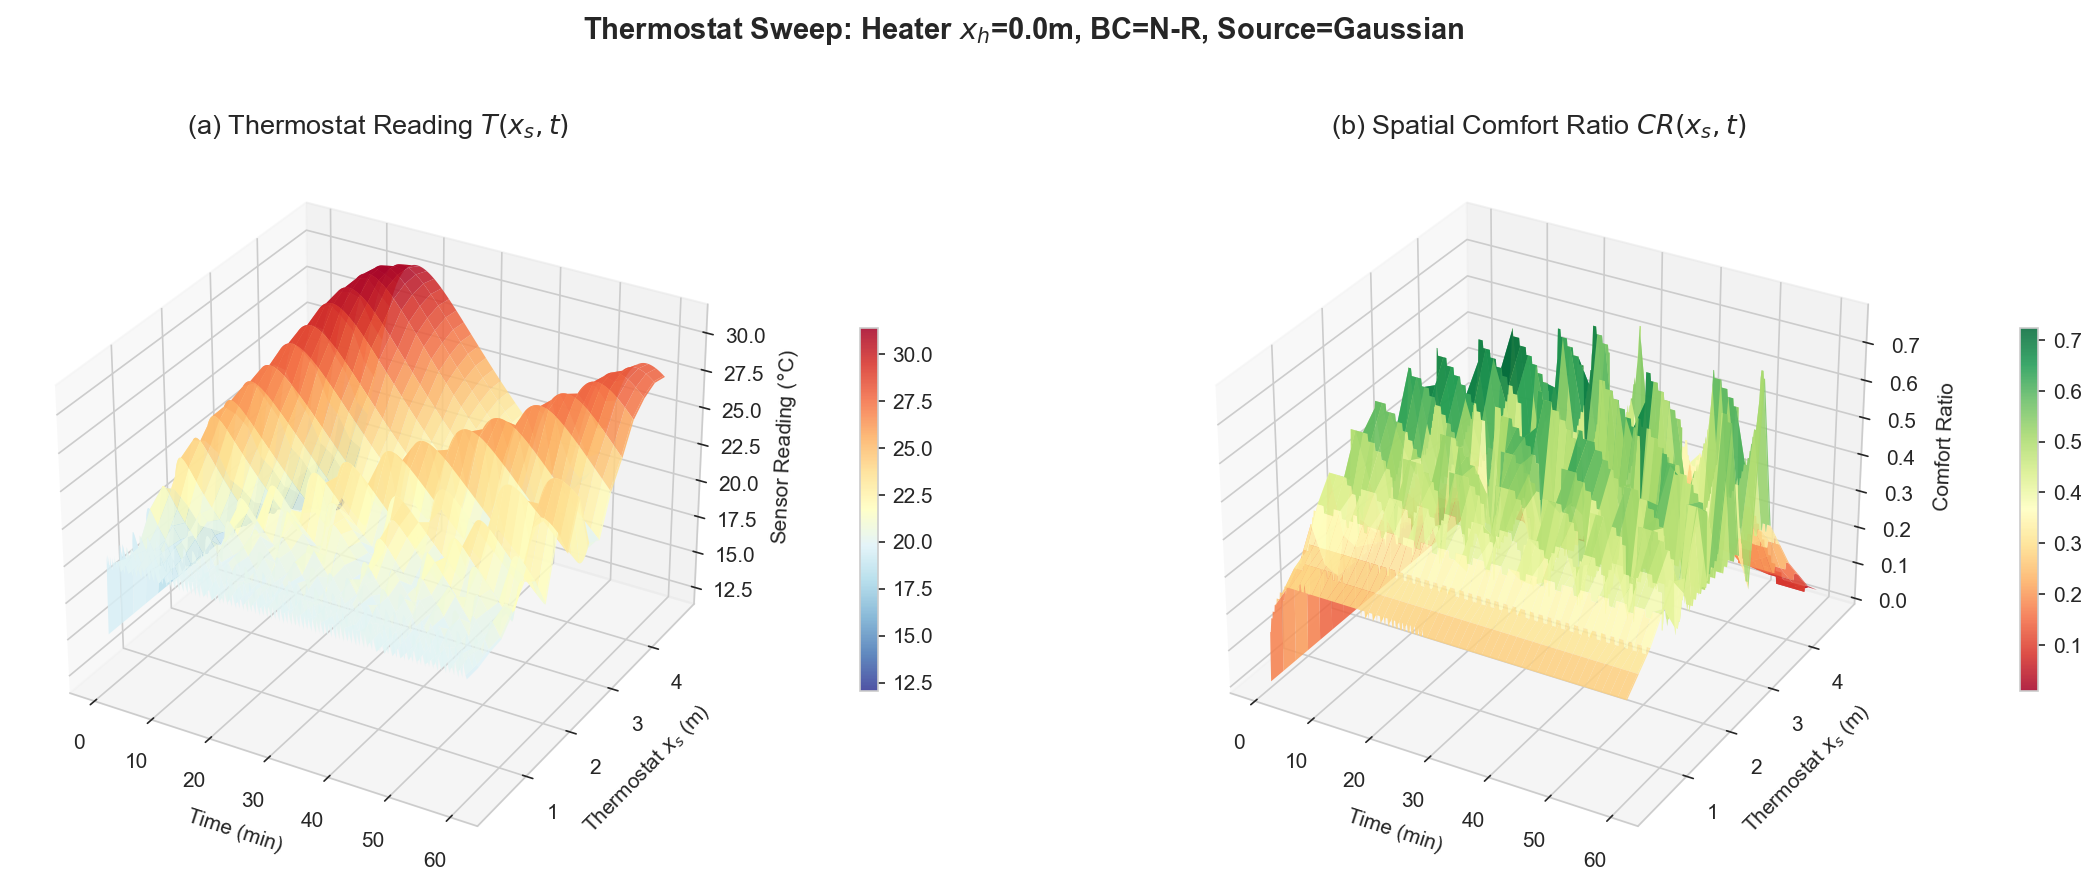

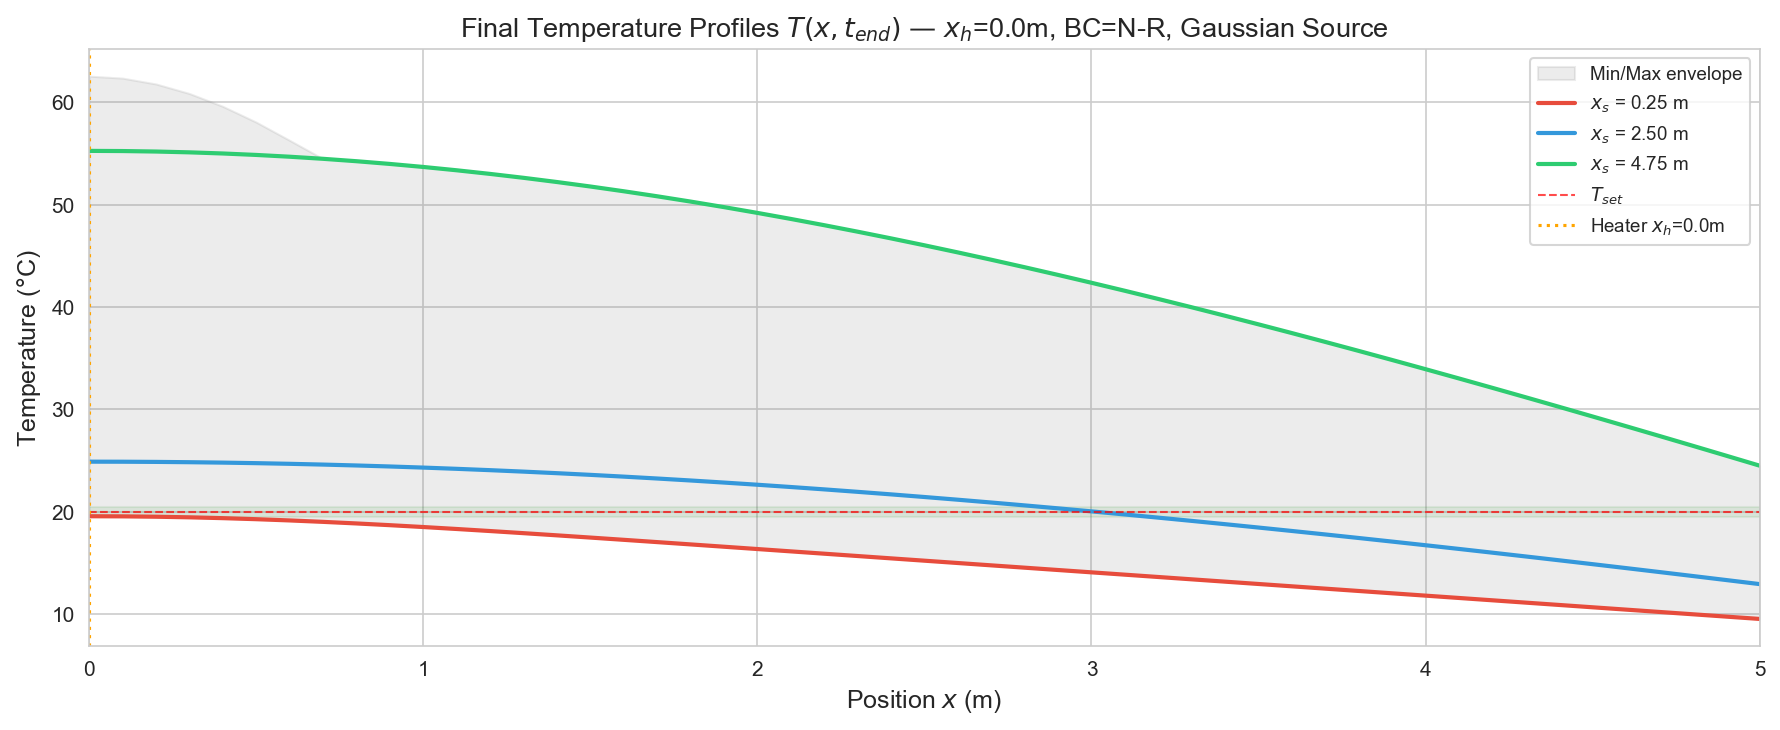

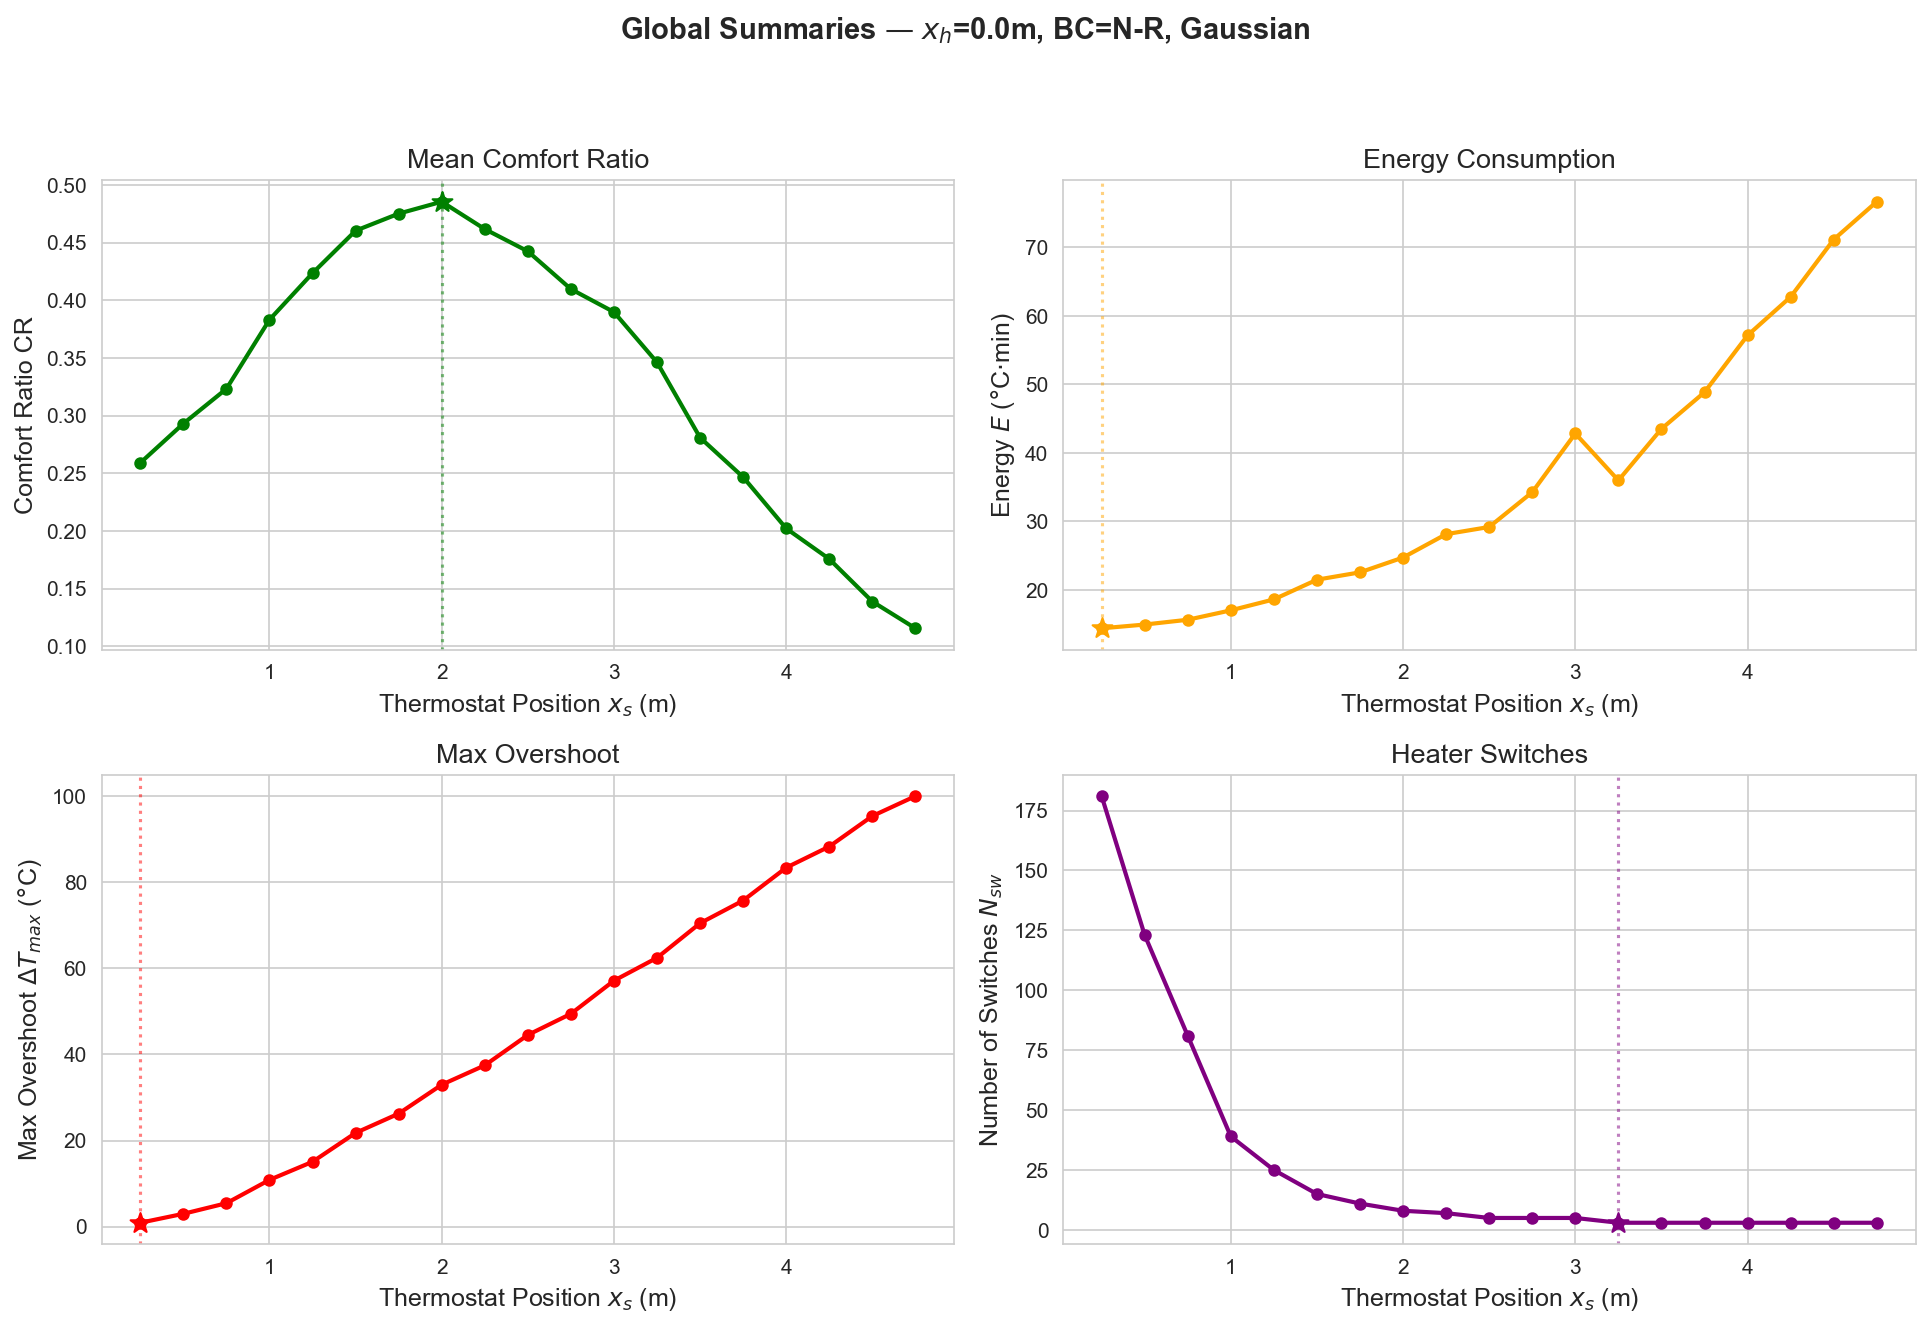

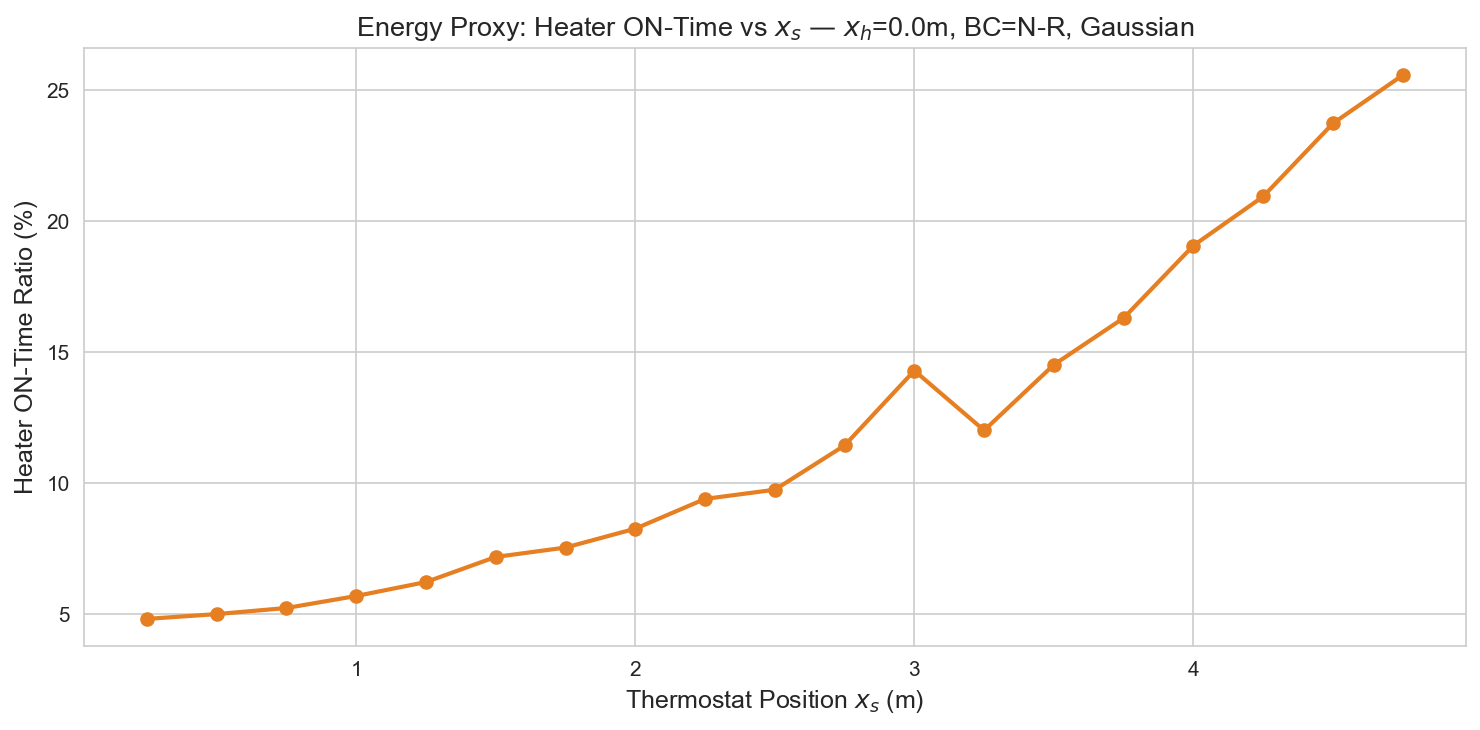

In [11]:
# ============================================================
# 实验 2.1: 加热器 x_h=0, BC=N-R, 高斯热源
# ============================================================
sweep_2_1 = run_and_plot_all(x_h=0.0, bc_type='NR', source_type='gaussian',
                              label='2.1', prefix='exp2_1')


实验 2.2: x_h=2.5m, BC=NR, source=gaussian
最优恒温器位置: x_s = 1.50 m, J = 0.4021
  x_s= 0.25m | E=   28.1 RMSE=4.373 ΔTmax=18.75 CR=0.615 t_s= 60.0 Nsw=   5 | J=0.4735
  x_s= 0.50m | E=   31.0 RMSE=4.120 ΔTmax=17.56 CR=0.616 t_s= 60.0 Nsw=   7 | J=0.4712
  x_s= 0.75m | E=   26.6 RMSE=3.805 ΔTmax=16.20 CR=0.646 t_s= 60.0 Nsw=   7 | J=0.4416
  x_s= 1.00m | E=   26.0 RMSE=3.508 ΔTmax=13.35 CR=0.634 t_s= 60.0 Nsw=  11 | J=0.4241
  x_s= 1.25m | E=   24.4 RMSE=3.405 ΔTmax=11.07 CR=0.623 t_s= 60.0 Nsw=  15 | J=0.4106
  x_s= 1.50m | E=   23.5 RMSE=3.383 ΔTmax= 7.42 CR=0.614 t_s= 60.0 Nsw=  29 | J=0.4021 ★
  x_s= 1.75m | E=   23.8 RMSE=3.401 ΔTmax= 5.14 CR=0.610 t_s= 60.0 Nsw=  49 | J=0.4100
  x_s= 2.00m | E=   23.3 RMSE=3.412 ΔTmax= 2.38 CR=0.608 t_s= 60.0 Nsw=  93 | J=0.4363
  x_s= 2.25m | E=   23.5 RMSE=3.380 ΔTmax= 1.19 CR=0.613 t_s= 60.0 Nsw= 123 | J=0.4576
  x_s= 2.50m | E=   24.4 RMSE=3.275 ΔTmax= 0.87 CR=0.628 t_s= 60.0 Nsw= 155 | J=0.4848
  x_s= 2.75m | E=   25.2 RMSE=3.178 ΔTmax= 1.28 CR=0

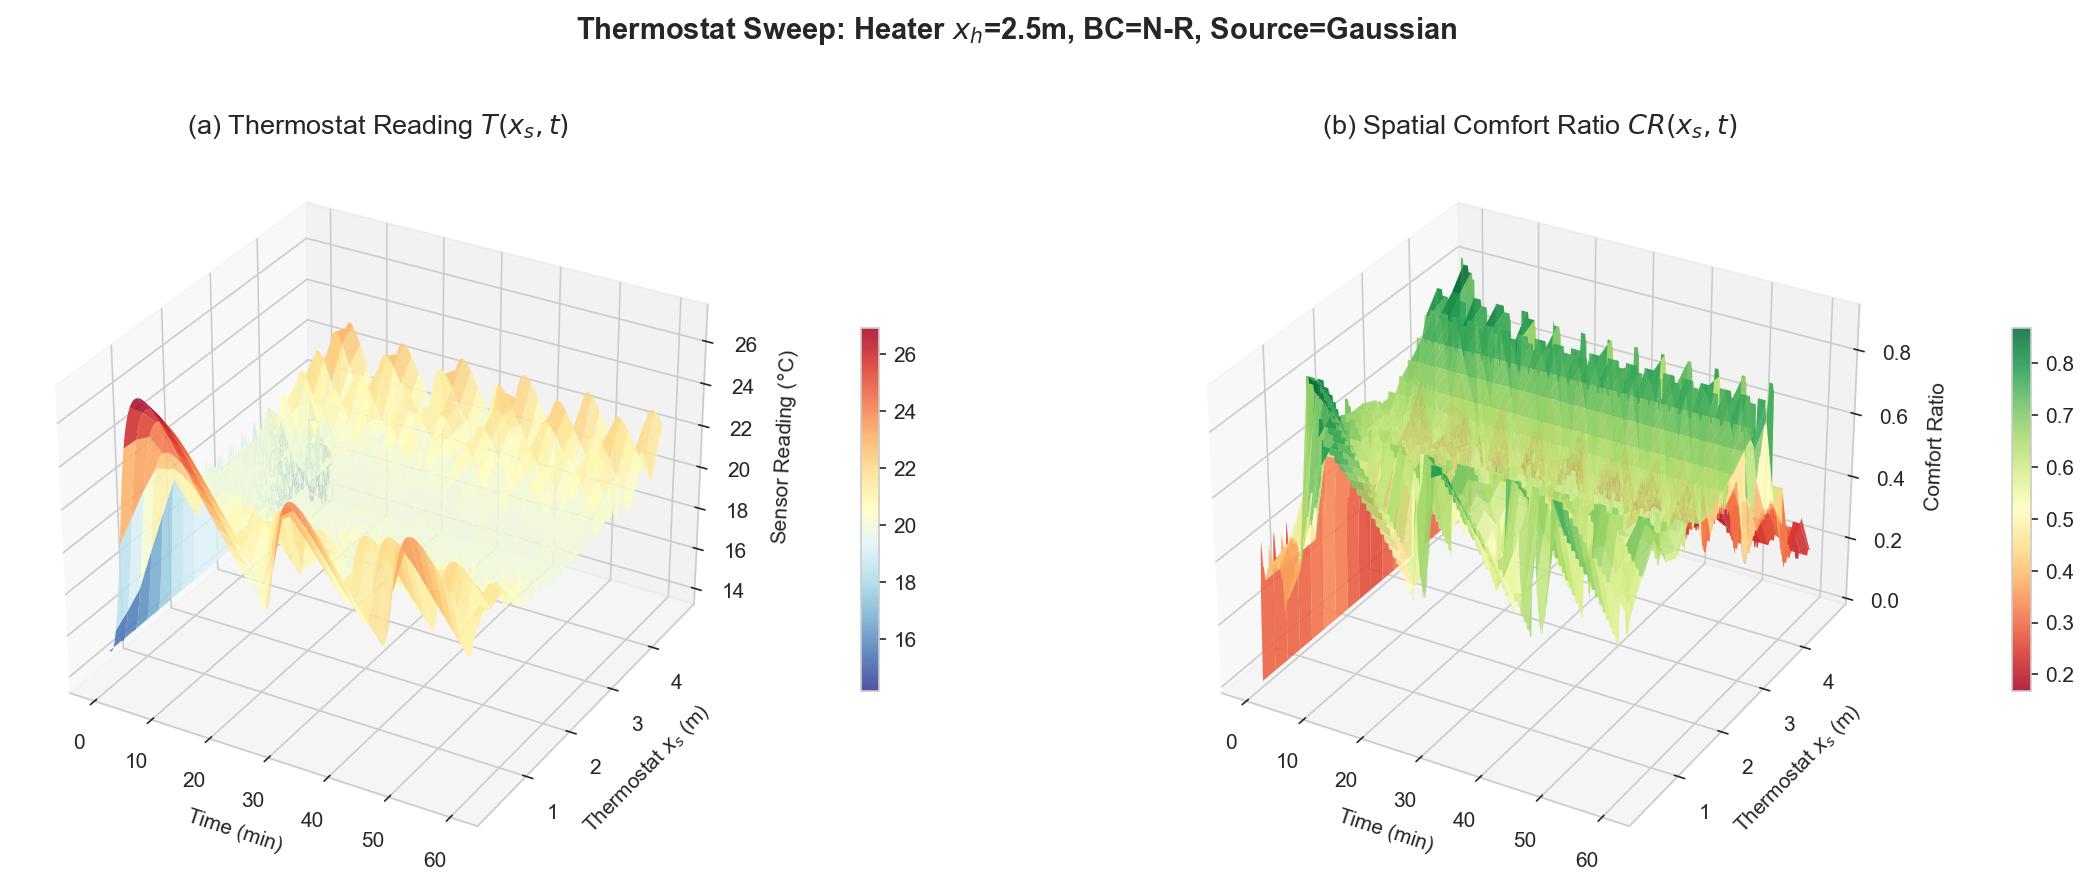

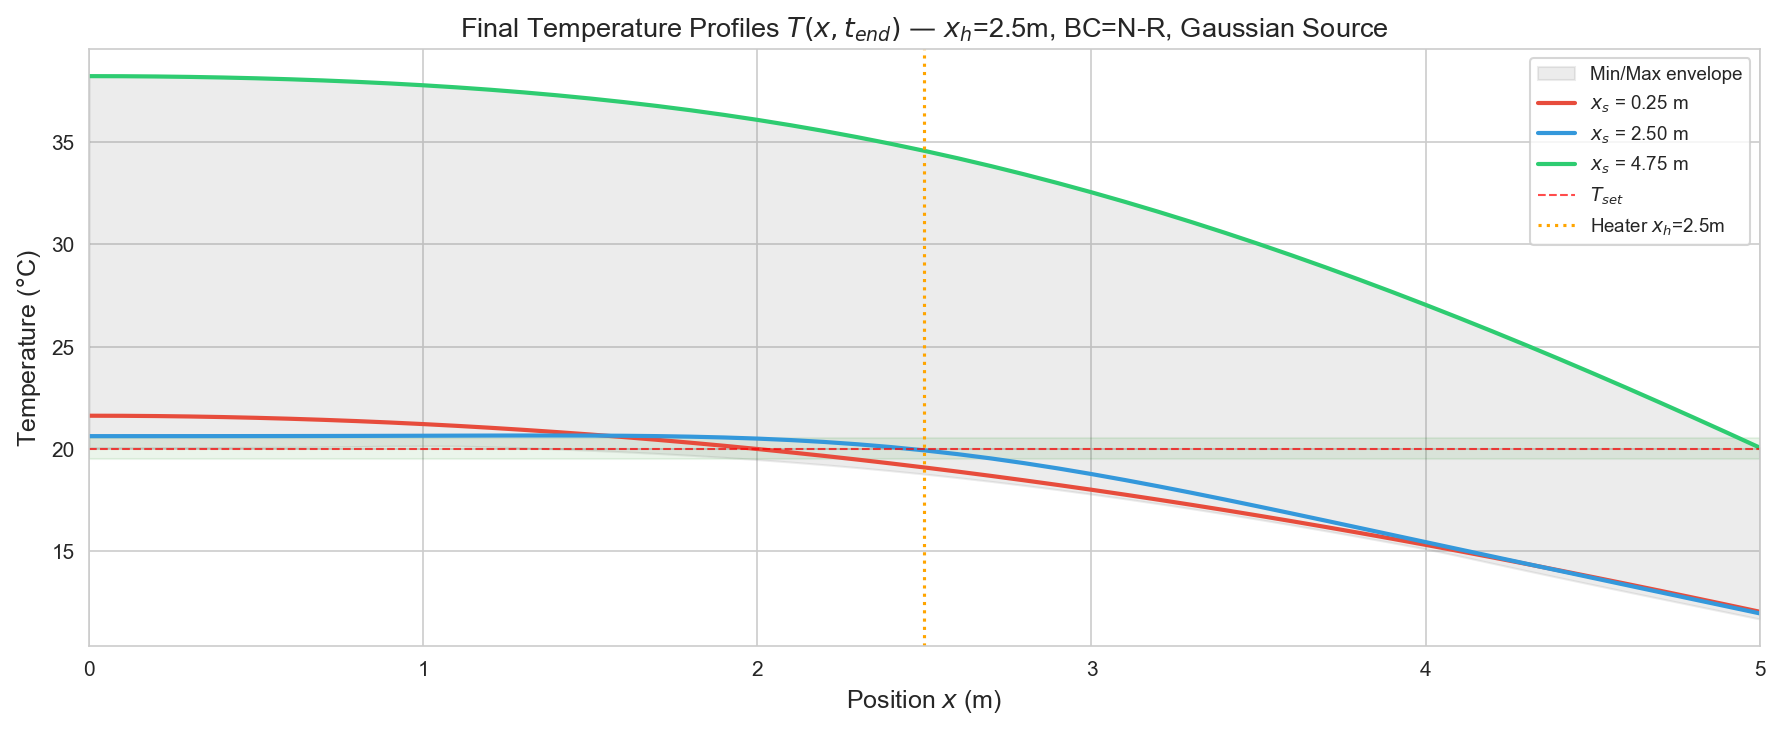

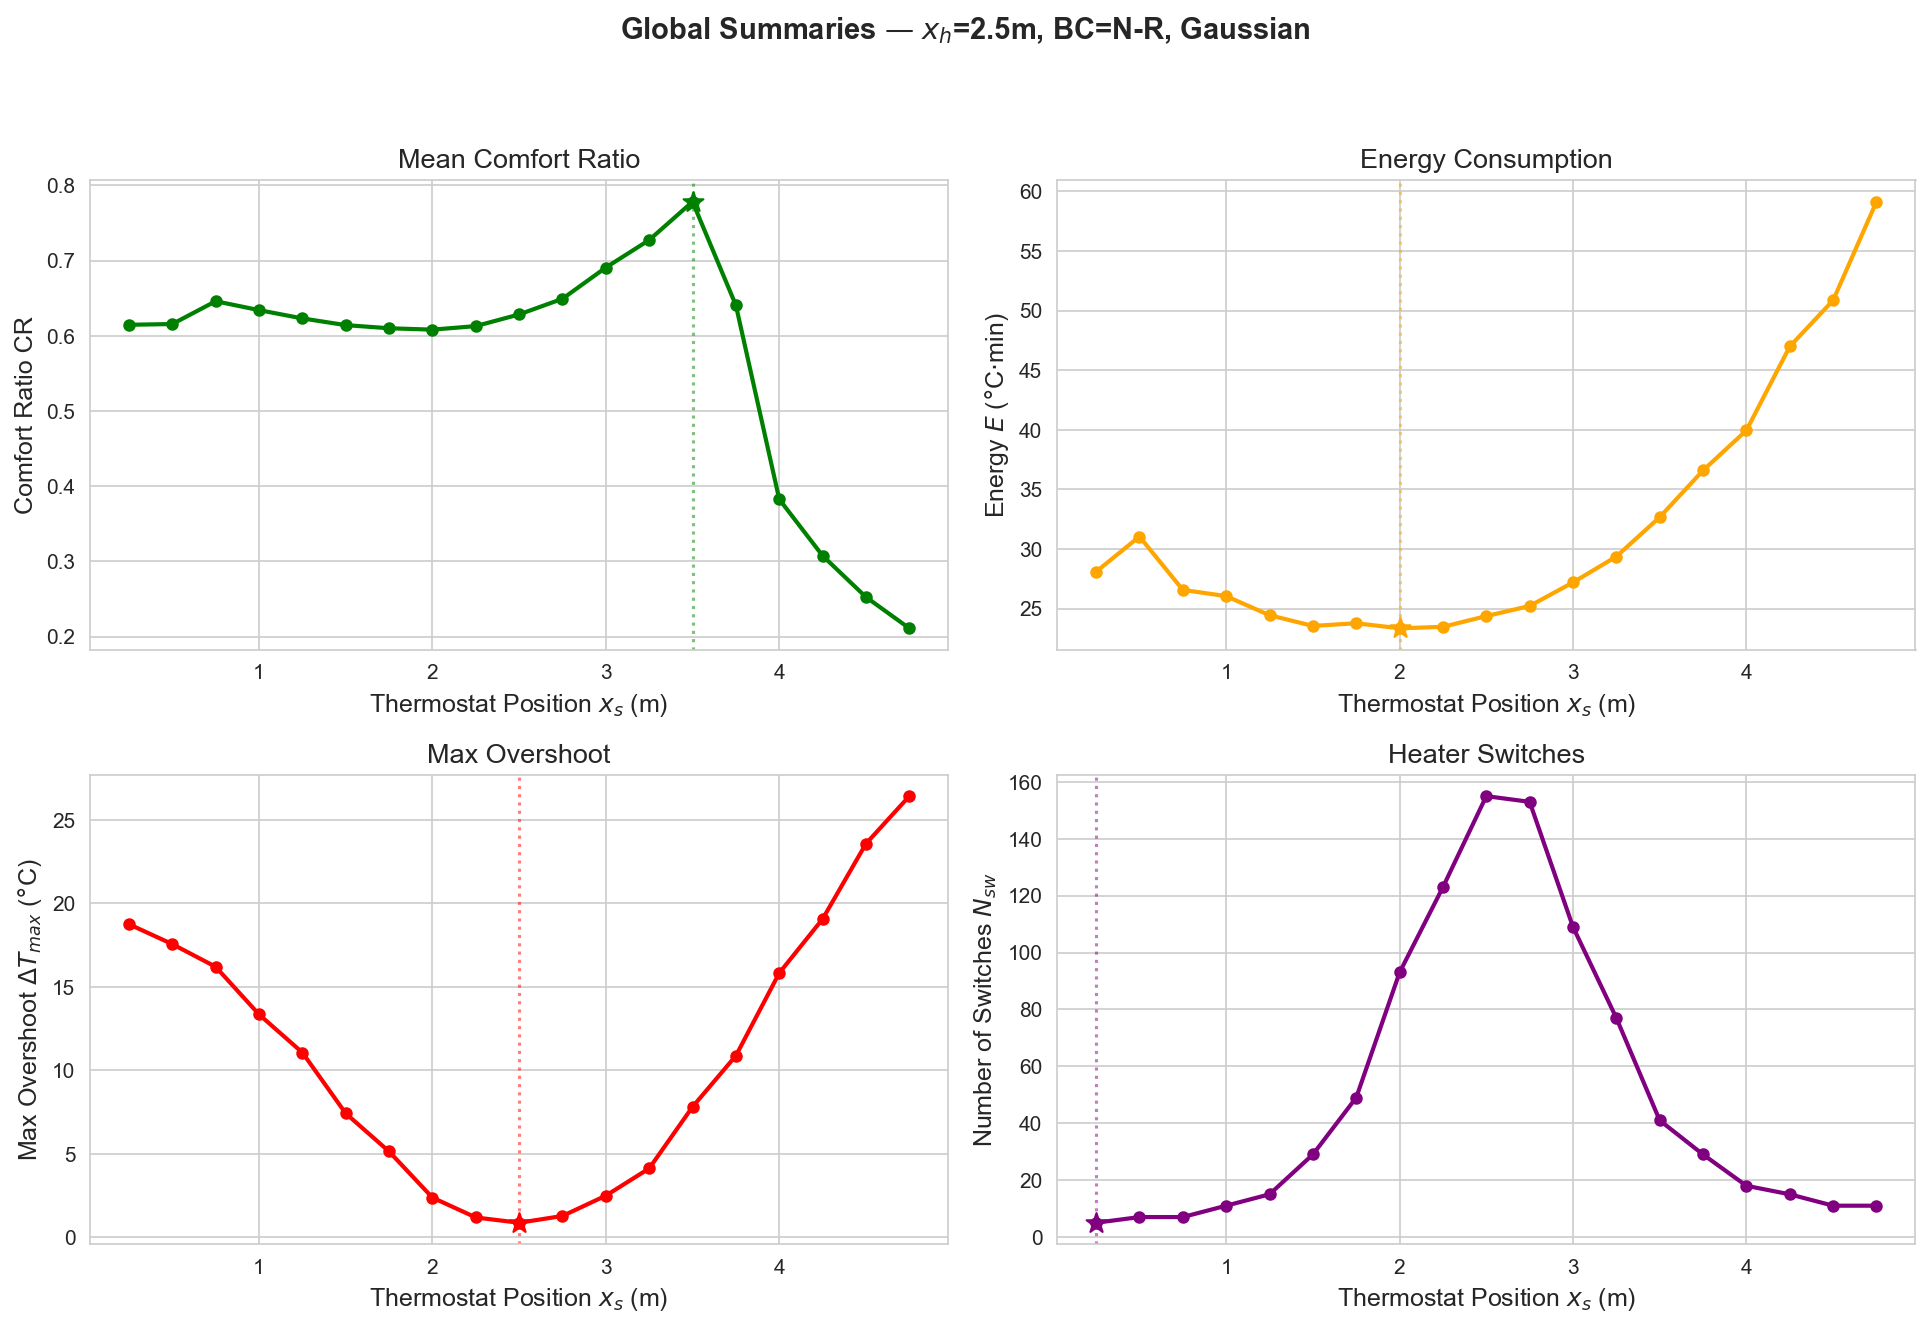

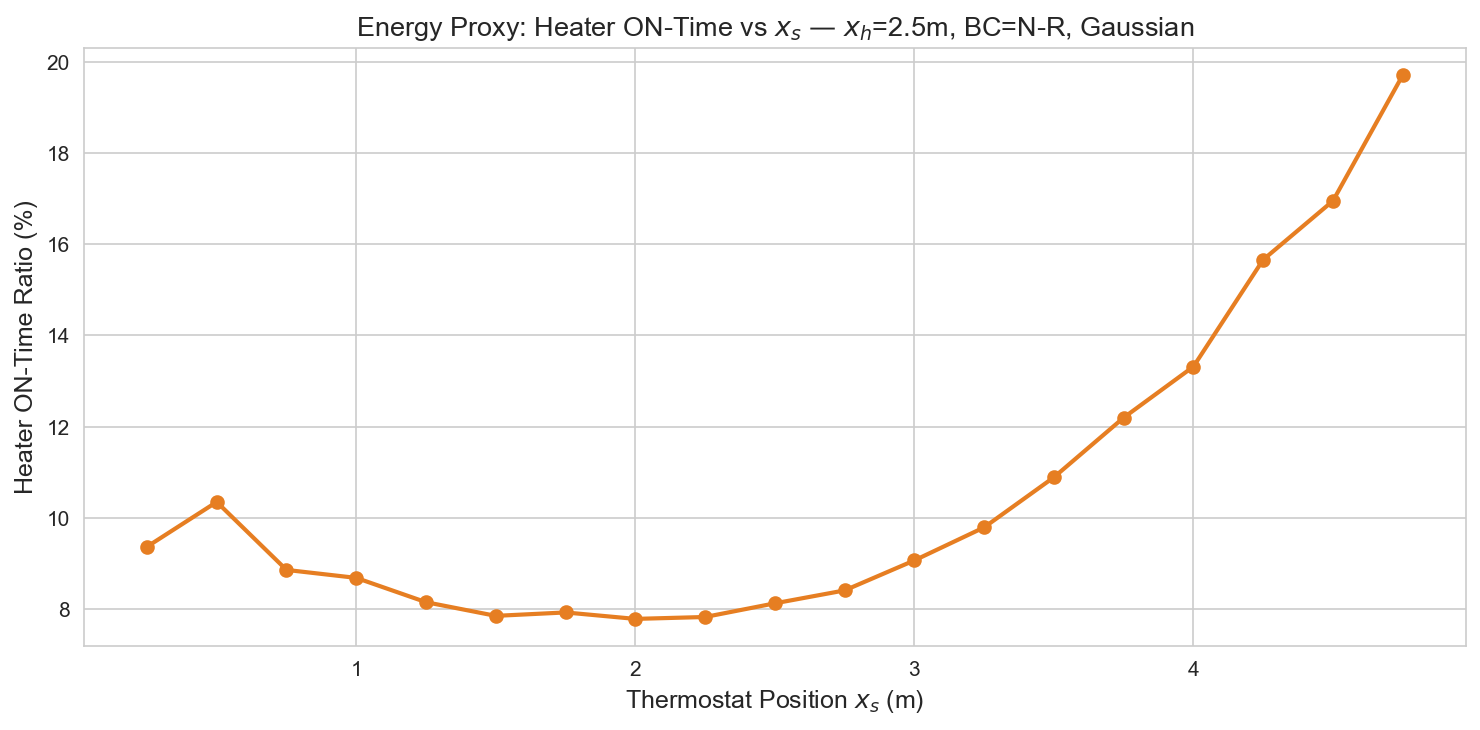

In [12]:
# ============================================================
# 实验 2.2: 加热器 x_h=L/2, BC=N-R, 高斯热源
# ============================================================
sweep_2_2 = run_and_plot_all(x_h=L/2, bc_type='NR', source_type='gaussian',
                              label='2.2', prefix='exp2_2')


实验 2.3: x_h=2.5m, BC=RR, source=gaussian
最优恒温器位置: x_s = 1.50 m, J = 0.4606
  x_s= 0.25m | E=   96.2 RMSE=9.720 ΔTmax=26.97 CR=0.383 t_s= 60.0 Nsw=  15 | J=0.8003
  x_s= 0.50m | E=   85.2 RMSE=7.252 ΔTmax=23.00 CR=0.539 t_s= 60.0 Nsw=  17 | J=0.6752
  x_s= 0.75m | E=   75.5 RMSE=5.759 ΔTmax=20.20 CR=0.604 t_s= 60.0 Nsw=  19 | J=0.5973
  x_s= 1.00m | E=   66.3 RMSE=4.109 ΔTmax=15.65 CR=0.644 t_s= 60.0 Nsw=  27 | J=0.5134
  x_s= 1.25m | E=   62.8 RMSE=3.475 ΔTmax=12.41 CR=0.643 t_s= 60.0 Nsw=  38 | J=0.4795
  x_s= 1.50m | E=   55.6 RMSE=3.261 ΔTmax= 7.79 CR=0.586 t_s= 60.0 Nsw=  67 | J=0.4606 ★
  x_s= 1.75m | E=   52.3 RMSE=3.447 ΔTmax= 5.23 CR=0.517 t_s= 60.0 Nsw= 103 | J=0.4748
  x_s= 2.00m | E=   48.0 RMSE=3.854 ΔTmax= 2.38 CR=0.430 t_s= 60.0 Nsw= 183 | J=0.5170
  x_s= 2.25m | E=   46.5 RMSE=4.071 ΔTmax= 1.19 CR=0.386 t_s= 60.0 Nsw= 238 | J=0.5485
  x_s= 2.50m | E=   45.4 RMSE=4.214 ΔTmax= 0.58 CR=0.363 t_s= 60.0 Nsw= 291 | J=0.5780
  x_s= 2.75m | E=   45.9 RMSE=4.153 ΔTmax= 0.81 CR=0

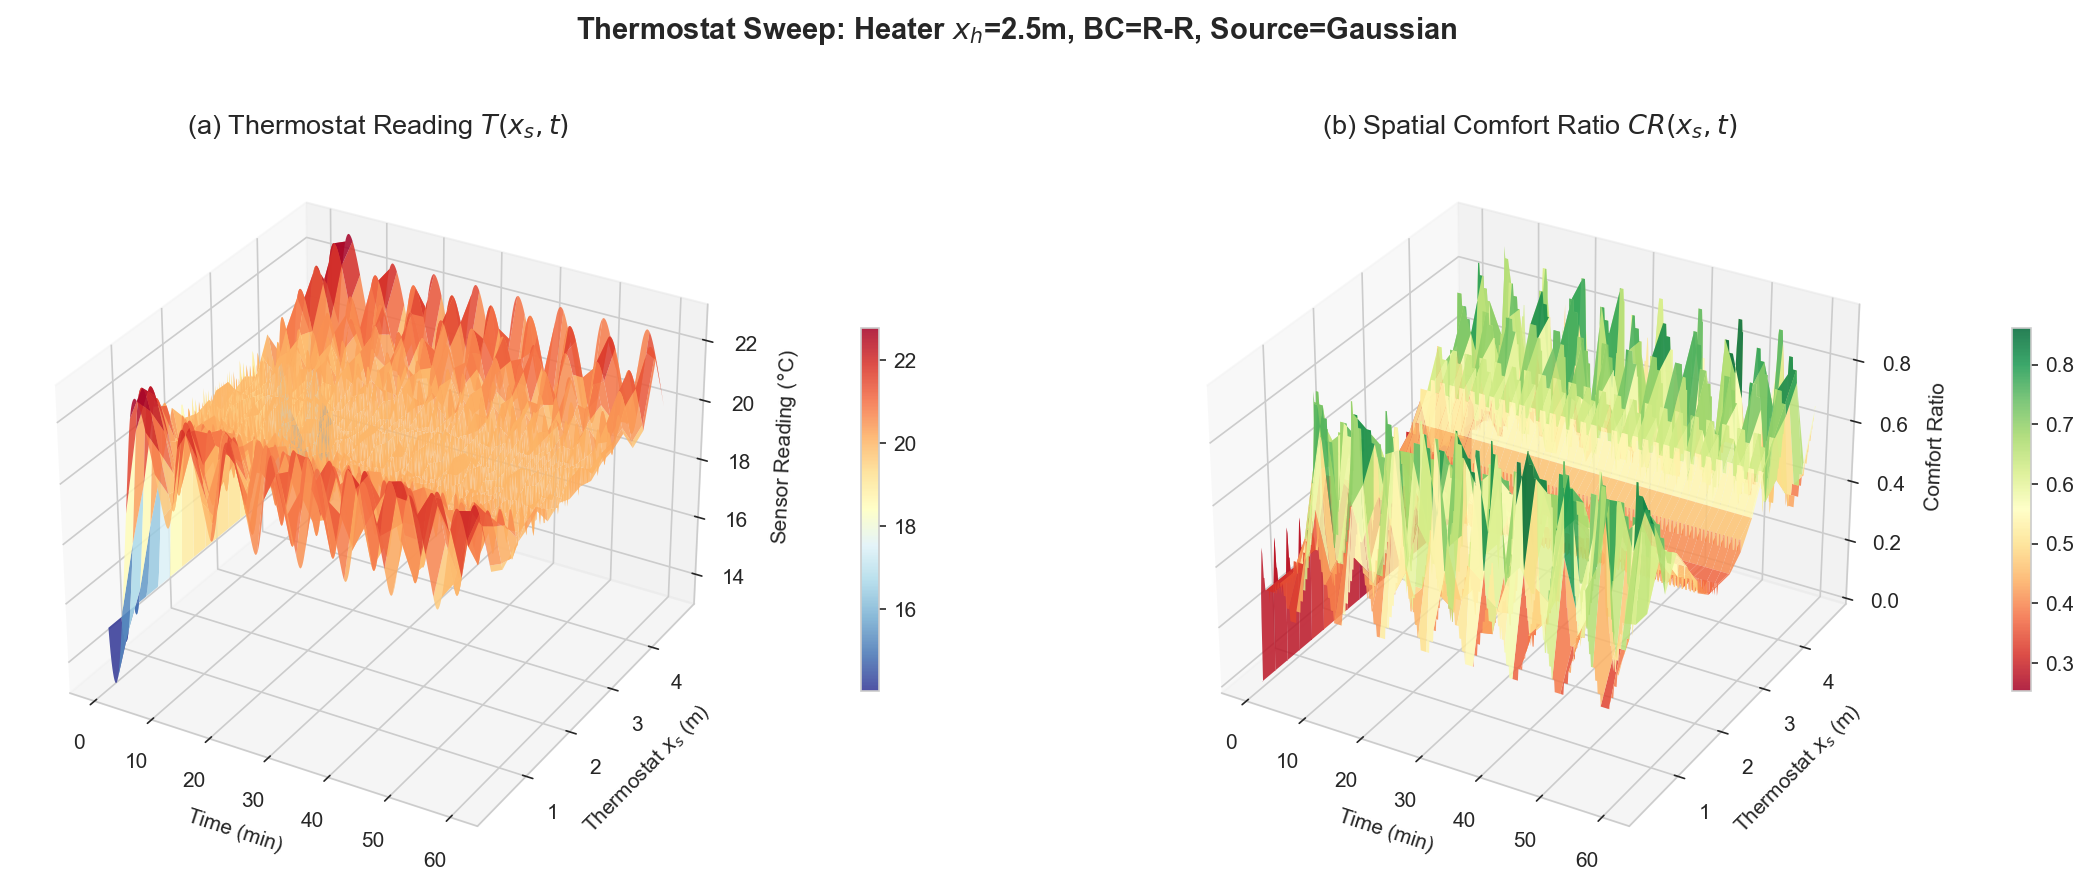

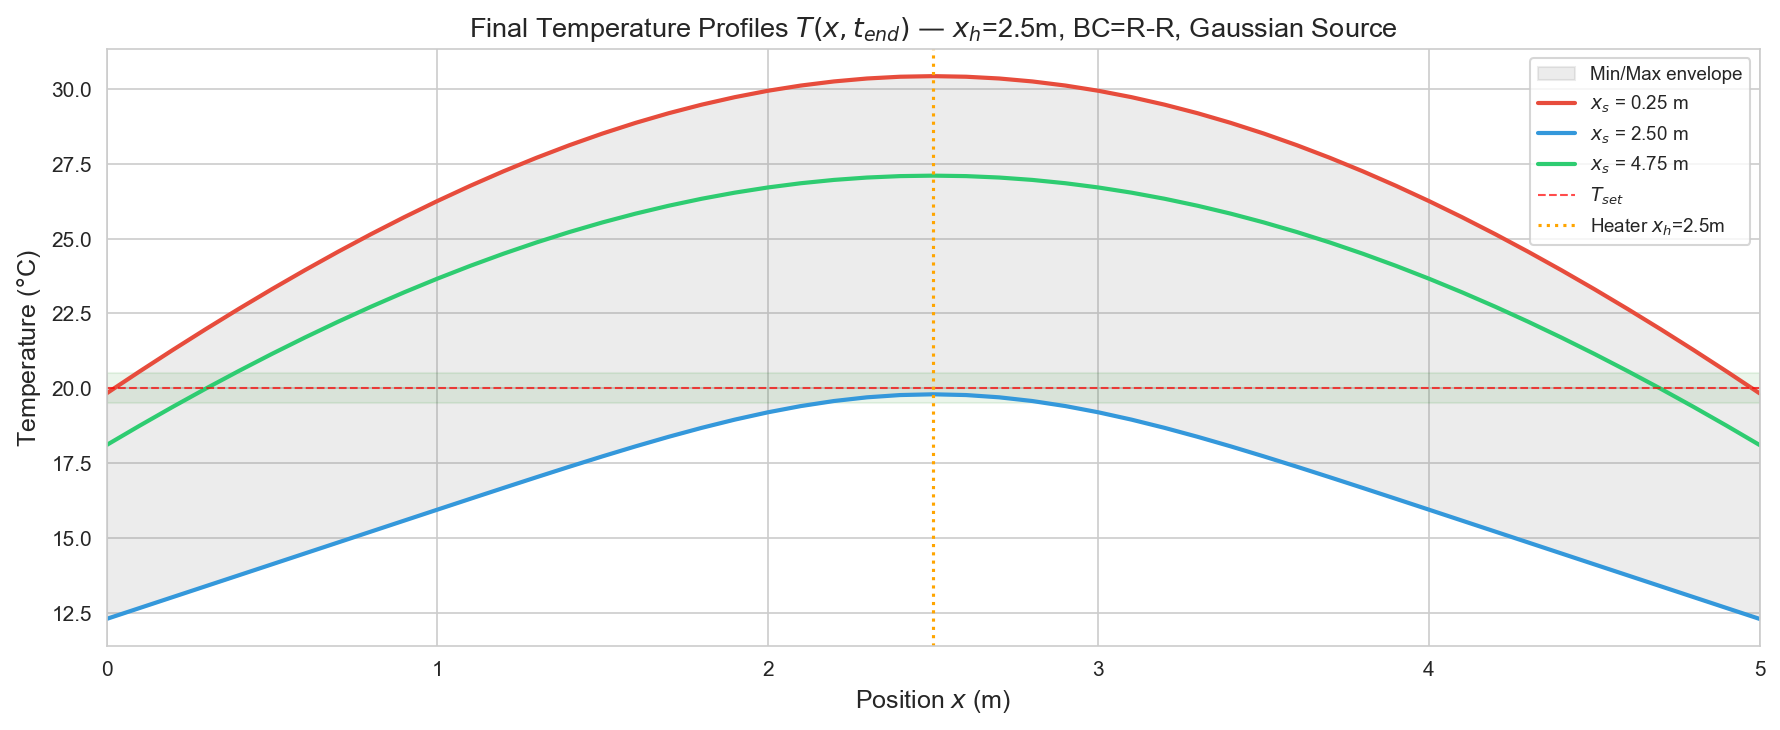

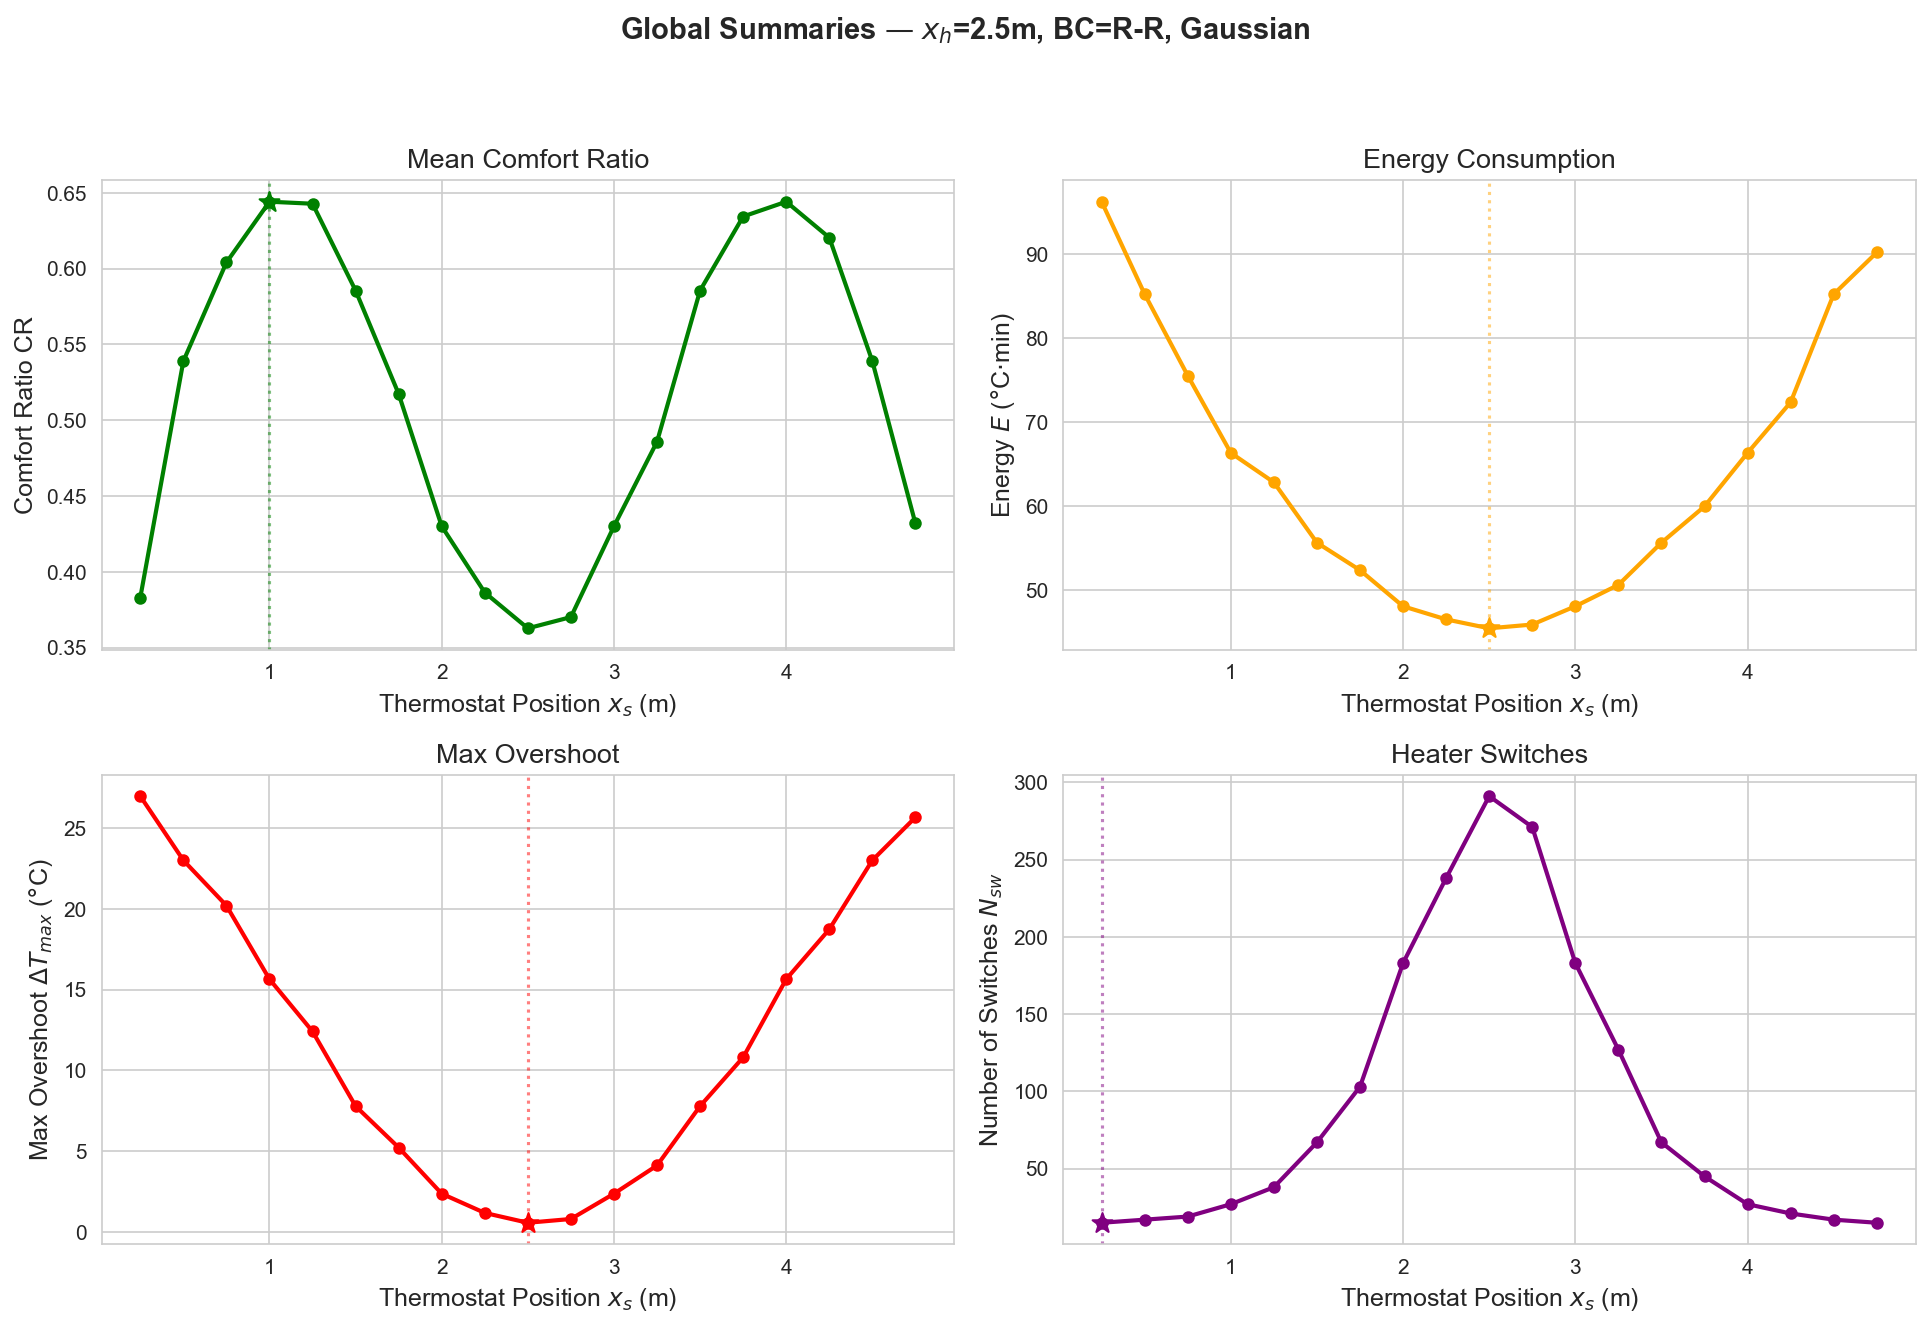

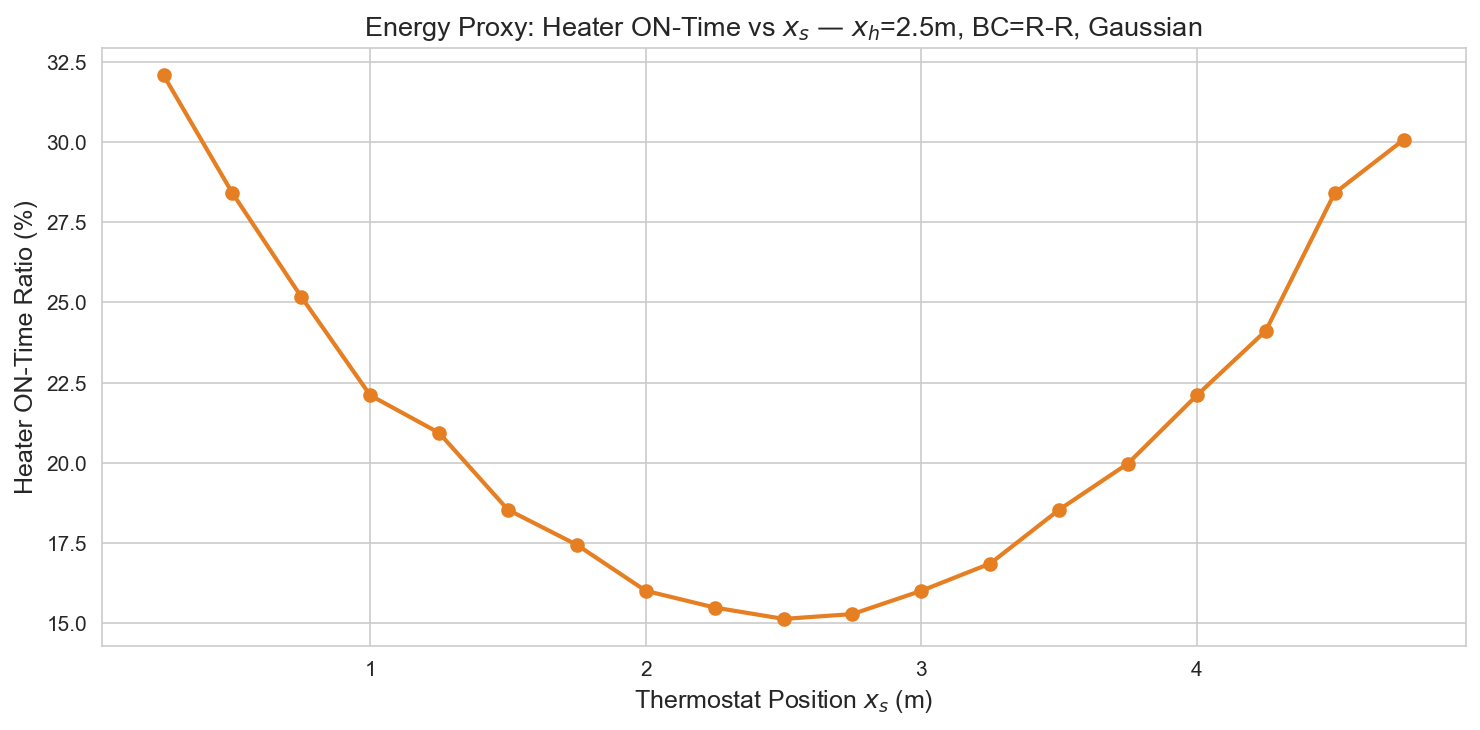

In [13]:
# ============================================================
# 实验 2.3: 加热器 x_h=L/2, BC=R-R, 高斯热源
# ============================================================
sweep_2_3 = run_and_plot_all(x_h=L/2, bc_type='RR', source_type='gaussian',
                              label='2.3', prefix='exp2_3')

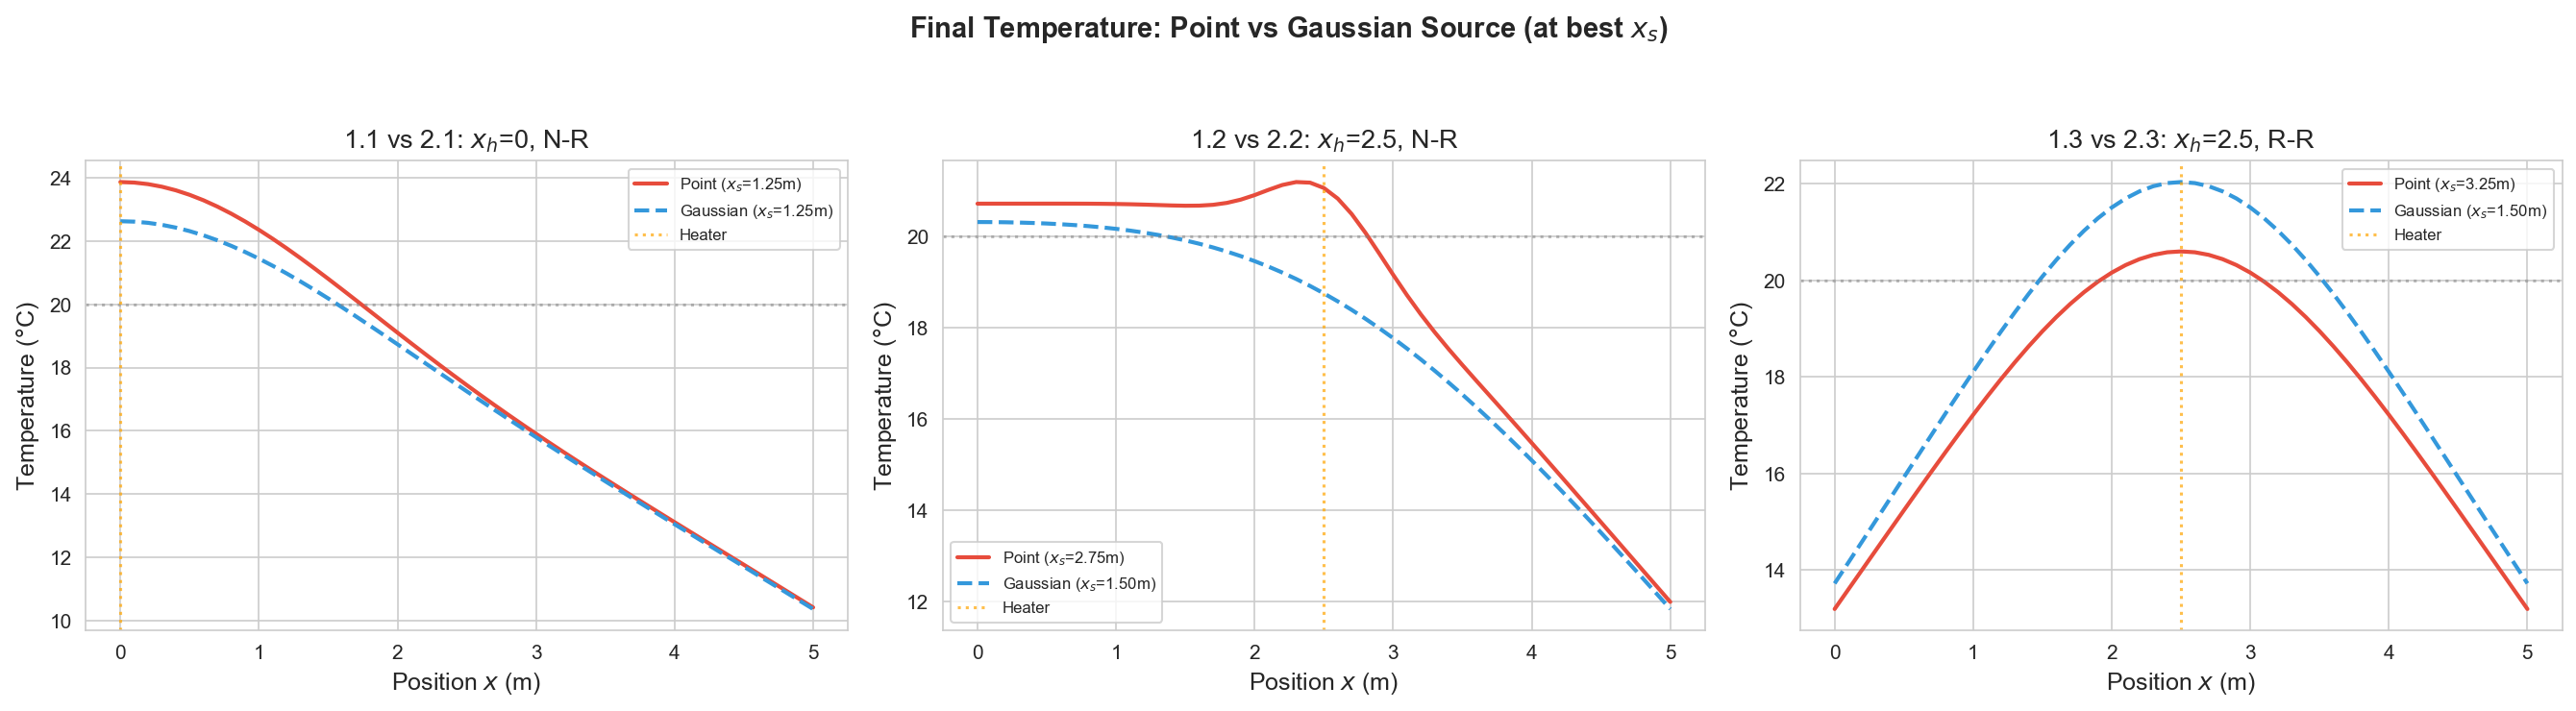

点热源 vs 高斯热源对比图已保存。


In [14]:
# ============================================================
# 点热源 vs 高斯热源终态温度分布对比
# ============================================================

pairs = [
    ('1.1 vs 2.1: $x_h$=0, N-R', sweep_1_1, sweep_2_1),
    ('1.2 vs 2.2: $x_h$=2.5, N-R', sweep_1_2, sweep_2_2),
    ('1.3 vs 2.3: $x_h$=2.5, R-R', sweep_1_3, sweep_2_3),
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Final Temperature: Point vs Gaussian Source (at best $x_s$)',
             fontsize=14, fontweight='bold')

for ax, (title, sw_pt, sw_gs) in zip(axes, pairs):
    x_arr = sw_pt['x_arr']
    # 各自最优 x_s 下的终态温度
    best_pt = np.argmin(sw_pt['J_values'])
    best_gs = np.argmin(sw_gs['J_values'])
    
    ax.plot(x_arr, sw_pt['sims'][best_pt]['T_final'], '-',
            color='#e74c3c', linewidth=2,
            label=f'Point ($x_s$={sw_pt["x_s_values"][best_pt]:.2f}m)')
    ax.plot(x_arr, sw_gs['sims'][best_gs]['T_final'], '--',
            color='#3498db', linewidth=2,
            label=f'Gaussian ($x_s$={sw_gs["x_s_values"][best_gs]:.2f}m)')
    ax.axhline(T_SET, color='gray', linestyle=':', alpha=0.5)
    ax.axvline(sw_pt['config']['x_h'], color='orange', linestyle=':',
               alpha=0.7, label='Heater')
    ax.set_xlabel('Position $x$ (m)')
    ax.set_ylabel('Temperature ($°$C)')
    ax.set_title(title)
    ax.legend(fontsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig(f'{OUT_DIR}/1D_exp2_source_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print('点热源 vs 高斯热源对比图已保存。')

## 实验 2.4：全枚举 — $x_h \times x_s \times$ 热源类型 $\times$ BC

加热器和恒温器位置都不固定，进行全枚举搜索：
- $x_h$：15 个位置
- $x_s$：15 个位置
- 热源类型：点热源、高斯热源
- BC：N-R、R-R
- 总方案数：$15 \times 15 \times 2 \times 2 = 900$

In [15]:
# ============================================================
# 实验 2.4: 全枚举搜索
# ============================================================

# 枚举网格（使用粗网格加速）
X_H_ENUM = np.linspace(0.25, 4.75, 15)
X_S_ENUM = np.linspace(0.25, 4.75, 15)
SOURCE_TYPES = ['point', 'gaussian']
BC_TYPES = ['NR', 'RR']

total_sims = len(X_H_ENUM) * len(X_S_ENUM) * len(SOURCE_TYPES) * len(BC_TYPES)
print(f'全枚举方案数: {total_sims}')

enum_results = []
count = 0

for src in SOURCE_TYPES:
    for bc in BC_TYPES:
        print(f'\n--- Source={src}, BC={bc} ---')
        for x_h in X_H_ENUM:
            for x_s in X_S_ENUM:
                sim = simulate_1d(x_h, x_s, bc_type=bc, source_type=src,
                                  dt=DT_COARSE, N_x=N_X_COARSE)
                m = compute_metrics_1d(sim)
                enum_results.append({
                    'x_h': x_h, 'x_s': x_s,
                    'source': src, 'bc': bc, **m
                })
                count += 1
        print(f'  完成 {count}/{total_sims}')

df_enum = pd.DataFrame(enum_results)

# 计算归一化参考量和 J 值
ref_enum = compute_ref_maxes(enum_results)
df_enum['J_Balanced'] = df_enum.apply(
    lambda r: compute_unified_cost(
        {k: r[k] for k in ['E', 'RMSE', 'DeltaT_max', 'CR', 't_s', 'N_sw']},
        ref_enum, WEIGHT_SCHEMES['Balanced']), axis=1)
df_enum['J_Comfort'] = df_enum.apply(
    lambda r: compute_unified_cost(
        {k: r[k] for k in ['E', 'RMSE', 'DeltaT_max', 'CR', 't_s', 'N_sw']},
        ref_enum, WEIGHT_SCHEMES['Comfort']), axis=1)
df_enum['J_Energy'] = df_enum.apply(
    lambda r: compute_unified_cost(
        {k: r[k] for k in ['E', 'RMSE', 'DeltaT_max', 'CR', 't_s', 'N_sw']},
        ref_enum, WEIGHT_SCHEMES['Energy']), axis=1)

df_enum.to_csv(f'{OUT_DIR}/1D_full_enumeration.csv', index=False)
print(f'\n全枚举完成。CSV 已保存: 1D_full_enumeration.csv')
print(f'\n全局 Top-5 (Balanced):')
display(df_enum.nsmallest(5, 'J_Balanced')[[
    'x_h', 'x_s', 'source', 'bc', 'E', 'RMSE', 'DeltaT_max',
    'CR', 't_s', 'N_sw', 'J_Balanced'
]])

全枚举方案数: 900

--- Source=point, BC=NR ---
  完成 225/900

--- Source=point, BC=RR ---
  完成 450/900

--- Source=gaussian, BC=NR ---
  完成 675/900

--- Source=gaussian, BC=RR ---
  完成 900/900

全枚举完成。CSV 已保存: 1D_full_enumeration.csv

全局 Top-5 (Balanced):


x_h       x_s    source  bc      E      RMSE  DeltaT_max        CR  \
655  4.428571  3.464286  gaussian  NR  40.55  1.556202    8.292533  0.850647   
639  4.107143  3.142857  gaussian  NR  37.05  1.673981    6.405020  0.819936   
654  4.428571  3.142857  gaussian  NR  41.75  1.736059   11.298883  0.857212   
671  4.750000  3.785714  gaussian  NR  43.20  1.481726    7.327002  0.854808   
640  4.107143  3.464286  gaussian  NR  36.35  1.677408    4.180787  0.808404   

      t_s  N_sw  J_Balanced  
655  60.0    51    0.234291  
639  60.0    57    0.235343  
654  60.0    33    0.237172  
671  60.0    78    0.237592  
640  60.0    93    0.238506

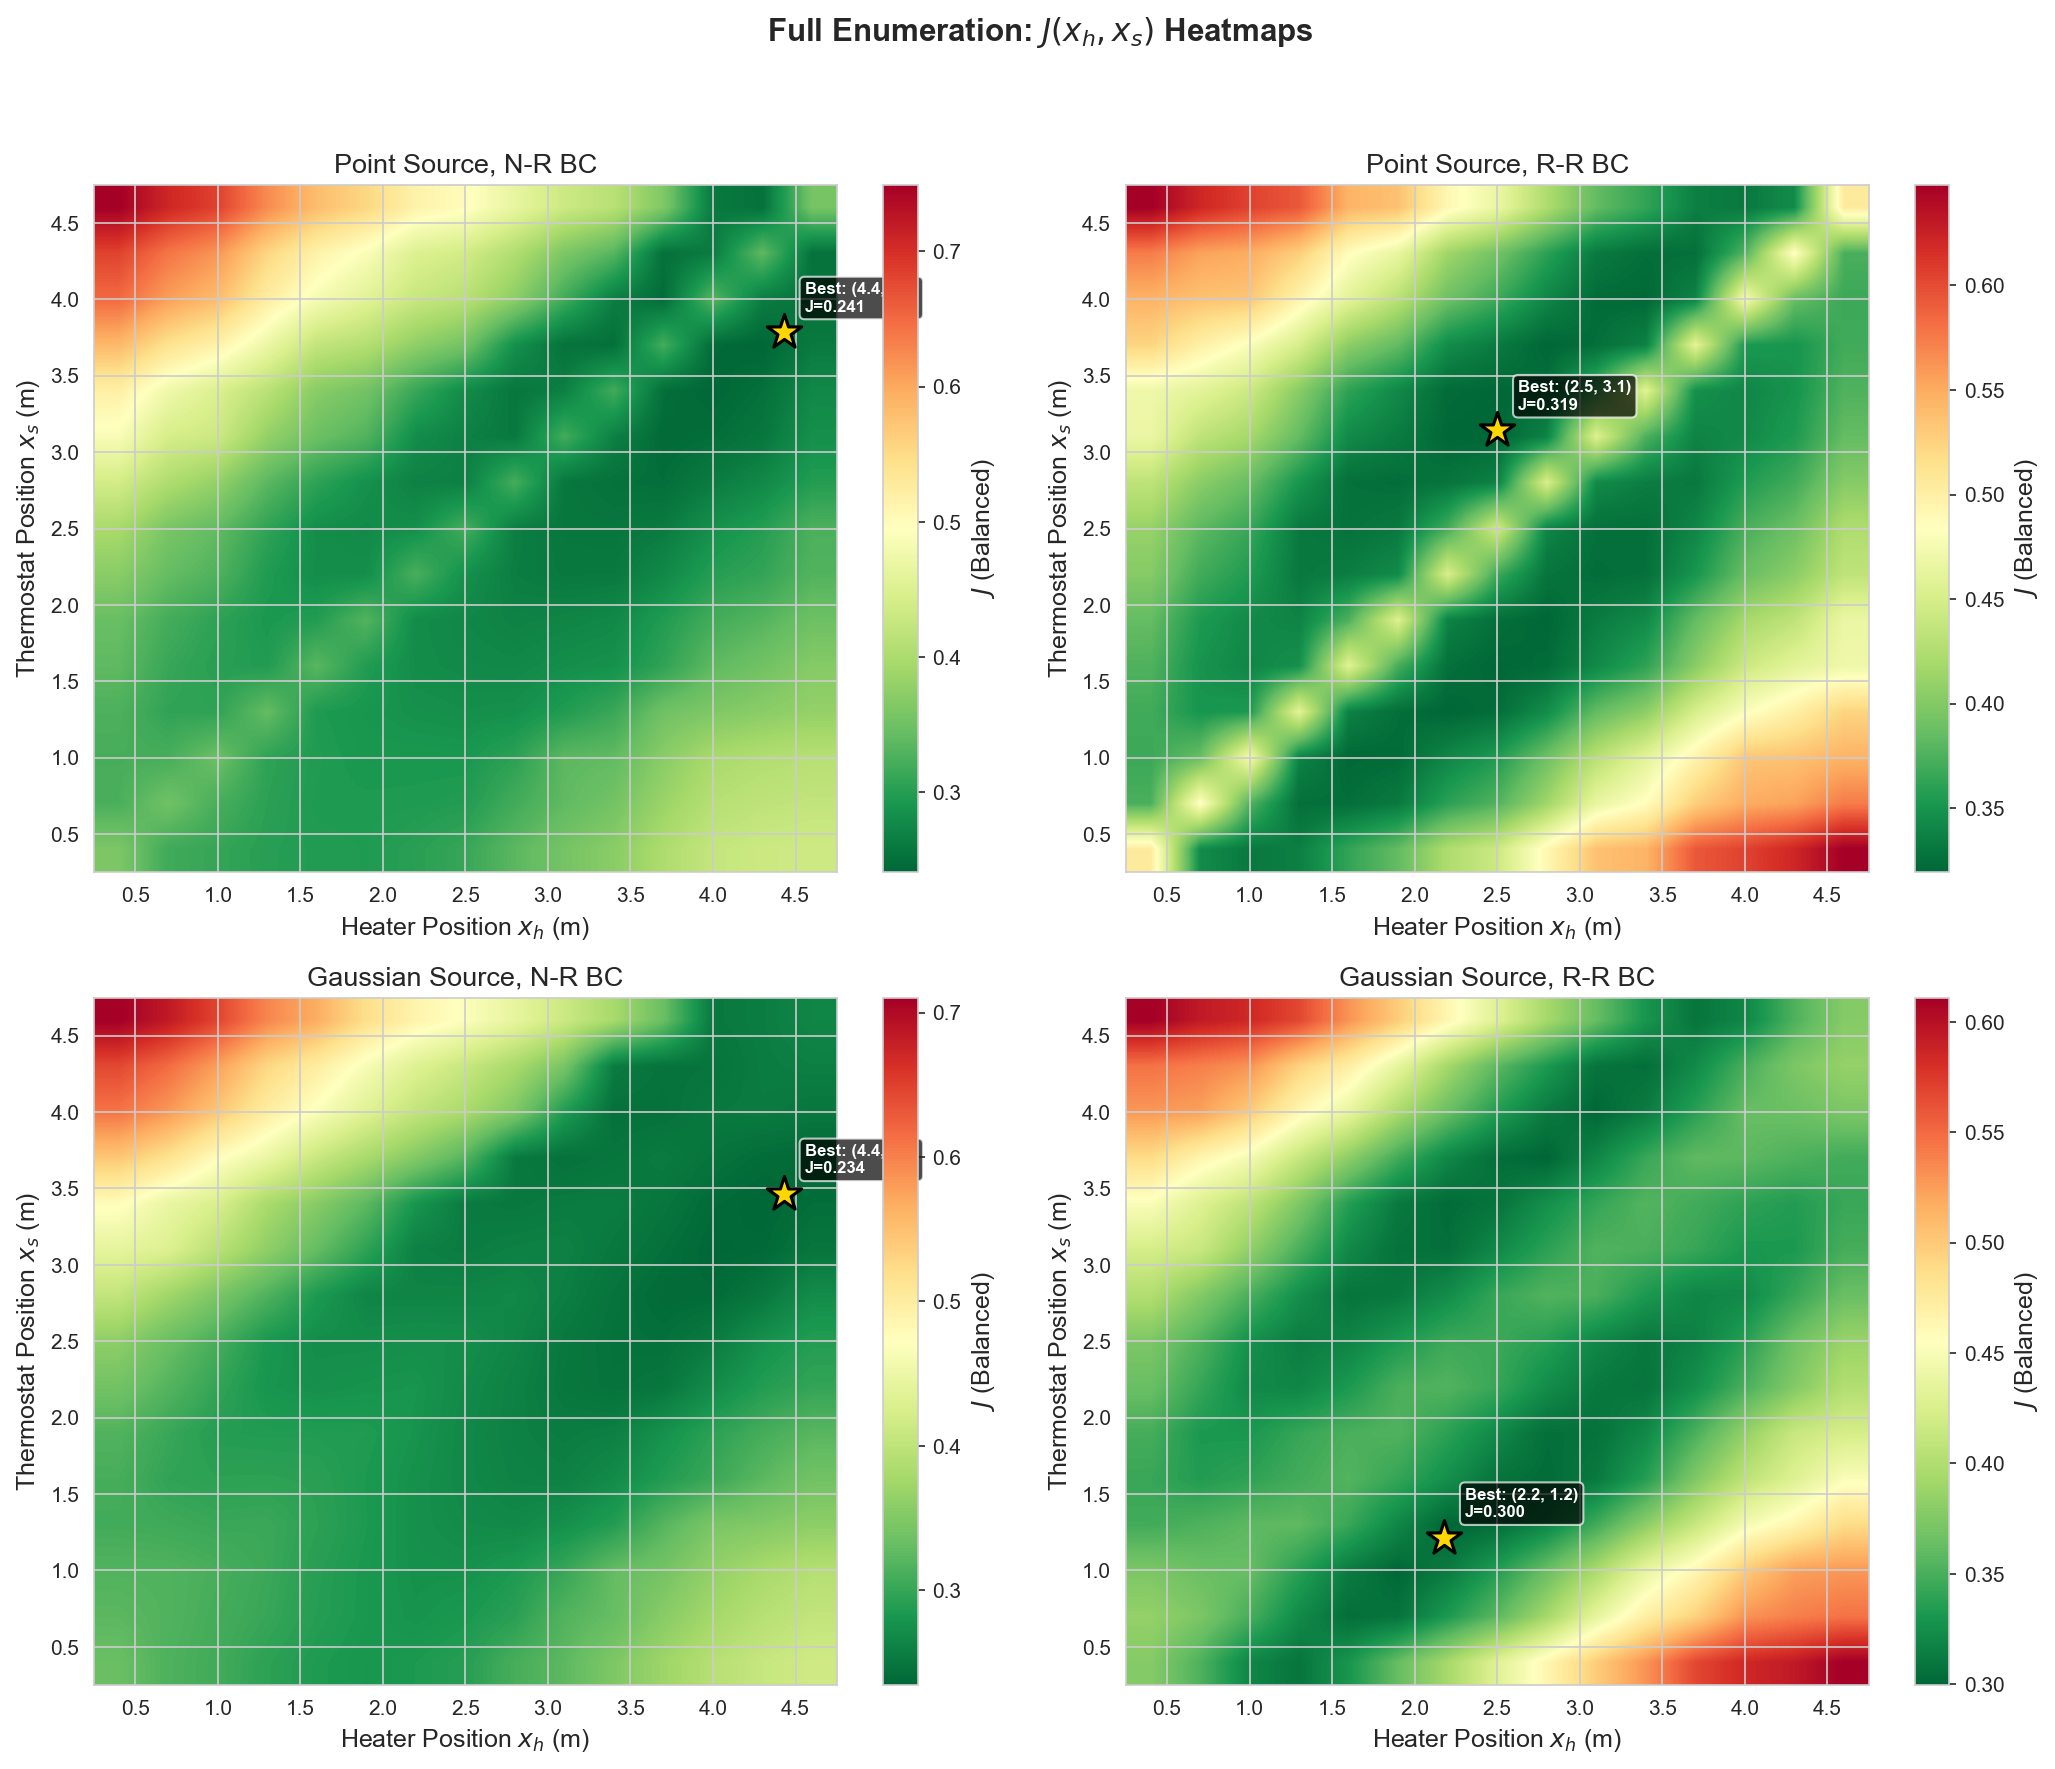

全枚举热力图已保存。


In [16]:
# ============================================================
# 实验 2.4: J(x_h, x_s) 热力图 (2×2 面板)
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Full Enumeration: $J(x_h, x_s)$ Heatmaps',
             fontsize=15, fontweight='bold')

panel_configs = [
    ('point', 'NR', 'Point Source, N-R BC'),
    ('point', 'RR', 'Point Source, R-R BC'),
    ('gaussian', 'NR', 'Gaussian Source, N-R BC'),
    ('gaussian', 'RR', 'Gaussian Source, R-R BC'),
]

for ax, (src, bc, title) in zip(axes.flat, panel_configs):
    subset = df_enum[(df_enum['source'] == src) & (df_enum['bc'] == bc)]
    
    # 构建热力图矩阵
    J_matrix = np.full((len(X_S_ENUM), len(X_H_ENUM)), np.nan)
    for _, row in subset.iterrows():
        i_s = np.argmin(np.abs(X_S_ENUM - row['x_s']))
        i_h = np.argmin(np.abs(X_H_ENUM - row['x_h']))
        J_matrix[i_s, i_h] = row['J_Balanced']
    
    im = ax.imshow(J_matrix, origin='lower', aspect='auto',
                   extent=[X_H_ENUM[0], X_H_ENUM[-1],
                           X_S_ENUM[0], X_S_ENUM[-1]],
                   cmap='RdYlGn_r', interpolation='bilinear')
    plt.colorbar(im, ax=ax, label='$J$ (Balanced)')
    
    # 标注最优组合
    best = subset.loc[subset['J_Balanced'].idxmin()]
    ax.scatter(best['x_h'], best['x_s'], marker='*', s=300,
              color='gold', edgecolors='black', linewidth=1.5, zorder=5)
    ax.annotate(f'Best: ({best["x_h"]:.1f}, {best["x_s"]:.1f})\nJ={best["J_Balanced"]:.3f}',
                xy=(best['x_h'], best['x_s']),
                xytext=(10, 10), textcoords='offset points',
                fontsize=8, fontweight='bold', color='white',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))
    
    ax.set_xlabel('Heater Position $x_h$ (m)')
    ax.set_ylabel('Thermostat Position $x_s$ (m)')
    ax.set_title(title)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(f'{OUT_DIR}/1D_exp2_4_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print('全枚举热力图已保存。')

## 实验 2.5：全面汇总

- 点热源 vs 高斯热源性能对比
- 全枚举全局最优方案
- 舒适导向 vs 节能导向最优方案对比

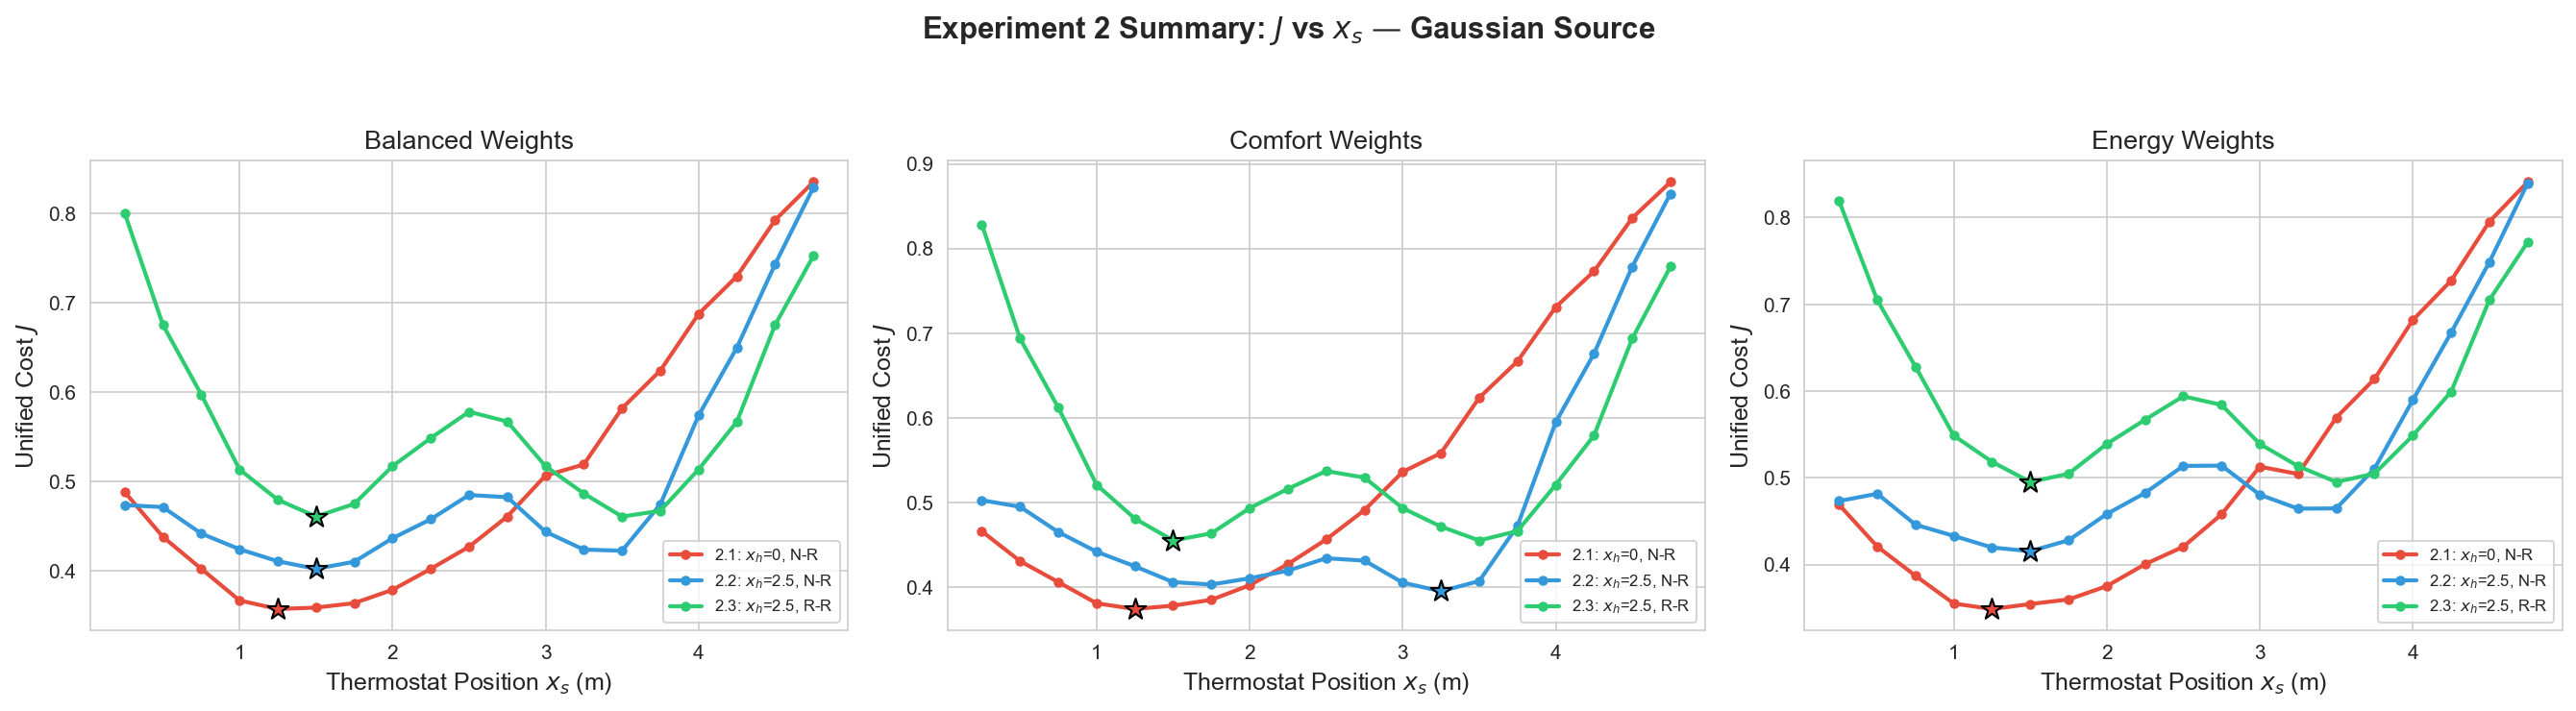

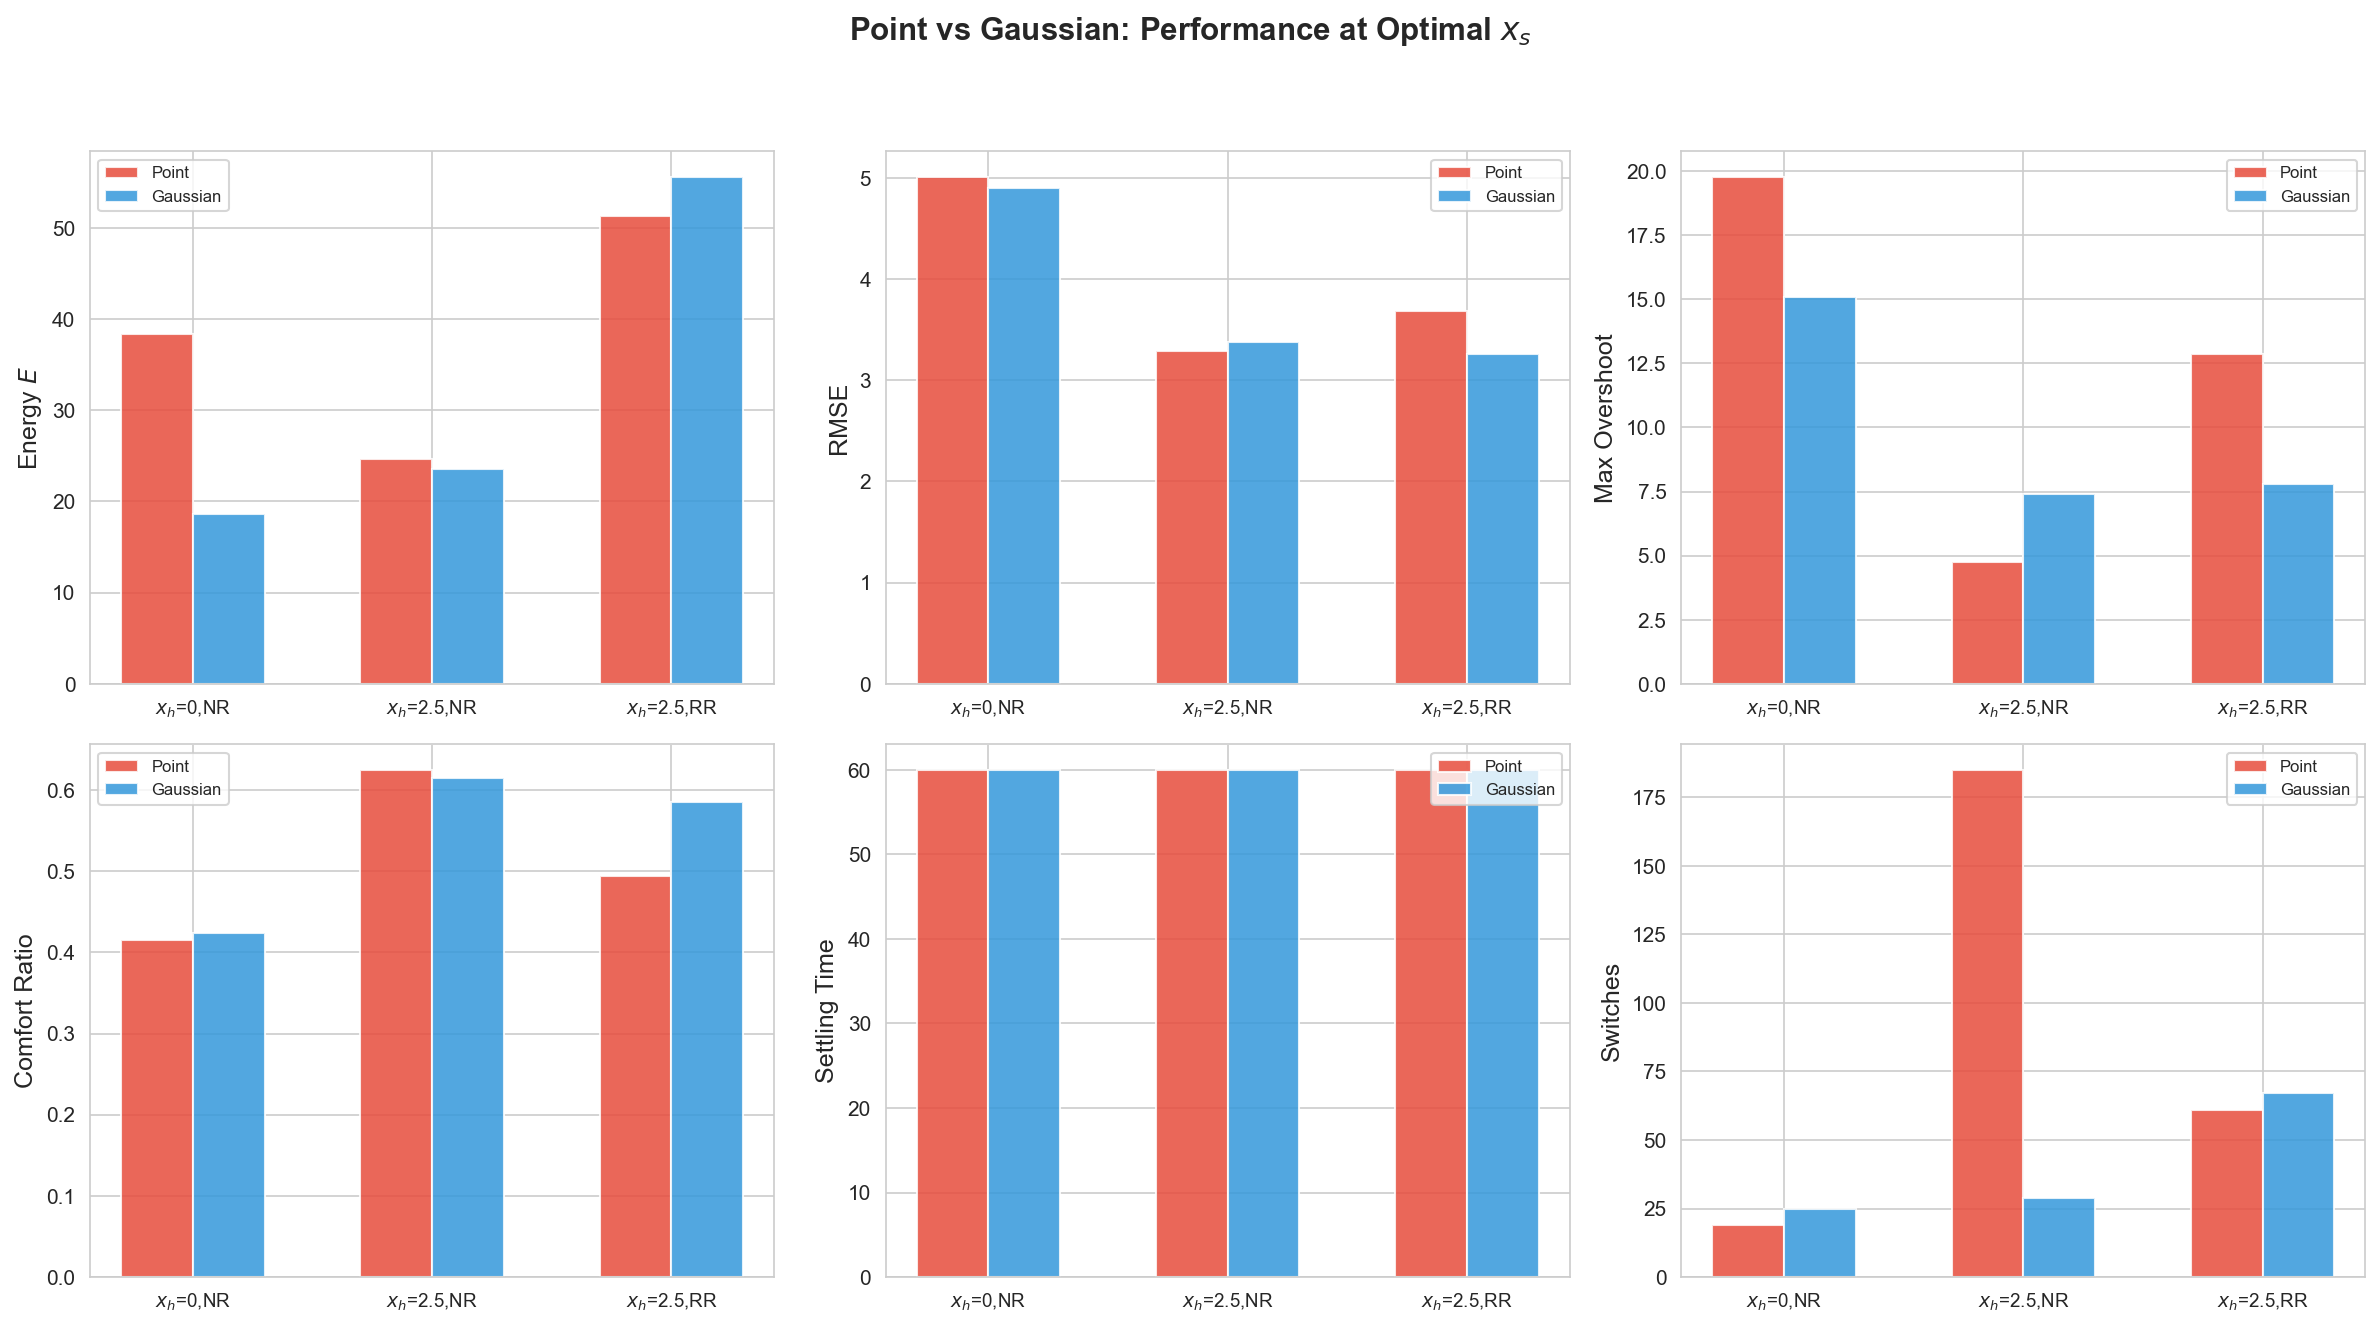


=== 全枚举全局最优方案 ===

J_Balanced 最优:
  x_h=4.43m, x_s=3.46m, source=gaussian, bc=NR
  E=40.6, RMSE=1.556, ΔTmax=8.29, CR=0.851, N_sw=51, J=0.2343

J_Comfort 最优:
  x_h=4.43m, x_s=3.46m, source=gaussian, bc=NR
  E=40.6, RMSE=1.556, ΔTmax=8.29, CR=0.851, N_sw=51, J=0.2325

J_Energy 最优:
  x_h=3.79m, x_s=2.82m, source=gaussian, bc=NR
  E=33.9, RMSE=1.952, ΔTmax=7.23, CR=0.790, N_sw=42, J=0.2486

=== 全部实验最优方案汇总 ===


Config    Source  Best x_s (m)  J (Balanced)   Energy  \
0    1.1: $x_h$=0, N-R     point          1.25      0.397844  38.3125   
1  1.2: $x_h$=2.5, N-R     point          2.75      0.363433  24.6125   
2  1.3: $x_h$=2.5, R-R     point          3.25      0.444519  51.3375   
3    2.1: $x_h$=0, N-R  gaussian          1.25      0.357079  18.6125   
4  2.2: $x_h$=2.5, N-R  gaussian          1.50      0.402087  23.5375   
5  2.3: $x_h$=2.5, R-R  gaussian          1.50      0.460600  55.6125   

       RMSE      ΔTmax        CR  
0  5.013126  19.783706  0.415188  
1  3.294483   4.746636  0.624664  
2  3.685068  12.870642  0.494266  
3  4.900267  15.086419  0.423463  
4  3.382754   7.420662  0.614169  
5  3.261267   7.792124  0.585547

In [17]:
# ============================================================
# 实验 2.5: 全面汇总
# ============================================================

# --- 高斯热源汇总 ---
gauss_sweeps = {
    '2.1: $x_h$=0, N-R': sweep_2_1,
    '2.2: $x_h$=2.5, N-R': sweep_2_2,
    '2.3: $x_h$=2.5, R-R': sweep_2_3,
}

# J vs x_s 高斯热源叠加
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (wname, w) in zip(axes, WEIGHT_SCHEMES.items()):
    for (label, sw), color in zip(gauss_sweeps.items(),
                                   ['#e74c3c', '#3498db', '#2ecc71']):
        J_vals = [compute_unified_cost(m, sw['ref_maxes'], w)
                  for m in sw['metrics']]
        ax.plot(sw['x_s_values'], J_vals, 'o-', color=color,
                linewidth=2, markersize=4, label=label)
        best_i = np.argmin(J_vals)
        ax.scatter([sw['x_s_values'][best_i]], [J_vals[best_i]],
                   s=120, marker='*', color=color, zorder=5, edgecolors='black')
    ax.set_xlabel('Thermostat Position $x_s$ (m)')
    ax.set_ylabel('Unified Cost $J$')
    ax.set_title(f'{wname} Weights')
    ax.legend(fontsize=8)

fig.suptitle('Experiment 2 Summary: $J$ vs $x_s$ — Gaussian Source',
             fontsize=15, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig(f'{OUT_DIR}/1D_exp2_summary_J.png', dpi=300, bbox_inches='tight')
plt.show()

# --- 点热源 vs 高斯热源最优方案对比柱状图 ---
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
fig.suptitle('Point vs Gaussian: Performance at Optimal $x_s$',
             fontsize=15, fontweight='bold')

metric_keys = ['E', 'RMSE', 'DeltaT_max', 'CR', 't_s', 'N_sw']
metric_labels = ['Energy $E$', 'RMSE', 'Max Overshoot', 'Comfort Ratio',
                 'Settling Time', 'Switches']

config_labels = ['$x_h$=0,NR', '$x_h$=2.5,NR', '$x_h$=2.5,RR']
x_pos = np.arange(len(config_labels))

for ax, key, ylabel in zip(axes.flat, metric_keys, metric_labels):
    pt_vals = []
    gs_vals = []
    for sw_pt, sw_gs in [(sweep_1_1, sweep_2_1),
                          (sweep_1_2, sweep_2_2),
                          (sweep_1_3, sweep_2_3)]:
        best_pt = np.argmin(sw_pt['J_values'])
        best_gs = np.argmin(sw_gs['J_values'])
        pt_vals.append(sw_pt['metrics'][best_pt][key])
        gs_vals.append(sw_gs['metrics'][best_gs][key])
    
    ax.bar(x_pos - 0.15, pt_vals, 0.3, color='#e74c3c', label='Point', alpha=0.85)
    ax.bar(x_pos + 0.15, gs_vals, 0.3, color='#3498db', label='Gaussian', alpha=0.85)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(config_labels, fontsize=9)
    ax.set_ylabel(ylabel)
    ax.legend(fontsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.savefig(f'{OUT_DIR}/1D_exp2_5_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# --- 全局最优方案汇总 ---
print('\n=== 全枚举全局最优方案 ===')
for wname in ['J_Balanced', 'J_Comfort', 'J_Energy']:
    best = df_enum.loc[df_enum[wname].idxmin()]
    print(f'\n{wname} 最优:')
    print(f'  x_h={best["x_h"]:.2f}m, x_s={best["x_s"]:.2f}m, '
          f'source={best["source"]}, bc={best["bc"]}')
    print(f'  E={best["E"]:.1f}, RMSE={best["RMSE"]:.3f}, '
          f'ΔTmax={best["DeltaT_max"]:.2f}, CR={best["CR"]:.3f}, '
          f'N_sw={best["N_sw"]:.0f}, J={best[wname]:.4f}')

# 汇总表
all_sweep_data = {**point_sweeps, **gauss_sweeps}
summary_rows_2 = []
for label, sw in all_sweep_data.items():
    best_idx = np.argmin(sw['J_values'])
    m = sw['metrics'][best_idx]
    summary_rows_2.append({
        'Config': label,
        'Source': sw['config']['source_type'],
        'Best x_s (m)': sw['x_s_values'][best_idx],
        'J (Balanced)': sw['J_values'][best_idx],
        'Energy': m['E'], 'RMSE': m['RMSE'],
        'ΔTmax': m['DeltaT_max'], 'CR': m['CR'],
    })

df_summary_all = pd.DataFrame(summary_rows_2)
print('\n=== 全部实验最优方案汇总 ===')
display(df_summary_all)

---

# 实验三：辅助可视化工具

提供三个可视化函数，用于人工检查任意方案的详细行为。

In [18]:
# ============================================================
# 实验 3.1: 稳态温度分布线图
# ============================================================

def plot_steady_state(x_h, x_s, bc_type, source_type, sigma=SIGMA_GAUSS):
    """绘制指定方案的终态温度分布"""
    sim = simulate_1d(x_h, x_s, bc_type=bc_type, source_type=source_type,
                      sigma=sigma)
    m = compute_metrics_1d(sim)
    x = sim['x']
    T_f = sim['T_final']
    
    bc_label = 'N-R' if bc_type == 'NR' else 'R-R'
    src_label = 'Point' if source_type == 'point' else 'Gaussian'
    
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(x, T_f, 'b-', linewidth=2.5, label='$T(x, t_{end})$')
    ax.axhline(T_SET, color='red', linestyle='--', linewidth=1.2, label='$T_{set}$')
    ax.axhspan(T_SET - 0.5, T_SET + 0.5, alpha=0.12, color='green',
               label='$\\pm 0.5°$C zone')
    ax.axhspan(T_COMFORT_LOW, T_COMFORT_HIGH, alpha=0.05, color='blue',
               label=f'Comfort [{T_COMFORT_LOW},{T_COMFORT_HIGH}]°C')
    ax.axvline(x_h, color='orange', linestyle=':', linewidth=2,
               label=f'Heater $x_h$={x_h:.1f}m')
    ax.axvline(x_s, color='purple', linestyle=':', linewidth=2,
               label=f'Thermostat $x_s$={x_s:.1f}m')
    
    ax.set_xlabel('Position $x$ (m)')
    ax.set_ylabel('Temperature ($°$C)')
    ax.set_title(f'Steady-State Profile — $x_h$={x_h:.1f}m, $x_s$={x_s:.1f}m, '
                 f'BC={bc_label}, {src_label}\n'
                 f'E={m["E"]:.1f}, RMSE={m["RMSE"]:.3f}, CR={m["CR"]:.3f}')
    ax.legend(loc='best', fontsize=9)
    ax.set_xlim(0, L)
    plt.tight_layout()
    plt.show()
    return sim, m


# ============================================================
# 实验 3.2: 性能指标面板图
# ============================================================

def plot_performance_panel(sweep, save_path=None):
    """绘制性能指标 vs 扫描变量的 4 面板折线图"""
    cfg = sweep['config']
    x_s_vals = sweep['x_s_values']
    metrics = sweep['metrics']
    
    bc_label = 'N-R' if cfg['bc_type'] == 'NR' else 'R-R'
    src_label = 'Point' if cfg['source_type'] == 'point' else 'Gaussian'
    
    fig, axes = plt.subplots(2, 2, figsize=(13, 9))
    fig.suptitle(f'Performance Metrics — {src_label}, $x_h$={cfg["x_h"]:.1f}m, BC={bc_label}',
                 fontsize=14, fontweight='bold')
    
    panels = [
        ('E', 'Energy Consumption', 'Energy $E$', '#e67e22'),
        ('RMSE', 'Room Average RMSE', 'RMSE ($°$C)', '#3498db'),
        ('DeltaT_max', 'Max Overshoot', '$\\Delta T_{max}$ ($°$C)', '#e74c3c'),
        ('N_sw', 'Heater Switches', '$N_{sw}$', '#9b59b6'),
    ]
    
    for ax, (key, title, ylabel, color) in zip(axes.flat, panels):
        vals = [m[key] for m in metrics]
        ax.plot(x_s_vals, vals, 'o-', color=color, linewidth=2, markersize=5)
        ax.set_xlabel('Thermostat Position $x_s$ (m)')
        ax.set_ylabel(ylabel)
        ax.set_title(title)
    
    plt.tight_layout(rect=[0, 0, 1, 0.94])
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


# ============================================================
# 实验 3.3: 时空热力图
# ============================================================

def plot_spatiotemporal_heatmap(x_h, x_s, bc_type, source_type,
                                 sigma=SIGMA_GAUSS, save_path=None):
    """绘制 1D 温度场时空热力图 T(x, t)"""
    sim = simulate_1d(x_h, x_s, bc_type=bc_type, source_type=source_type,
                      sigma=sigma, return_field=True)
    
    bc_label = 'N-R' if bc_type == 'NR' else 'R-R'
    src_label = 'Point' if source_type == 'point' else 'Gaussian'
    
    fig, ax = plt.subplots(figsize=(14, 5))
    
    T_field = sim['T_field']
    t_field = sim['t_field']
    x = sim['x']
    
    im = ax.pcolormesh(t_field, x, T_field.T, cmap='RdYlBu_r', shading='auto')
    plt.colorbar(im, ax=ax, label='Temperature ($°$C)')
    
    ax.axhline(x_s, color='magenta', linestyle='--', linewidth=1.5,
               label=f'Thermostat $x_s$={x_s:.1f}m')
    ax.axhline(x_h, color='lime', linestyle='--', linewidth=1.5,
               label=f'Heater $x_h$={x_h:.1f}m')
    
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Position $x$ (m)')
    ax.set_title(f'Spatiotemporal Temperature Field $T(x, t)$ — '
                 f'$x_h$={x_h:.1f}m, $x_s$={x_s:.1f}m, BC={bc_label}, {src_label}')
    ax.legend(loc='upper right', fontsize=9)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    return sim

print('辅助可视化工具定义完成。')

辅助可视化工具定义完成。


全局最优: x_h=4.43m, x_s=3.46m, source=gaussian, bc=NR

--- 3.1 稳态温度分布 ---


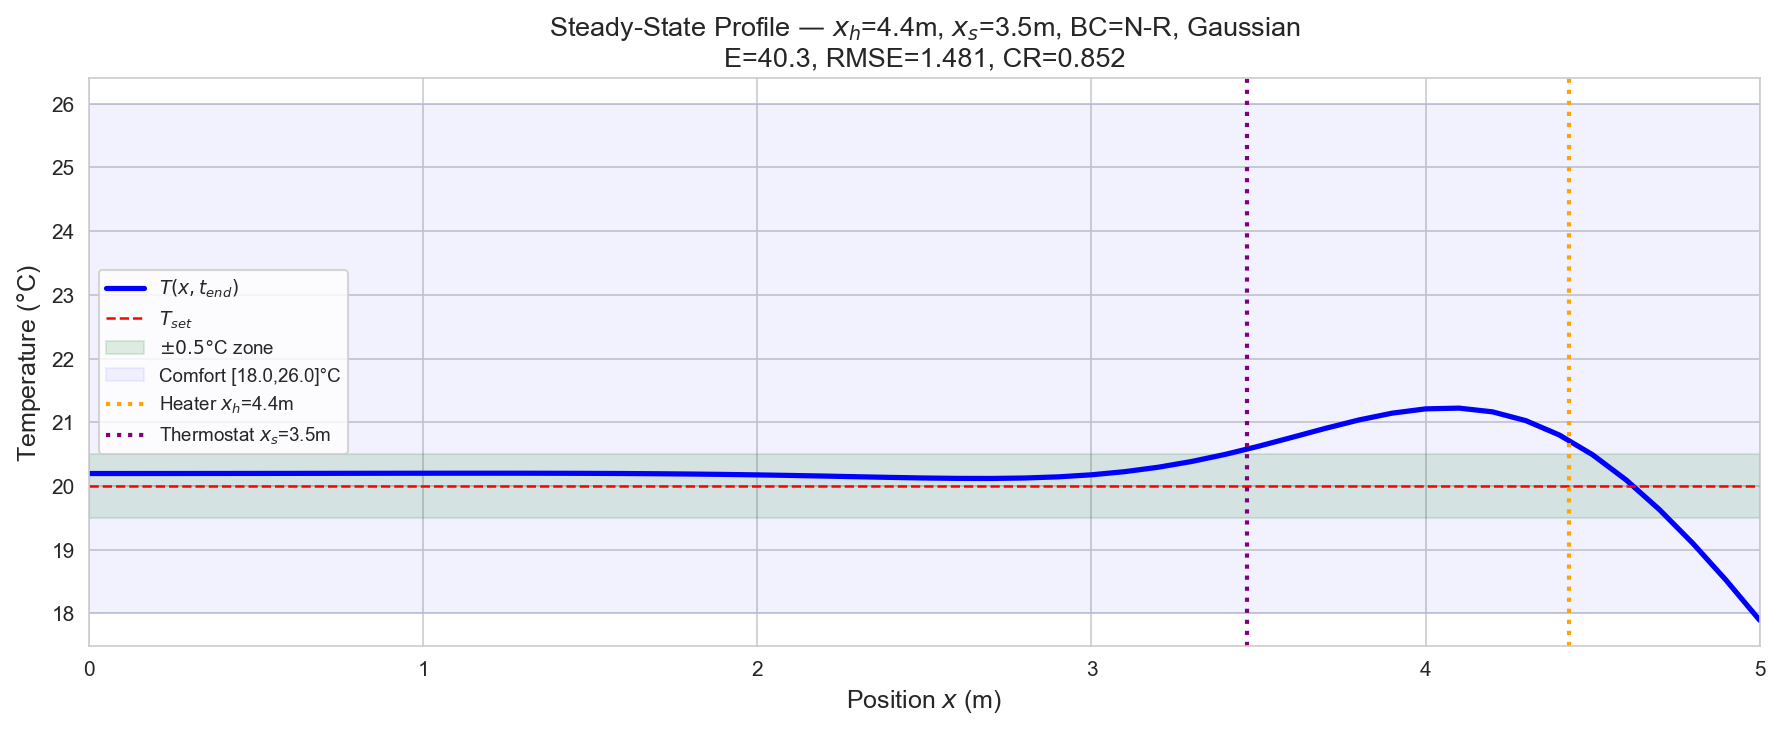


--- 3.3 时空热力图 ---


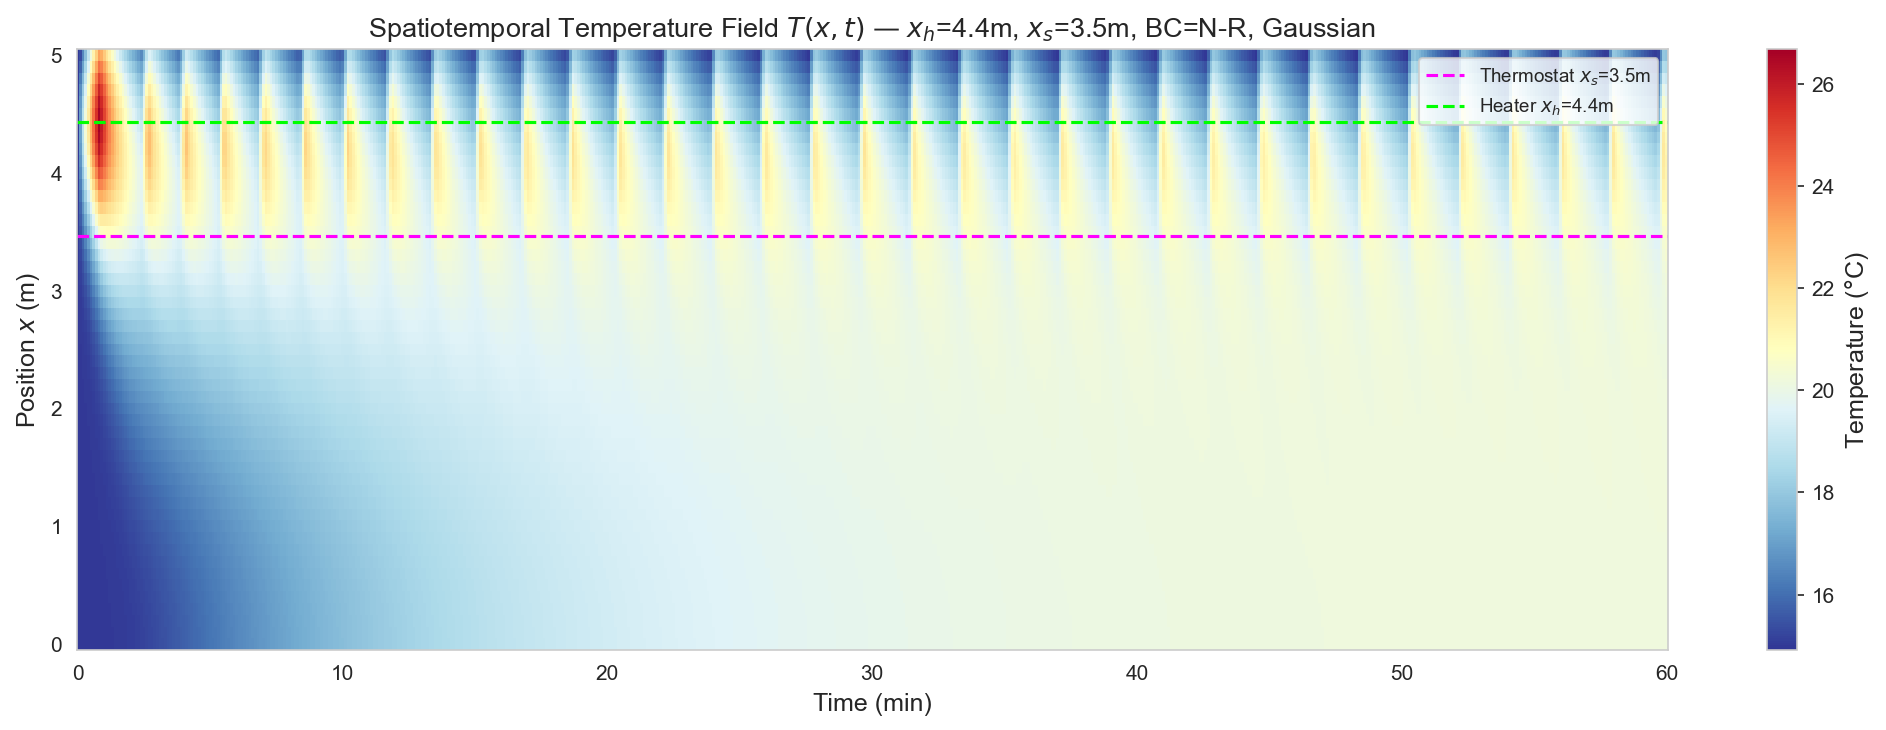

In [19]:
# ============================================================
# 实验三 Demo：使用全枚举最优方案进行可视化
# ============================================================

# 取全局最优方案
best_global = df_enum.loc[df_enum['J_Balanced'].idxmin()]
print(f'全局最优: x_h={best_global["x_h"]:.2f}m, x_s={best_global["x_s"]:.2f}m, '
      f'source={best_global["source"]}, bc={best_global["bc"]}')

# 3.1 稳态温度分布
print('\n--- 3.1 稳态温度分布 ---')
sim_best, m_best = plot_steady_state(
    best_global['x_h'], best_global['x_s'],
    best_global['bc'], best_global['source'])

# 3.3 时空热力图
print('\n--- 3.3 时空热力图 ---')
sim_field = plot_spatiotemporal_heatmap(
    best_global['x_h'], best_global['x_s'],
    best_global['bc'], best_global['source'],
    save_path=f'{OUT_DIR}/1D_exp3_heatmap_best.png')

---

## 总结

### 实验一：点热源

- 恒温器位置对控制性能有显著影响：放在加热器附近读数升温快，控制器过早关闭加热器，远端温度偏低
- 恒温器放在空间平均温度对应的位置附近，综合评分最优
- 加热器从墙角移到中心后，温度分布更均匀，RMSE 下降
- R-R（两面外墙）比 N-R（一面外墙）散热更大，需要更多能耗

### 实验二：高斯热源 vs 点热源

- 高斯热源使温度分布更均匀（RMSE 更低），但最优恒温器位置不一定改变
- 全枚举搜索揭示了加热器-恒温器位置组合的最优解
- 不同权重方案（舒适优先 vs 节能优先）可能导致不同的最优配置

### 关键发现

1. **恒温器不应放在加热器旁边**：传感器读数不代表房间整体温度
2. **加热器位置影响温度均匀度**：中心位置通常优于角落
3. **分布式热源（高斯）优于集中热源（点）**：降低空间温度梯度
4. **边界条件显著影响性能**：保温墙越多，能耗越低，控制越容易

### 下一步

将上述分析扩展到 **2D** 模型，考虑更丰富的空间布局和边界条件组合。